In [1]:
#Script to calculate and plot various statistics of tropical cyclones:
#ACE 
#lifetime
#max wind/min pressure (both overall and at storm peak)
#number of TCs 
#wind/pressure relationship

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import TC_calculations as tcc
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec

In [3]:
#For loading Matlab .mat files:
import scipy.io

In [5]:
#Load the model data saved by Read_Zhao_TCs.ipynb (21 years--1980-2000)
ds_tracks_v1 = xr.open_dataset('nc_from_xarray/zhao_tracks_v1.nc')
ds_tracks_v2 = xr.open_dataset('nc_from_xarray/zhao_tracks_v2.nc')

In [6]:
#Load the IBTrACS observation dataset, as subsetted in Preprocess_IBTrACS.ipynb
#ds_tracks_IB = xr.open_dataset('data_IBTrACS/IBTrACS_1980_2000_6h_min34_saved_20201022.nc')
ds_tracks_IB = xr.open_dataset('data_IBTrACS/IBTrACS_1980_2000_6h_min34_saved_20201029.nc') #With genesis time variable

In [8]:

#####   PREPROCESSING: ADD VARIABLES   #####


In [9]:
ds_tracks_v1['max_wind_kts'] = ds_tracks_v1['wind_kts'].max(dim='date_time')
ds_tracks_v2['max_wind_kts'] = ds_tracks_v2['wind_kts'].max(dim='date_time')
ds_tracks_v1['min_pressure'] = ds_tracks_v1['pressure'].min(dim='date_time')
ds_tracks_v2['min_pressure'] = ds_tracks_v2['pressure'].min(dim='date_time')

In [10]:
ds_tracks_IB['max_usa_wind'] = ds_tracks_IB['usa_wind'].max(dim='date_time')
ds_tracks_IB['min_wmo_pres'] = ds_tracks_IB['wmo_pres'].min(dim='date_time') #usa_pres is all nans

In [11]:
#Indices where these were found, for regional statistics
#(All-nan slice encountered for pressure--skip these for now)
ds_tracks_v1['argmax_wind_kts'] = ds_tracks_v1['wind_kts'].argmax(dim='date_time')
ds_tracks_v2['argmax_wind_kts'] = ds_tracks_v2['wind_kts'].argmax(dim='date_time')
ds_tracks_IB['argmax_usa_wind'] = ds_tracks_IB['usa_wind'].argmax(dim='date_time')

#ds_tracks_v1['argmin_pressure'] = ds_tracks_v1['pressure'].argmin(dim='date_time')
#ds_tracks_v2['argmin_pressure'] = ds_tracks_v2['pressure'].argmin(dim='date_time')
#ds_tracks_IB['argmin_wmo_pres'] = ds_tracks_IB['wmo_pres'].argmin(dim='date_time') 

#Actually don't need this because based on origin region.
#But do need it (at least the wind version) for the wind-pressure relationship at peak intensity.

In [13]:

#####   COUNTS OF TROPICAL CYCLONES   #####


In [14]:
#Number of tropical cyclones in each basin in model versions and observations--box plots. 
#Adam & Suzana say: in case storm crosses over, count location based on genesis points

In [15]:
#Refer to the map_genesis_points function in Plot_Tracks
#For model have to exclude any nans at the beginning.

In [16]:
#How to store these? XArray Datasets with year dimension; 
#Each variable is the count for a region, hemisphere, or globally.
#And what are Jeff's box plots actually showing--median on what dimension? Year?
#So probably, count the storms in each year both globally and subset by region.

In [17]:
#Calculate counts for model v1
regions = ['NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
count_dict_v1 = {'G': np.zeros(21), 
                 'NH': np.zeros(21), 
                 'SH': np.zeros(21), 
                 'NI': np.zeros(21), 
                 'WP': np.zeros(21), 
                 'EP': np.zeros(21), 
                 'NA': np.zeros(21), 
                 'SI': np.zeros(21), 
                 'AUS': np.zeros(21), 
                 'SP': np.zeros(21), 
                 'SA': np.zeros(21)}

#Count the storms in each region based on genesis location
for i in np.arange(len(ds_tracks_v1['storm'])):
    year = int(ds_tracks_v1['year'].isel(storm=i,date_time=0))-1980
    count_dict_v1['G'][year] += 1
    if ds_tracks_v1['in_NH'].isel(storm=i, date_time=0):
        count_dict_v1['NH'][year] += 1
    else:
        count_dict_v1['SH'][year] += 1
    for region in regions:
        if ds_tracks_v1['in_'+region].isel(storm=i, date_time=0):
            count_dict_v1[region][year] += 1

#Create dict of DataArrays and merge
da_dict_v1 = dict()
for key in count_dict_v1.keys():
    da_dict_v1[key] = xr.DataArray(count_dict_v1[key], coords=[pd.Index(np.arange(21)+1980, name='year')], name='count_'+key)
Counts_v1 = xr.merge(da_dict_v1.values())

In [18]:
#print(Counts_v1)
#Looks right. Took about 10 seconds.

In [19]:
#Same for model V2
regions = ['NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
count_dict_v2 = {'G': np.zeros(21), 
                 'NH': np.zeros(21), 
                 'SH': np.zeros(21), 
                 'NI': np.zeros(21), 
                 'WP': np.zeros(21), 
                 'EP': np.zeros(21), 
                 'NA': np.zeros(21), 
                 'SI': np.zeros(21), 
                 'AUS': np.zeros(21), 
                 'SP': np.zeros(21), 
                 'SA': np.zeros(21)}

#Count the storms in each region based on genesis location
for i in np.arange(len(ds_tracks_v2['storm'])):
    year = int(ds_tracks_v2['year'].isel(storm=i,date_time=0))-1980
    count_dict_v2['G'][year] += 1
    if ds_tracks_v2['in_NH'].isel(storm=i, date_time=0):
        count_dict_v2['NH'][year] += 1
    else:
        count_dict_v2['SH'][year] += 1
    for region in regions:
        if ds_tracks_v2['in_'+region].isel(storm=i, date_time=0):
            count_dict_v2[region][year] += 1

#Create dict of DataArrays and merge
da_dict_v2 = dict()
for key in count_dict_v2.keys():
    da_dict_v2[key] = xr.DataArray(count_dict_v2[key], coords=[pd.Index(np.arange(21)+1980, name='year')], name='count_'+key)
Counts_v2 = xr.merge(da_dict_v2.values())

In [21]:
#Same for the observations 
#Accounting for nans with lat/lon==find first index that's not a nan for each storm

#Maybe should use all lon/lat instead of USA? 

regions = ['NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
count_dict_IB = {'G': np.zeros(21), 
                 'NH': np.zeros(21), 
                 'SH': np.zeros(21), 
                 'NI': np.zeros(21), 
                 'WP': np.zeros(21), 
                 'EP': np.zeros(21), 
                 'NA': np.zeros(21), 
                 'SI': np.zeros(21), 
                 'AUS': np.zeros(21), 
                 'SP': np.zeros(21), 
                 'SA': np.zeros(21)}

#Count the storms in each region based on genesis location
for i in np.arange(len(ds_tracks_IB['storm'])):
    first_nonan_index = 0
    for j in np.arange(len(ds_tracks_IB['date_time'])):
        if not(np.isnan(ds_tracks_IB['usa_lat'].isel(storm=i,date_time=j))):
            first_nonan_index = j
            #if j > 0:
            #    print('first usa lat not nan in column: ' + str(first_nonan_index) + ' for storm: ' +str(i) )
            break
    year = int(ds_tracks_IB['time.year'].isel(storm=i,date_time=first_nonan_index))-1980
    count_dict_IB['G'][year] += 1
    if ds_tracks_IB['in_NH'].isel(storm=i, date_time=first_nonan_index):
        count_dict_IB['NH'][year] += 1
    else:
        count_dict_IB['SH'][year] += 1
    for region in regions:
        if ds_tracks_IB['in_'+region].isel(storm=i, date_time=first_nonan_index):
            count_dict_IB[region][year] += 1
    if i == 409: #Testing a West Pacific storm
        print(first_nonan_index)
        print(ds_tracks_IB['in_WP'].isel(storm=i,date_time=first_nonan_index-1))
        print(ds_tracks_IB['in_WP'].isel(storm=i,date_time=first_nonan_index))
        print(ds_tracks_IB['in_WP'].isel(storm=i,date_time=first_nonan_index+1))
        print(year)

#Create dict of DataArrays and merge
da_dict_IB = dict()
for key in count_dict_IB.keys():
    da_dict_IB[key] = xr.DataArray(count_dict_IB[key], coords=[pd.Index(np.arange(21)+1980, name='year')], name='count_'+key)
Counts_IB = xr.merge(da_dict_IB.values())

4
<xarray.DataArray 'in_WP' ()>
array(False)
Coordinates:
    time     datetime64[ns] 1985-01-05T18:00:00.000040448
    lat      float32 ...
    lon      float32 ...
<xarray.DataArray 'in_WP' ()>
array(True)
Coordinates:
    time     datetime64[ns] 1985-01-06T00:00:00.000040448
    lat      float32 ...
    lon      float32 ...
<xarray.DataArray 'in_WP' ()>
array(True)
Coordinates:
    time     datetime64[ns] 1985-01-06T06:00:00.000040448
    lat      float32 ...
    lon      float32 ...
5


In [22]:
#11-5-20: redo Southern Hemisphere regions with the genesis season offset by 6 months;
#make 9-panel plot. 

#New dicts for the SH counts, can use the existing ones for NH regions.

In [23]:
count_dict_sh_v1 = { 
                 'SH': np.zeros(22), 
                 'SI': np.zeros(22), 
                 'AUS': np.zeros(22), 
                 'SP': np.zeros(22), 
                 'SA': np.zeros(22)}

#Count the storms in each region based on genesis location
for i in np.arange(len(ds_tracks_v1['storm'])):
    year = int(ds_tracks_v1['sh_season'].isel(storm=i,date_time=0)-1979.5)
    for region in ['SH', 'SI', 'AUS', 'SP', 'SA']:
        if ds_tracks_v1['gen_'+region].isel(storm=i):
            count_dict_sh_v1[region][year] += 1
    
#Create dict of DataArrays and merge
da_dict_sh_v1 = dict()
for key in count_dict_sh_v1.keys():
    da_dict_sh_v1[key] = xr.DataArray(count_dict_sh_v1[key], coords=[pd.Index(np.arange(22)+1979.5, name='season')], name='count_'+key)
Counts_sh_v1 = xr.merge(da_dict_sh_v1.values())

In [24]:
count_dict_sh_v2 = { 
                 'SH': np.zeros(22), 
                 'SI': np.zeros(22), 
                 'AUS': np.zeros(22), 
                 'SP': np.zeros(22), 
                 'SA': np.zeros(22)}

#Count the storms in each region based on genesis location
for i in np.arange(len(ds_tracks_v2['storm'])):
    year = int(ds_tracks_v2['sh_season'].isel(storm=i,date_time=0)-1979.5)
    for region in ['SH', 'SI', 'AUS', 'SP', 'SA']:
        if ds_tracks_v2['gen_'+region].isel(storm=i):
            count_dict_sh_v2[region][year] += 1
    
#Create dict of DataArrays and merge
da_dict_sh_v2 = dict()
for key in count_dict_sh_v2.keys():
    da_dict_sh_v2[key] = xr.DataArray(count_dict_sh_v2[key], coords=[pd.Index(np.arange(22)+1979.5, name='season')], name='count_'+key)
Counts_sh_v2 = xr.merge(da_dict_sh_v2.values())

In [25]:
#Observations: use gen_sh_season
count_dict_sh_IB = { 
                 'SH': np.zeros(22), 
                 'SI': np.zeros(22), 
                 'AUS': np.zeros(22), 
                 'SP': np.zeros(22), 
                 'SA': np.zeros(22)}

for i in np.arange(len(ds_tracks_IB['storm'])):
    year = int(ds_tracks_IB['gen_sh_season'].isel(storm=i)-1979.5)
    for region in ['SH', 'SI', 'AUS', 'SP', 'SA']:
        if ds_tracks_IB['gen_'+region].isel(storm=i):
            count_dict_sh_IB[region][year] += 1
            
#Create dict and merge
da_dict_sh_IB = dict()
for key in count_dict_sh_IB.keys():
    da_dict_sh_IB[key] = xr.DataArray(count_dict_sh_IB[key], coords=[pd.Index(np.arange(22)+1979.5, name='season')], name='count_'+key)
Counts_sh_IB = xr.merge(da_dict_sh_IB.values())

In [26]:
print(Counts_IB['count_WP'])

#Worked after some fixes. Should be in the 20s and 30s.

#Correct output (array portion): 
#array([24., 28., 27., 23., 28., 26., 27., 24., 25., 30., 32., 29., 33., 30.,
#       34., 28., 36., 32., 19., 24., 27.])

<xarray.DataArray 'count_WP' (year: 21)>
array([24., 28., 27., 23., 28., 26., 27., 24., 25., 30., 32., 29., 33.,
       30., 34., 28., 36., 32., 19., 24., 27.])
Coordinates:
  * year     (year) int64 1980 1981 1982 1983 1984 ... 1996 1997 1998 1999 2000


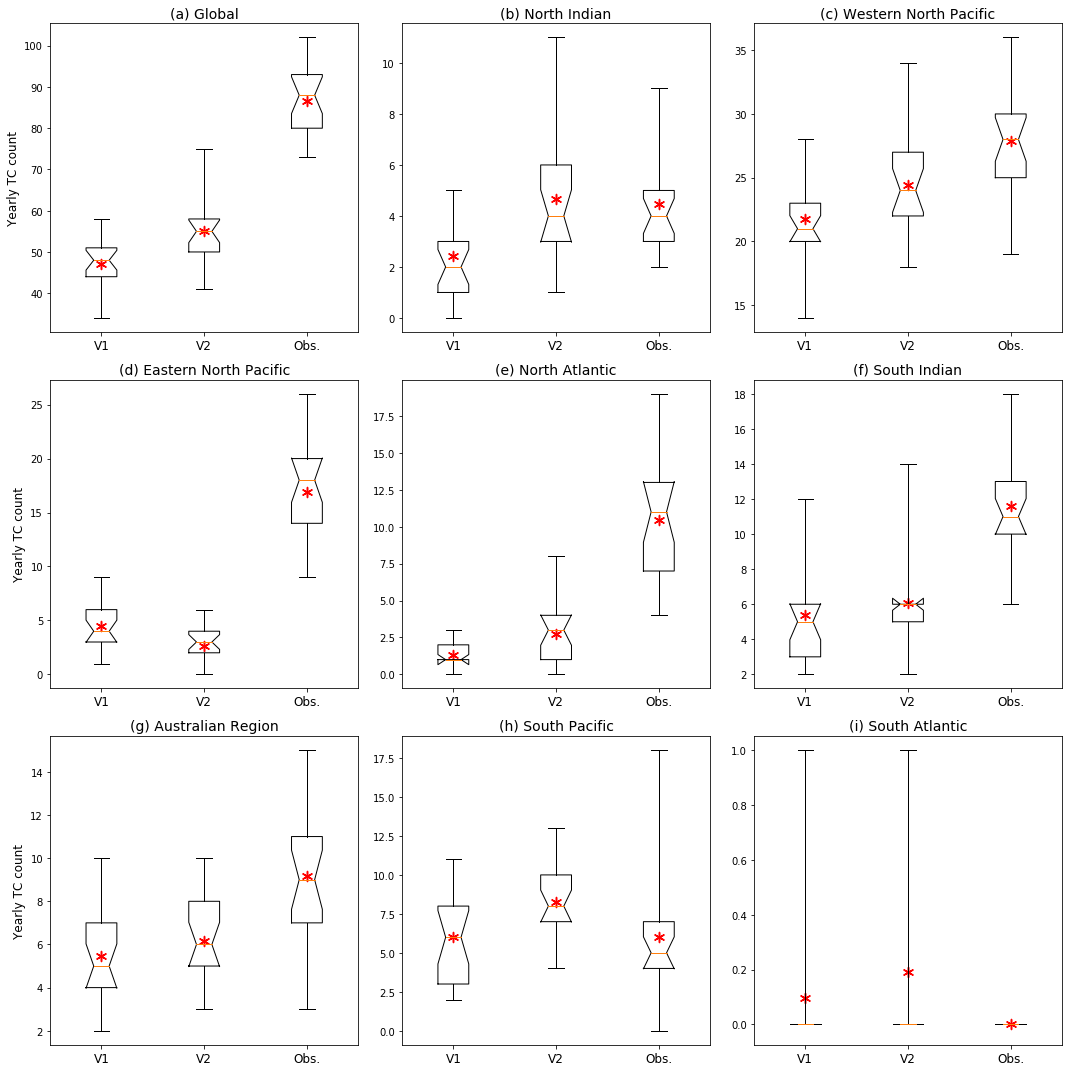

In [39]:
#Plot box plots for the globe, each hemisphere, and each region. 
#What's the most compact, publication-friendly way to do this? 
#9 panels with globe in upper left and 8 regions; hemispheres separately
plt.figure(figsize=((15,15)))
plt.subplot(3,3,1)
plt.boxplot([Counts_v1['count_G'], Counts_v2['count_G'], Counts_IB['count_G']], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([Counts_v1['count_G'].mean(dim='year').data, Counts_v2['count_G'].mean(dim='year').data, Counts_IB['count_G'].mean(dim='year').data]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylabel('Yearly TC count', fontsize=12)
plt.title('(a) Global', fontsize=14)
regions = ['NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
region_names = {'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters = {0: 'b', 
           1: 'c', 
           2: 'd', 
           3: 'e', 
           4: 'f', 
           5: 'g', 
           6: 'h', 
           7: 'i'}
for i in np.arange(8):
    plt.subplot(3,3,i+2)
    region = regions[i]
    plt.boxplot([Counts_v1['count_'+region], Counts_v2['count_'+region], Counts_IB['count_'+region]], notch=True, whis=(0,100))
    plt.scatter(np.array([1.,2.,3.]), 
                np.array([Counts_v1['count_'+region].mean(dim='year').data, Counts_v2['count_'+region].mean(dim='year').data, Counts_IB['count_'+region].mean(dim='year').data]), 
                marker=(6,2), c='red', s=100)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
    if i in [2,5]:
        plt.ylabel('Yearly TC count', fontsize=12)
    plt.title('('+letters[i]+') ' +region_names[region], fontsize=14)
plt.tight_layout()

# plt.savefig('plots/counts_boxplots_global_regions.png')
# plt.savefig('plots/counts_boxplots_global_regions.pdf')



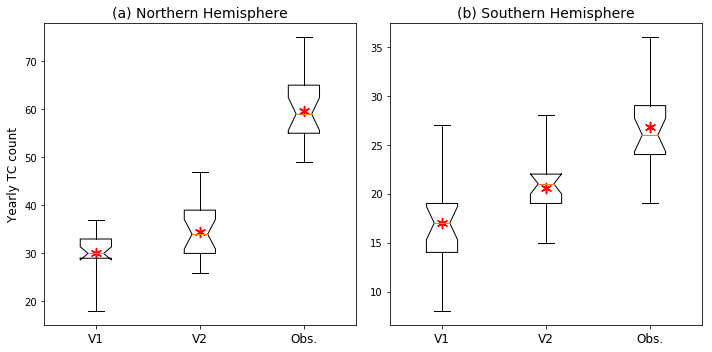

In [40]:
#2 hemispheres
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot([Counts_v1['count_NH'], Counts_v2['count_NH'], Counts_IB['count_NH']], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([Counts_v1['count_NH'].mean(dim='year').data, Counts_v2['count_NH'].mean(dim='year').data, Counts_IB['count_NH'].mean(dim='year').data]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylabel('Yearly TC count', fontsize=12)
plt.title('(a) Northern Hemisphere', fontsize=14)

plt.subplot(1,2,2)
plt.boxplot([Counts_v1['count_SH'], Counts_v2['count_SH'], Counts_IB['count_SH']], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([Counts_v1['count_SH'].mean(dim='year').data, Counts_v2['count_SH'].mean(dim='year').data, Counts_IB['count_SH'].mean(dim='year').data]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
#plt.ylabel('Yearly TC count')
plt.title('(b) Southern Hemisphere', fontsize=14)

plt.tight_layout()

# plt.savefig('plots/counts_boxplots_hemispheres.png')
# plt.savefig('plots/counts_boxplots_hemispheres.pdf')

In [41]:
#Later version: 9 panels (2 hemispheres and 7 regions, excluding SA)
#using the separate Southern Hemisphere seasons, excluding the two half-seasons.

In [42]:
print(Counts_sh_v1.season)
print(Counts_sh_v1['count_SH'])

<xarray.DataArray 'season' (season: 22)>
array([1979.5, 1980.5, 1981.5, 1982.5, 1983.5, 1984.5, 1985.5, 1986.5, 1987.5,
       1988.5, 1989.5, 1990.5, 1991.5, 1992.5, 1993.5, 1994.5, 1995.5, 1996.5,
       1997.5, 1998.5, 1999.5, 2000.5])
Coordinates:
  * season   (season) float64 1.98e+03 1.98e+03 1.982e+03 ... 2e+03 2e+03
<xarray.DataArray 'count_SH' (season: 22)>
array([14.,  9., 11., 20., 17., 16., 17., 18., 18., 27., 15., 20., 16., 17.,
       13., 30., 10., 14., 19., 18., 14.,  3.])
Coordinates:
  * season   (season) float64 1.98e+03 1.98e+03 1.982e+03 ... 2e+03 2e+03


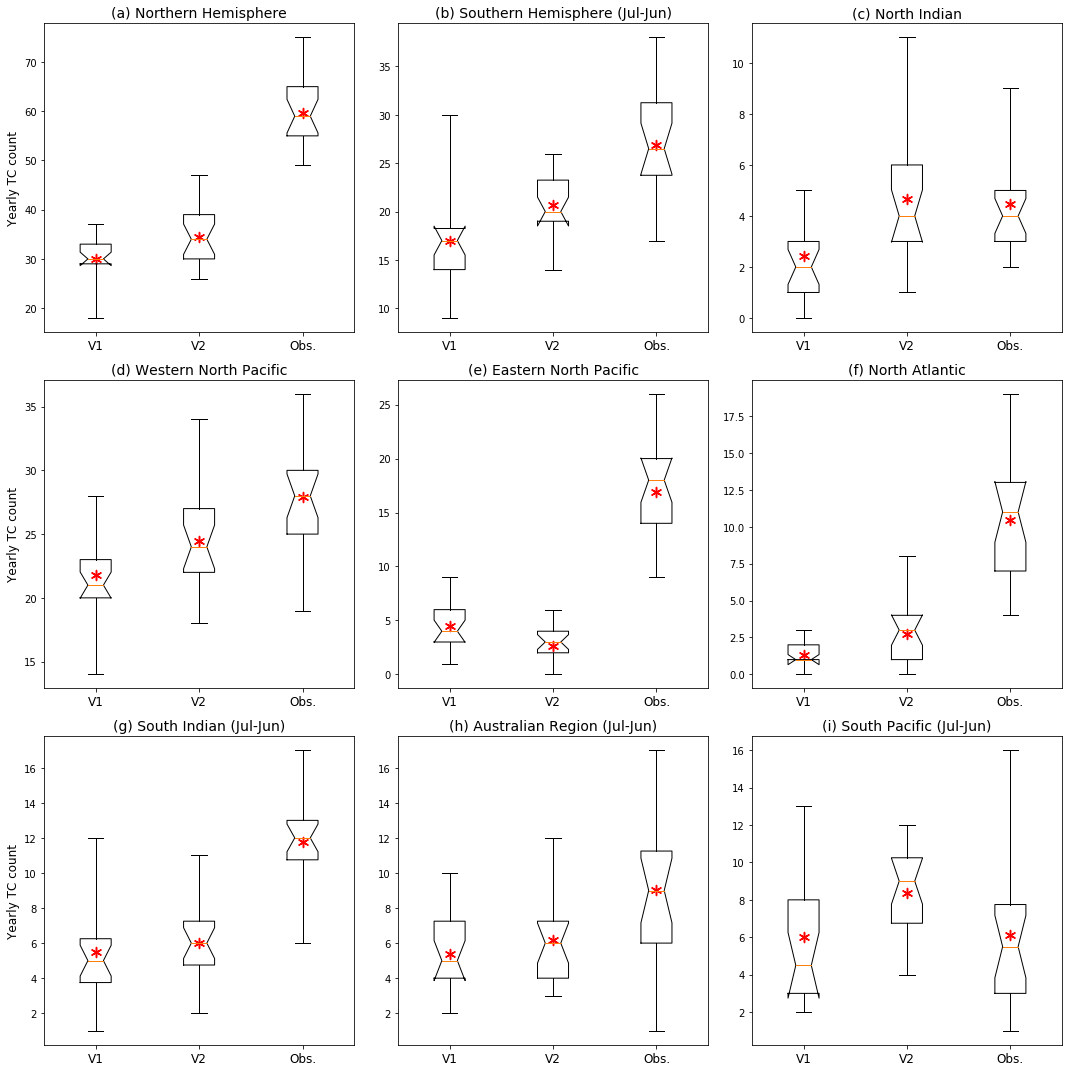

In [43]:
plt.figure(figsize=((15,15)))
plt.subplot(3,3,1)
plt.boxplot([Counts_v1['count_NH'], Counts_v2['count_NH'], Counts_IB['count_NH']], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([Counts_v1['count_NH'].mean(dim='year').data, 
                      Counts_v2['count_NH'].mean(dim='year').data, 
                      Counts_IB['count_NH'].mean(dim='year').data]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylabel('Yearly TC count', fontsize=12)
plt.title('(a) Northern Hemisphere', fontsize=14)

plt.subplot(3,3,2)
plt.boxplot([Counts_sh_v1['count_SH'].isel(season=np.arange(20)+1), 
             Counts_sh_v2['count_SH'].isel(season=np.arange(20)+1), 
             Counts_sh_IB['count_SH'].isel(season=np.arange(20)+1)], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([Counts_sh_v1['count_SH'].isel(season=np.arange(20)+1).mean(dim='season').data, 
                      Counts_sh_v2['count_SH'].isel(season=np.arange(20)+1).mean(dim='season').data, 
                      Counts_sh_IB['count_SH'].isel(season=np.arange(20)+1).mean(dim='season').data]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.title('(b) Southern Hemisphere (Jul-Jun)', fontsize=14)

regions = ['NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
region_names = {'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters = {0: 'c', 
           1: 'd', 
           2: 'e', 
           3: 'f', 
           4: 'g', 
           5: 'h', 
           6: 'i'}

#Plot the NH regions
for i in np.arange(4):
    plt.subplot(3,3,i+3)
    region = regions[i]
    plt.boxplot([Counts_v1['count_'+region], 
                 Counts_v2['count_'+region], 
                 Counts_IB['count_'+region]], notch=True, whis=(0,100))
    plt.scatter(np.array([1.,2.,3.]), 
                np.array([Counts_v1['count_'+region].mean(dim='year').data, 
                          Counts_v2['count_'+region].mean(dim='year').data, 
                          Counts_IB['count_'+region].mean(dim='year').data]), 
                marker=(6,2), c='red', s=100)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
    if i in [1,4]:
        plt.ylabel('Yearly TC count', fontsize=12)
    plt.title('('+letters[i]+') ' +region_names[region], fontsize=14)
    
#Plot the SH regions
for i in np.arange(4,7):
    plt.subplot(3,3,i+3)
    region = regions[i]
    plt.boxplot([Counts_sh_v1['count_'+region].isel(season=np.arange(20)+1), 
                 Counts_sh_v2['count_'+region].isel(season=np.arange(20)+1), 
                 Counts_sh_IB['count_'+region].isel(season=np.arange(20)+1)], notch=True, whis=(0,100))
    plt.scatter(np.array([1.,2.,3.]), 
                np.array([Counts_sh_v1['count_'+region].isel(season=np.arange(20)+1).mean(dim='season').data, 
                          Counts_sh_v2['count_'+region].isel(season=np.arange(20)+1).mean(dim='season').data, 
                          Counts_sh_IB['count_'+region].isel(season=np.arange(20)+1).mean(dim='season').data]), 
                marker=(6,2), c='red', s=100)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
    if i in [1,4]:
        plt.ylabel('Yearly TC count', fontsize=12)
    plt.title('('+letters[i]+') ' +region_names[region]+' (Jul-Jun)', fontsize=14)
    
    
plt.tight_layout()

# plt.savefig('plots/counts_boxplots_hemispheres_7regions.png')
# plt.savefig('plots/counts_boxplots_hemispheres_7regions.pdf')


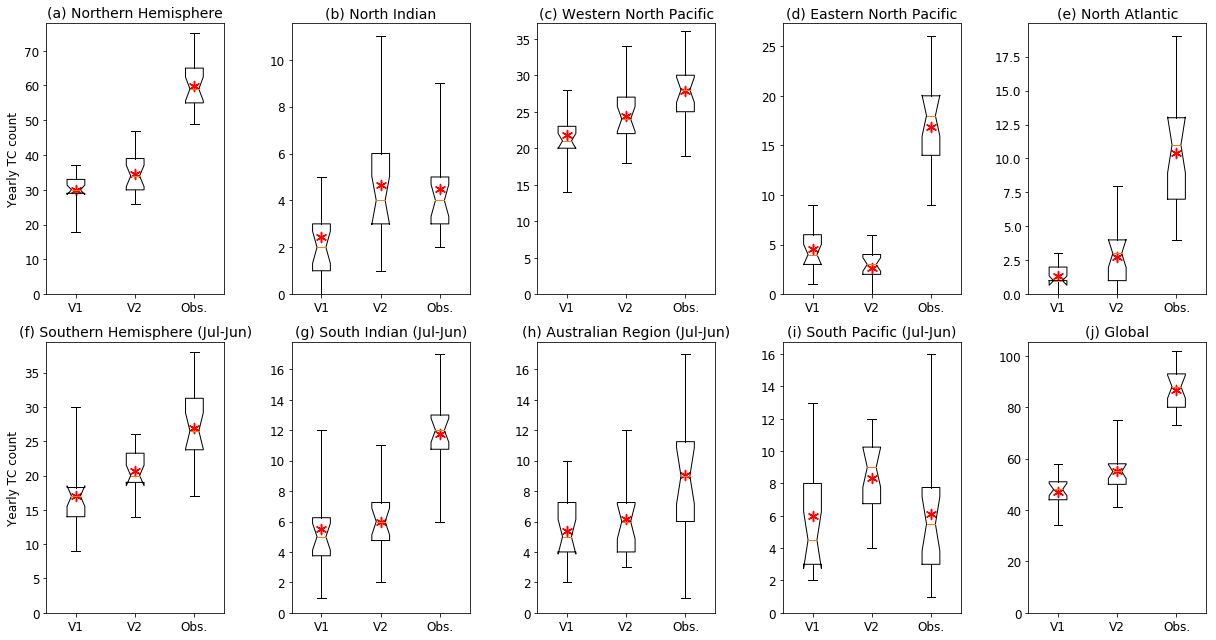

In [47]:
#10-panel version

plt.figure(figsize=(17,9))
regions_10 = ['NH', 'NI', 'WP', 'EP', 'NA', 'SH', 'SI', 'AUS', 'SP', 'G']
region_names = {'NH': 'Northern Hemisphere', 
                'SH': 'Southern Hemisphere', 
                'G': 'Global',
                'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters = {0: 'a', 
           1: 'b', 
           2: 'c', 
           3: 'd', 
           4: 'e', 
           5: 'f', 
           6: 'g', 
           7: 'h',
           8: 'i', 
           9: 'j'}

for i in np.arange(10):
    plt.subplot(2,5,i+1)
    region = regions_10[i]
    if region in ['SH', 'SI', 'AUS', 'SP']:
        plt.boxplot([Counts_sh_v1['count_'+region].isel(season=np.arange(20)+1), 
                     Counts_sh_v2['count_'+region].isel(season=np.arange(20)+1), 
                     Counts_sh_IB['count_'+region].isel(season=np.arange(20)+1)], 
                     notch=True, whis=(0,100))
        plt.scatter(np.array([1.,2.,3.]), 
                    np.array([Counts_sh_v1['count_'+region].isel(season=np.arange(20)+1).mean(dim='season').data, 
                              Counts_sh_v2['count_'+region].isel(season=np.arange(20)+1).mean(dim='season').data, 
                              Counts_sh_IB['count_'+region].isel(season=np.arange(20)+1).mean(dim='season').data]), 
                    marker=(6,2), c='red', s=100)
        plt.title('('+letters[i]+') ' +region_names[region]+' (Jul-Jun)', fontsize=14)    
    else:
        plt.boxplot([Counts_v1['count_'+region], 
                     Counts_v2['count_'+region], 
                     Counts_IB['count_'+region]], 
                    notch=True, whis=(0,100))
        plt.scatter(np.array([1.,2.,3.]), 
                    np.array([Counts_v1['count_'+region].mean(dim='year').data, 
                              Counts_v2['count_'+region].mean(dim='year').data, 
                              Counts_IB['count_'+region].mean(dim='year').data]), 
                    marker=(6,2), c='red', s=100)
        plt.title('('+letters[i]+') ' +region_names[region], fontsize=14)   
    if i in [0,5]:
        plt.ylabel('Yearly TC count', fontsize=12)
    plt.gca().set_ylim(bottom=0)
    plt.gca().tick_params(labelsize=12)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
        
plt.tight_layout()
plt.savefig('plots/counts_boxplots_10panels.png')
plt.savefig('plots/counts_boxplots_10panels.pdf')

In [63]:
print(Counts_v1)

<xarray.Dataset>
Dimensions:    (year: 21)
Coordinates:
  * year       (year) int64 1980 1981 1982 1983 1984 ... 1997 1998 1999 2000
Data variables:
    count_G    (year) float64 51.0 34.0 46.0 45.0 49.0 ... 46.0 37.0 53.0 43.0
    count_NH   (year) float64 34.0 26.0 31.0 30.0 32.0 ... 32.0 18.0 36.0 29.0
    count_SH   (year) float64 17.0 8.0 15.0 15.0 17.0 ... 14.0 19.0 17.0 14.0
    count_NI   (year) float64 0.0 1.0 3.0 3.0 3.0 4.0 ... 2.0 5.0 1.0 3.0 2.0
    count_WP   (year) float64 22.0 21.0 22.0 21.0 20.0 ... 20.0 14.0 28.0 21.0
    count_EP   (year) float64 9.0 2.0 4.0 5.0 9.0 6.0 ... 3.0 6.0 1.0 3.0 4.0
    count_NA   (year) float64 3.0 2.0 2.0 1.0 0.0 1.0 ... 1.0 1.0 2.0 2.0 2.0
    count_SI   (year) float64 3.0 2.0 6.0 3.0 2.0 5.0 ... 3.0 6.0 5.0 10.0 6.0
    count_AUS  (year) float64 6.0 4.0 5.0 4.0 7.0 7.0 ... 5.0 4.0 3.0 5.0 5.0
    count_SP   (year) float64 8.0 2.0 4.0 8.0 8.0 9.0 ... 3.0 4.0 11.0 2.0 3.0
    count_SA   (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 

In [38]:
#Older notes

In [39]:
print(5-3)

2


In [25]:
#Something isn't right--no typhoons in 1985 for example? 
#Maybe the USA lat/lon are actually missing there and need to use the native lat/lon?

#Testing this out:
#First find storm indices corresponding to 
#The
#for i in np.arange(408,506): #409-504 are the 1985 storms
#    print(ds_tracks_IB.time.isel(storm=i, date_time=0).data)
    
#for i in np.arange(409, 504):
    #print(ds_tracks_IB['in_WP'].isel(storm=i, date_time=0).data)
    #Really--all false?
    #But a number are true at time 5, or 10.
    #print(ds_tracks_IB['in_WP'].isel(storm=i, date_time=5).data)
    #print(ds_tracks_IB['in_WP'].isel(storm=i, date_time=10).data)
    #So maybe the thing about finding the non-nan portion didn't work?

In [26]:
#Can I find particular storms that should be in West Pacific for those years? Or did JTWC not report on them at all, therefore missing?
#But no, some are in WP true not at first index.
#for i in np.arange(409, 504):
    #print(str(ds_tracks_IB['in_WP'].isel(storm=i, date_time=5).data) +' '+ str(ds_tracks_IB['usa_lat'].isel(storm=i, date_time=5).data))
    
    #All the trues have lats, no true-nan pair which would be causing my problem.
    # 409 is indeed a West Pacific storm. So what is going on?
    
    #Fixed this problem later

In [11]:

#####   STORM LIFETIME   #####


In [12]:
#Jeff used nansum on each storm for the basin tag matching each particular region.
#So I could do this as well, based on the sum of the Boolean variable. 
#Divided by 4 for days.
#How does this work if a storm crosses between basins?
#From Jeff's definition, 
#Just make a dict of NumPy arrays that are appended onto with the lifetimes.
#Could do the same for wind and pressure distributions regionally.

In [13]:
#10-26-20: following discussion with Suzana and Adam, need to redo this calculation based on the genesis region.
#This is actually pretty easy.

In [14]:
#11-16-20: making 10-panel version

In [15]:
dict_lifetimes_v1 = {'G': np.empty(0), 
                 'NH': np.empty(0), 
                 'SH': np.empty(0), 
                 'NI': np.empty(0), 
                 'WP': np.empty(0), 
                 'EP': np.empty(0), 
                 'NA': np.empty(0), 
                 'SI': np.empty(0), 
                 'AUS': np.empty(0), 
                 'SP': np.empty(0), 
                 'SA': np.empty(0)}
for i in np.arange(len(ds_tracks_v1.storm)):
    if np.mod(i,100) == 0:
        print('Calculating lifetimes for storm: '+str(i))
    dict_lifetimes_v1['G'] = np.append(dict_lifetimes_v1['G'], np.sum(np.logical_not(np.isnan(ds_tracks_v1['lat'].isel(storm=i))))/4.)
    for region in ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']:
        if ds_tracks_v1['gen_'+region].isel(storm=i).data == True:
            dict_lifetimes_v1[region] = np.append(dict_lifetimes_v1[region], np.sum(np.logical_not(np.isnan(ds_tracks_v1['lat'].isel(storm=i))))/4.)
        

Calculating lifetimes for storm: 0
Calculating lifetimes for storm: 100
Calculating lifetimes for storm: 200
Calculating lifetimes for storm: 300
Calculating lifetimes for storm: 400
Calculating lifetimes for storm: 500
Calculating lifetimes for storm: 600
Calculating lifetimes for storm: 700
Calculating lifetimes for storm: 800
Calculating lifetimes for storm: 900


In [16]:
dict_lifetimes_v2 = {'G': np.empty(0), 
                 'NH': np.empty(0), 
                 'SH': np.empty(0), 
                 'NI': np.empty(0), 
                 'WP': np.empty(0), 
                 'EP': np.empty(0), 
                 'NA': np.empty(0), 
                 'SI': np.empty(0), 
                 'AUS': np.empty(0), 
                 'SP': np.empty(0), 
                 'SA': np.empty(0)}
for i in np.arange(len(ds_tracks_v2.storm)):
    if np.mod(i,100) == 0:
        print('Calculating lifetimes for storm: '+str(i))
    dict_lifetimes_v2['G'] = np.append(dict_lifetimes_v2['G'], np.sum(np.logical_not(np.isnan(ds_tracks_v2['lat'].isel(storm=i))))/4.)
    for region in ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']:
        if ds_tracks_v2['gen_'+region].isel(storm=i).data == True:
            dict_lifetimes_v2[region] = np.append(dict_lifetimes_v2[region], np.sum(np.logical_not(np.isnan(ds_tracks_v2['lat'].isel(storm=i))))/4.)
        

Calculating lifetimes for storm: 0
Calculating lifetimes for storm: 100
Calculating lifetimes for storm: 200
Calculating lifetimes for storm: 300
Calculating lifetimes for storm: 400
Calculating lifetimes for storm: 500
Calculating lifetimes for storm: 600
Calculating lifetimes for storm: 700
Calculating lifetimes for storm: 800
Calculating lifetimes for storm: 900
Calculating lifetimes for storm: 1000
Calculating lifetimes for storm: 1100


In [17]:
dict_lifetimes_IB = {'G': np.empty(0), 
                 'NH': np.empty(0), 
                 'SH': np.empty(0), 
                 'NI': np.empty(0), 
                 'WP': np.empty(0), 
                 'EP': np.empty(0), 
                 'NA': np.empty(0), 
                 'SI': np.empty(0), 
                 'AUS': np.empty(0), 
                 'SP': np.empty(0), 
                 'SA': np.empty(0)}
for i in np.arange(len(ds_tracks_IB.storm)):
    if np.mod(i,100) == 0:
        print('Calculating lifetimes for storm: '+str(i))
    dict_lifetimes_IB['G'] = np.append(dict_lifetimes_IB['G'], np.sum(np.logical_not(np.isnan(ds_tracks_IB['usa_lat'].isel(storm=i))))/4.)
    for region in ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']:
        if ds_tracks_IB['gen_'+region].isel(storm=i).data == True:
            dict_lifetimes_IB[region] = np.append(dict_lifetimes_IB[region], np.sum(np.logical_not(np.isnan(ds_tracks_IB['lat'].isel(storm=i))))/4.)
        

Calculating lifetimes for storm: 0
Calculating lifetimes for storm: 100
Calculating lifetimes for storm: 200
Calculating lifetimes for storm: 300
Calculating lifetimes for storm: 400
Calculating lifetimes for storm: 500
Calculating lifetimes for storm: 600
Calculating lifetimes for storm: 700
Calculating lifetimes for storm: 800
Calculating lifetimes for storm: 900
Calculating lifetimes for storm: 1000
Calculating lifetimes for storm: 1100
Calculating lifetimes for storm: 1200
Calculating lifetimes for storm: 1300
Calculating lifetimes for storm: 1400
Calculating lifetimes for storm: 1500
Calculating lifetimes for storm: 1600
Calculating lifetimes for storm: 1700
Calculating lifetimes for storm: 1800


In [18]:
#print(dict_lifetimes_IB)
#Looks all right

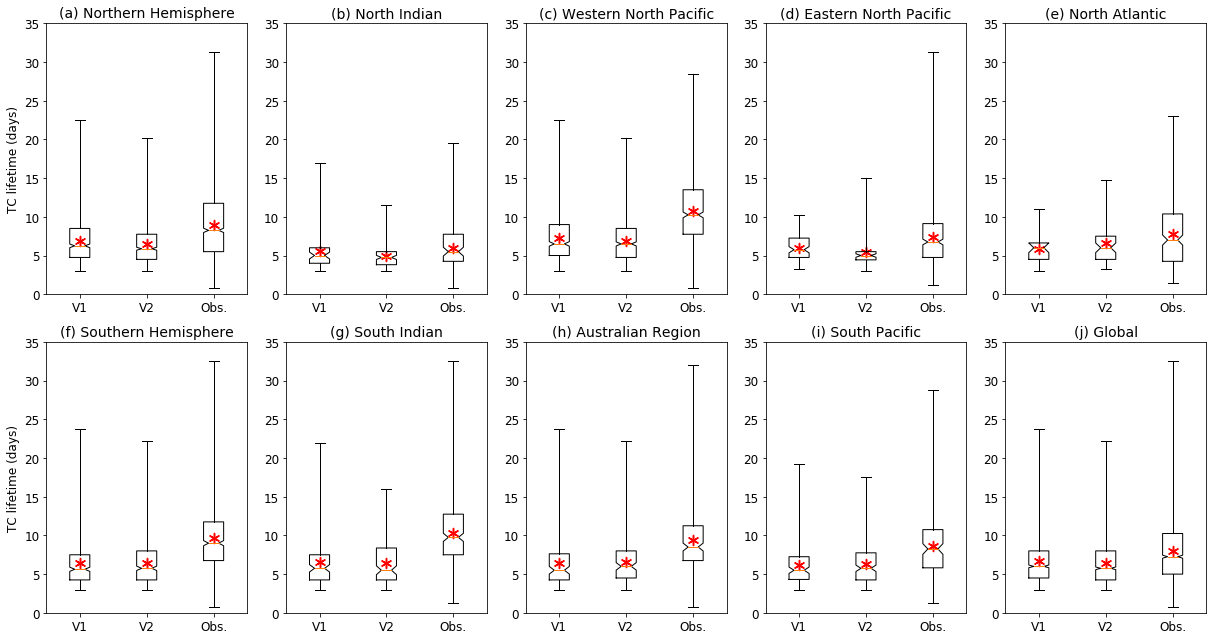

In [20]:
#10 panel figure with similar format to the count and ACE plots

plt.figure(figsize=(17,9))
regions_10 = ['NH', 'NI', 'WP', 'EP', 'NA', 'SH', 'SI', 'AUS', 'SP', 'G']
region_names = {'NH': 'Northern Hemisphere', 
                'SH': 'Southern Hemisphere', 
                'G': 'Global',
                'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters = {0: 'a', 
           1: 'b', 
           2: 'c', 
           3: 'd', 
           4: 'e', 
           5: 'f', 
           6: 'g', 
           7: 'h',
           8: 'i', 
           9: 'j'}

for i in np.arange(10):
    plt.subplot(2,5,i+1)
    region = regions_10[i]
    plt.boxplot([dict_lifetimes_v1[region], 
                 dict_lifetimes_v2[region], 
                 dict_lifetimes_IB[region]], 
                notch=True, whis=(0,100))
    plt.scatter(np.array([1.,2.,3.]), 
                np.array(np.array([np.mean(dict_lifetimes_v1[region]), 
                                   np.mean(dict_lifetimes_v2[region]), 
                                   np.mean(dict_lifetimes_IB[region])])), 
                marker=(6,2), c='red', s=100)
    plt.ylim([0,35])
    plt.title('('+letters[i]+') ' +region_names[region], fontsize=14)    
    if i in [0,5]:
        plt.ylabel('TC lifetime (days)', fontsize=12)
    plt.gca().tick_params(labelsize=12)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
        
plt.tight_layout()
plt.savefig('plots/lifetimes_boxplots_10panels.png')
plt.savefig('plots/lifetimes_boxplots_10panels.pdf')

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


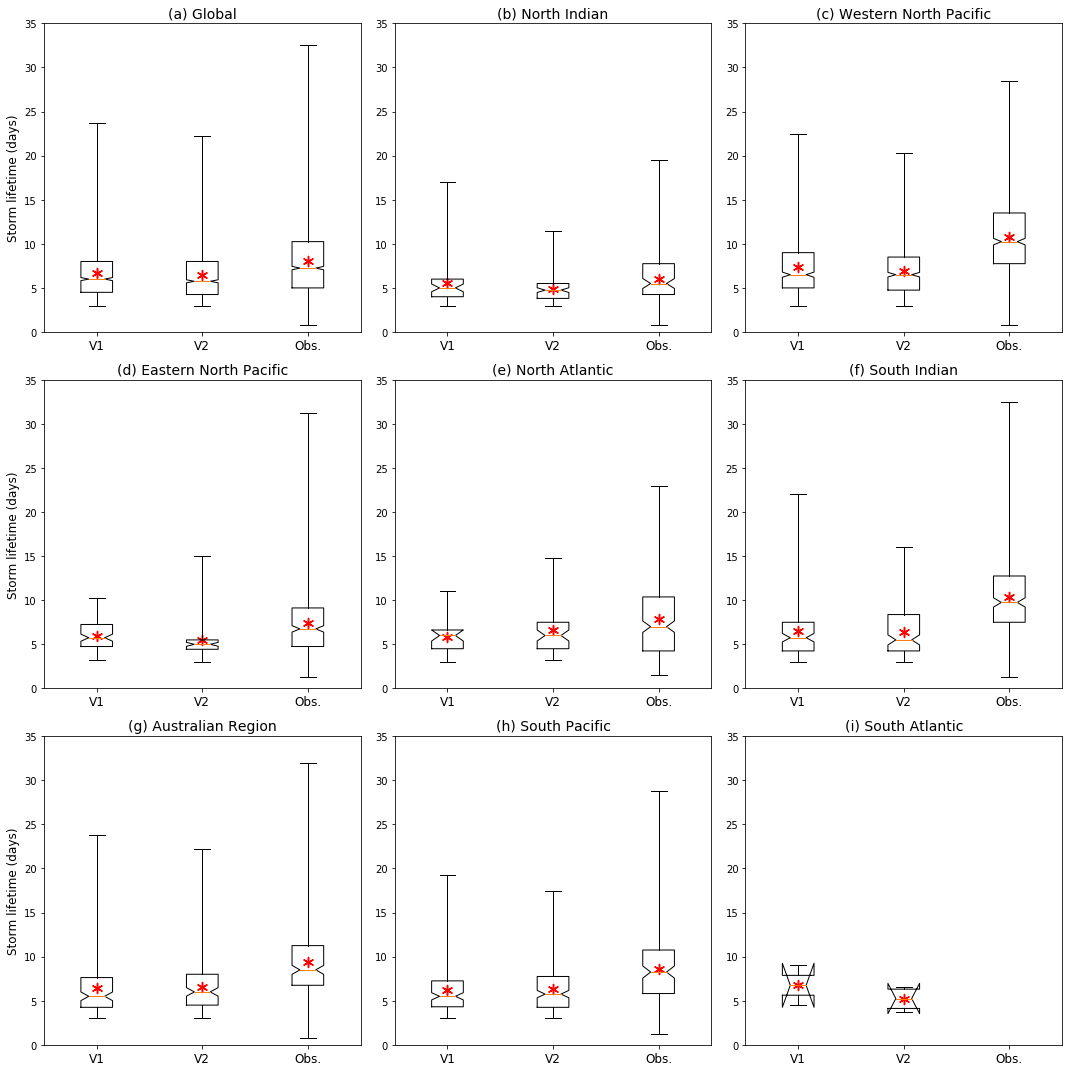

In [54]:
plt.figure(figsize=((15,15)))
plt.subplot(3,3,1)
plt.boxplot([dict_lifetimes_v1['G'], dict_lifetimes_v2['G'], dict_lifetimes_IB['G']], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([np.mean(dict_lifetimes_v1['G']), np.mean(dict_lifetimes_v2['G']), np.mean(dict_lifetimes_IB['G'])]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylim([0,35])
plt.ylabel('Storm lifetime (days)', fontsize=12)
plt.title('(a) Global', fontsize=14)

regions = ['NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
region_names = {'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters = {0: 'b', 
           1: 'c', 
           2: 'd', 
           3: 'e', 
           4: 'f', 
           5: 'g', 
           6: 'h', 
           7: 'i'}
for i in np.arange(8):
    plt.subplot(3,3,i+2)
    region = regions[i]
    plt.boxplot([dict_lifetimes_v1[region], dict_lifetimes_v2[region], dict_lifetimes_IB[region]], notch=True, whis=(0,100))
    plt.scatter(np.array([1.,2.,3.]), 
                np.array(np.array([np.mean(dict_lifetimes_v1[region]), np.mean(dict_lifetimes_v2[region]), np.mean(dict_lifetimes_IB[region])])), 
                marker=(6,2), c='red', s=100)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
    plt.ylim([0,35])
    if i in [2,5]:
        plt.ylabel('Storm lifetime (days)', fontsize=12)
    plt.title('('+letters[i]+') ' +region_names[region], fontsize=14)
plt.tight_layout()

plt.savefig('plots/lifetimes_boxplots_global_regions.png')
plt.savefig('plots/lifetimes_boxplots_global_regions.pdf')

#Regional--forgot to append only if > 0

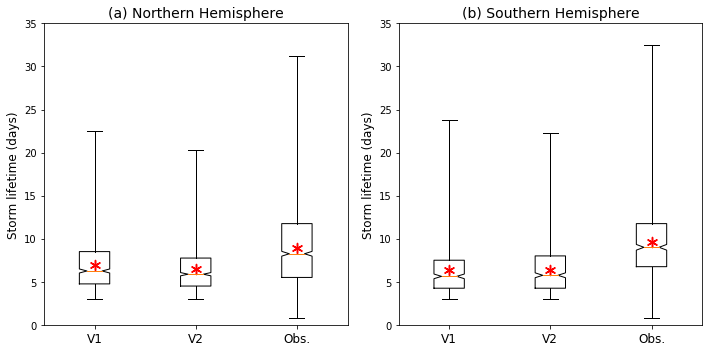

In [55]:
#Hemispheres version
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot([dict_lifetimes_v1['NH'], dict_lifetimes_v2['NH'], dict_lifetimes_IB['NH']], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([np.mean(dict_lifetimes_v1['NH']), np.mean(dict_lifetimes_v2['NH']), np.mean(dict_lifetimes_IB['NH'])]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylim([0,35])
plt.ylabel('Storm lifetime (days)', fontsize=12)
plt.title('(a) Northern Hemisphere', fontsize=14)


plt.subplot(1,2,2)
plt.boxplot([dict_lifetimes_v1['SH'], dict_lifetimes_v2['SH'], dict_lifetimes_IB['SH']], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([np.mean(dict_lifetimes_v1['SH']), np.mean(dict_lifetimes_v2['SH']), np.mean(dict_lifetimes_IB['SH'])]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylim([0,35])
plt.ylabel('Storm lifetime (days)', fontsize=12)
plt.title('(b) Southern Hemisphere', fontsize=14)

plt.tight_layout()

plt.savefig('plots/lifetimes_boxplots_hemispheres.png')
plt.savefig('plots/lifetimes_boxplots_hemispheres.pdf')

In [10]:

#####   MAX WIND AND MIN PRESSURE   #####


In [11]:
#Box plots here based on individual storm, not per year
#But for the lifetime max wind, not all winds

In [12]:
#How to calculate this? 
#Just max of wind, and min of presure, on storm dimension, 
#then can do box plots/histograms/PDFs.

In [13]:
#But: this only works globally or for hemispheres--how to figure out what region the max is in?
#Do you count the max within one region if it later shifts to another?
#How did Jeff do this?
#Only counted if it was the max for the whole storm.
#So I think I need to save the index of the max/min points using argmax/argmin, 
#and then identify the regions based on that.

In [14]:
#Actually, since Adam an Suzana say this should be done based on origin region, 
#it is indeed easy, just use the genesis region tags.

In [15]:
print(ds_tracks_v1['min_pressure'])
#Pressure for the Zhao TCs is in units of 100 hPa

<xarray.DataArray 'min_pressure' (storm: 987)>
array([9.81, 9.83, 9.85, ..., 9.71, 9.85, 9.87])
Coordinates:
  * storm    (storm) int64 0 1 2 3 4 5 6 7 8 9 ... 33 34 35 36 37 38 39 40 41 42


In [20]:
#Mask by origin region for regional boxplots
regional_max_wind_v1 = dict()
regional_max_wind_v2 = dict()
regional_max_wind_IB = dict()
regional_min_pressure_v1 = dict()
regional_min_pressure_v2 = dict()
regional_min_pressure_IB = dict()
for region in ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']:
    regional_max_wind_v1[region] = ds_tracks_v1['max_wind_kts'][ds_tracks_v1['gen_'+region]]
    regional_max_wind_v2[region] = ds_tracks_v2['max_wind_kts'][ds_tracks_v2['gen_'+region]]
    regional_max_wind_IB[region] = ds_tracks_IB['max_usa_wind'][ds_tracks_IB['gen_'+region]]
    regional_min_pressure_v1[region] = ds_tracks_v1['min_pressure'][ds_tracks_v1['gen_'+region]]
    regional_min_pressure_v2[region] = ds_tracks_v2['min_pressure'][ds_tracks_v2['gen_'+region]]
    regional_min_pressure_IB[region] = ds_tracks_IB['min_wmo_pres'][ds_tracks_IB['gen_'+region]]
    #print(len(regional_max_wind_v1[region])) #Totals look right--hemispheres add up to total



In [24]:
#print(regional_max_wind_v1)

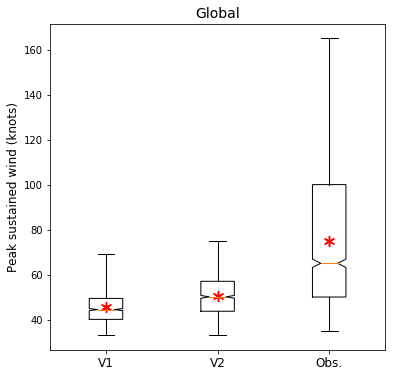

In [21]:
#Global plot: winds
plt.figure(figsize=(6,6))
plt.boxplot([ds_tracks_v1['max_wind_kts'].data, ds_tracks_v2['max_wind_kts'].data, ds_tracks_IB['max_usa_wind'].data], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([ds_tracks_v1['max_wind_kts'].mean(dim='storm').data, 
                      ds_tracks_v2['max_wind_kts'].mean(dim='storm').data, 
                      ds_tracks_IB['max_usa_wind'].mean(dim='storm').data]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylabel('Peak sustained wind (knots)', fontsize=12)
plt.title('Global', fontsize=14)

plt.savefig('plots/distribution_boxplot_peakwinds_global.pdf')
plt.savefig('plots/distribution_boxplot_peakwinds_global.png')

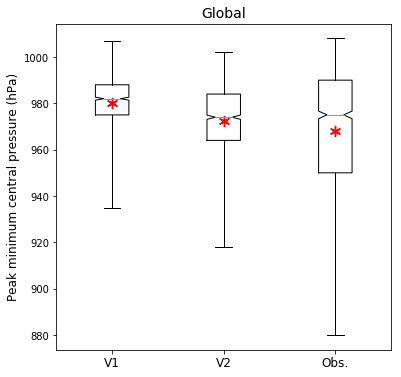

In [22]:
#Global plot: pressure
#(Eliminate any nans from the observations, where wmo_pres was blank for the storm)
plt.figure(figsize=(6,6))
plt.boxplot([ds_tracks_v1['min_pressure'].data*100, ds_tracks_v2['min_pressure'].data*100, 
             ds_tracks_IB['min_wmo_pres'].data[np.logical_not(np.isnan(ds_tracks_IB['min_wmo_pres'].data))]], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([ds_tracks_v1['min_pressure'].mean(dim='storm').data*100, 
                      ds_tracks_v2['min_pressure'].mean(dim='storm').data*100, 
                      ds_tracks_IB['min_wmo_pres'].mean(dim='storm').data]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylabel('Peak minimum central pressure (hPa)', fontsize=12)
plt.title('Global', fontsize=14)

#Why is it missing for obs.?
#Did one nan spoil the distribution? 
#What happened to usa_pres?


plt.savefig('plots/distribution_boxplot_peakpressure_global.pdf')
plt.savefig('plots/distribution_boxplot_peakpressure_global.png')

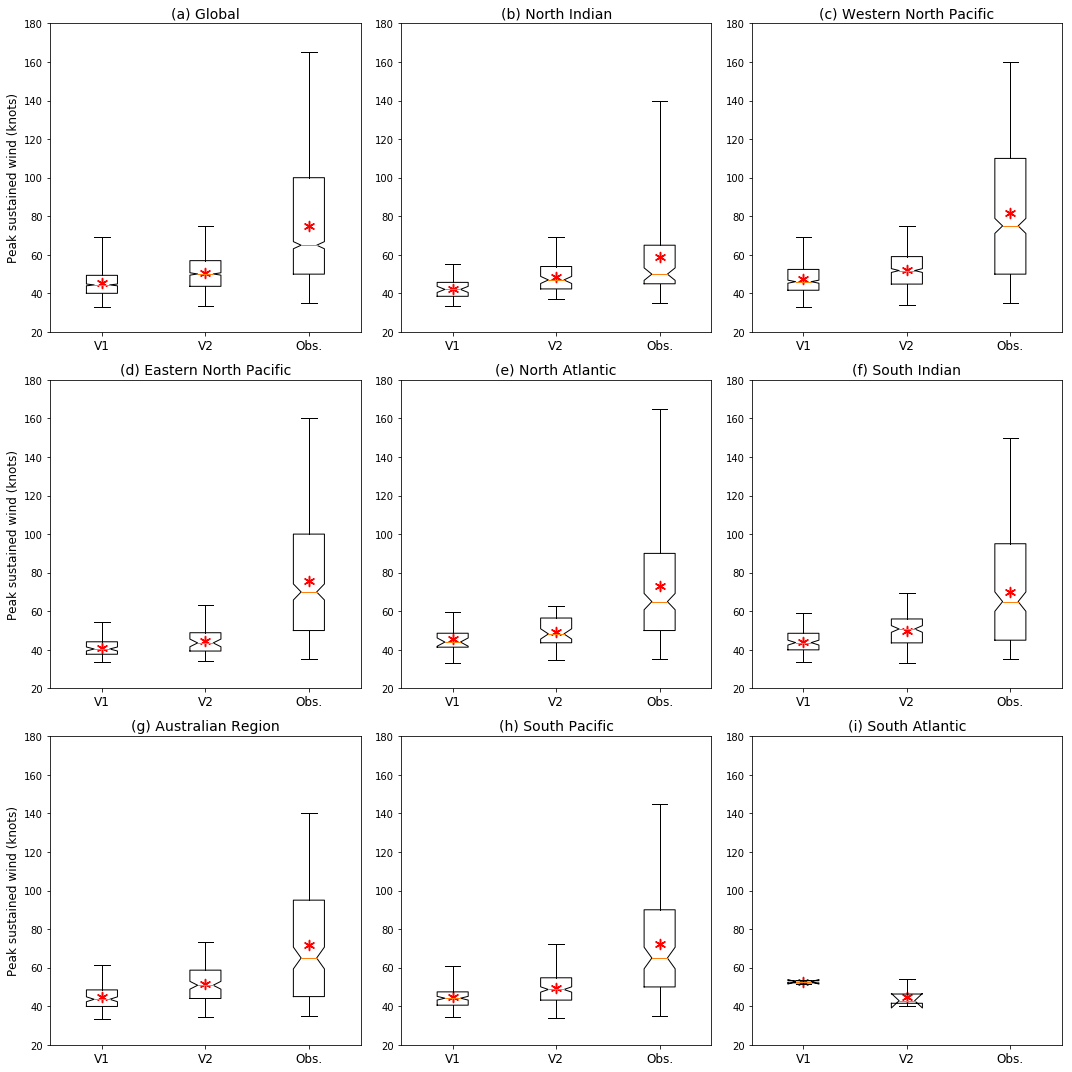

In [26]:
#Regional plots (9 panels): Wind
plt.figure(figsize=((15,15)))
plt.subplot(3,3,1)
plt.boxplot([ds_tracks_v1['max_wind_kts'].data, 
             ds_tracks_v2['max_wind_kts'].data, 
             ds_tracks_IB['max_usa_wind'].data], 
            notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([ds_tracks_v1['max_wind_kts'].mean(dim='storm').data, 
                      ds_tracks_v2['max_wind_kts'].mean(dim='storm').data, 
                      ds_tracks_IB['max_usa_wind'].mean(dim='storm').data]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylim([20,180])
plt.ylabel('Peak sustained wind (knots)', fontsize=12)
plt.title('(a) Global', fontsize=14)

regions = ['NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
region_names = {'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters = {0: 'b', 
           1: 'c', 
           2: 'd', 
           3: 'e', 
           4: 'f', 
           5: 'g', 
           6: 'h', 
           7: 'i'}
for i in np.arange(8):
    plt.subplot(3,3,i+2)
    region = regions[i]
    plt.boxplot([regional_max_wind_v1[region].data, 
                 regional_max_wind_v2[region].data, 
                 regional_max_wind_IB[region].data], 
                notch=True, whis=(0,100))
    plt.scatter(np.array([1.,2.,3.]), 
                np.array(np.array([np.mean(regional_max_wind_v1[region]), 
                                   np.mean(regional_max_wind_v2[region]), 
                                   np.mean(regional_max_wind_IB[region])])), 
                marker=(6,2), c='red', s=100)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
    plt.ylim([20,180])
    if i in [2,5]:
        plt.ylabel('Peak sustained wind (knots)', fontsize=12)
    plt.title('('+letters[i]+') ' +region_names[region], fontsize=14)
plt.tight_layout()

plt.savefig('plots/distribution_boxplot_peakwind_regions.png')
plt.savefig('plots/distribution_boxplot_peakwind_regions.pdf')

In [ ]:
#Hemispheric plots
#(Don't bother for now; very similar for lifetime)

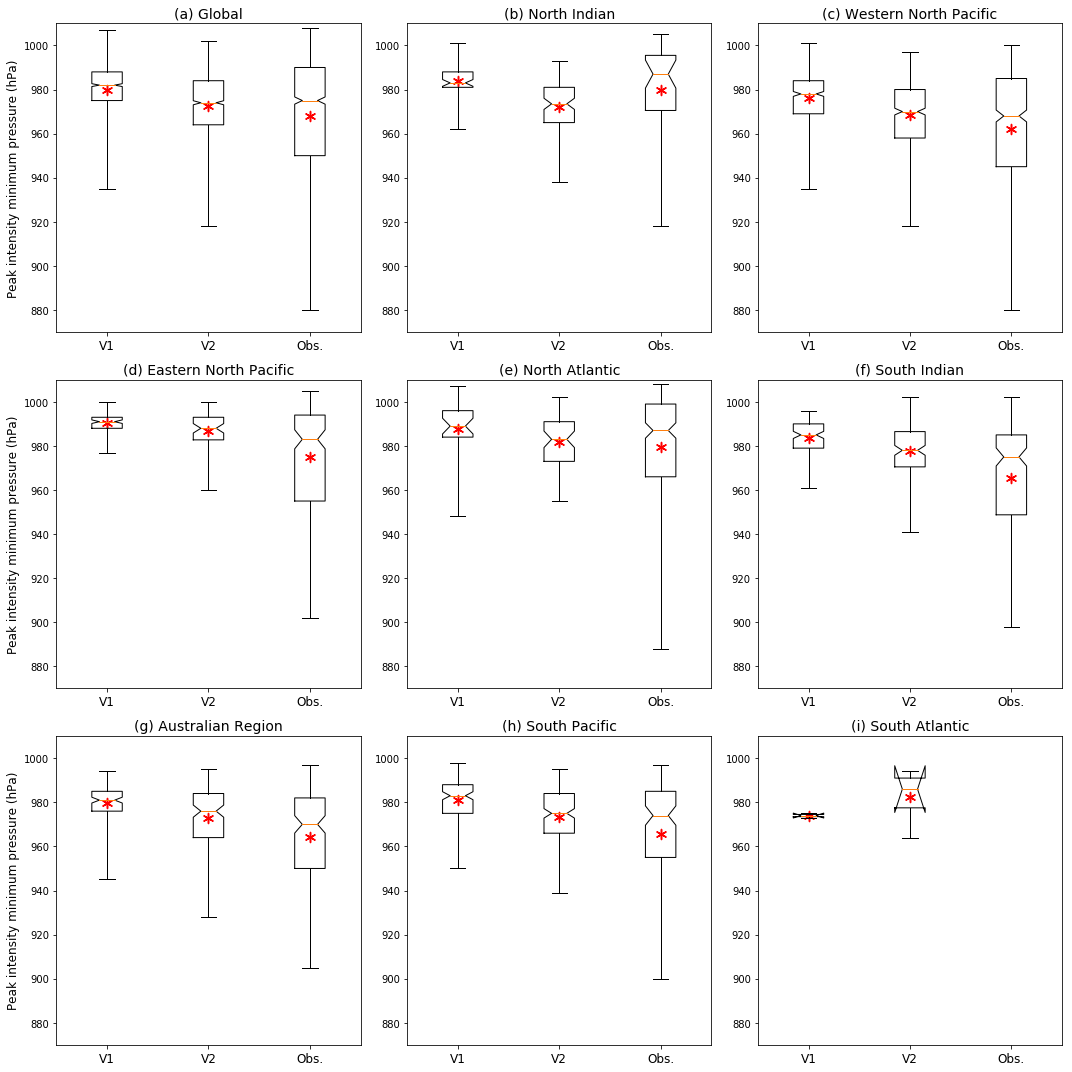

In [41]:
#Pressure
plt.figure(figsize=((15,15)))
plt.subplot(3,3,1)
plt.boxplot([ds_tracks_v1['min_pressure'].data*100, 
             ds_tracks_v2['min_pressure'].data*100, 
             ds_tracks_IB['min_wmo_pres'].data[np.logical_not(np.isnan(ds_tracks_IB['min_wmo_pres'].data))]], 
            notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([ds_tracks_v1['min_pressure'].mean(dim='storm').data*100, 
                      ds_tracks_v2['min_pressure'].mean(dim='storm').data*100, 
                      ds_tracks_IB['min_wmo_pres'].mean(dim='storm')]),  
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylim([870, 1010])
plt.ylabel('Peak intensity minimum pressure (hPa)', fontsize=12)
plt.title('(a) Global', fontsize=14)

regions = ['NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
region_names = {'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters = {0: 'b', 
           1: 'c', 
           2: 'd', 
           3: 'e', 
           4: 'f', 
           5: 'g', 
           6: 'h', 
           7: 'i'}
for i in np.arange(8):
    plt.subplot(3,3,i+2)
    region = regions[i]
    plt.boxplot([regional_min_pressure_v1[region].data*100, 
                 regional_min_pressure_v2[region].data*100, 
                 regional_min_pressure_IB[region].data[np.logical_not(np.isnan(regional_min_pressure_IB[region]))]], 
                notch=True, whis=(0,100))
    plt.scatter(np.array([1.,2.,3.]), 
                np.array([np.mean(regional_min_pressure_v1[region]*100), 
                                   np.mean(regional_min_pressure_v2[region]*100), 
                                   np.mean(regional_min_pressure_IB[region])]), 
                marker=(6,2), c='red', s=100)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
    plt.ylim([870, 1010])
    if i in [2,5]:
        plt.ylabel('Peak intensity minimum pressure (hPa)', fontsize=12)
    plt.title('('+letters[i]+') ' +region_names[region], fontsize=14)
plt.tight_layout()

plt.savefig('plots/distribution_boxplot_peakpressure_regions.png')
plt.savefig('plots/distribution_boxplot_peakpressure_regions.pdf')

In [32]:
np.mean(regional_min_pressure_IB['NH'])

<xarray.DataArray 'min_wmo_pres' ()>
array(969.188, dtype=float32)

In [13]:


#####   WIND-PRESSURE RELATIONSHIP   #####



In [14]:
#How to do this one? How did Jeff do it? 
#It's just a scatter plot...
#(Plus some sort of regression fit--refer to literature on what degree polynomials)
#Don't bother with regions, don't expect it to differ.

In [15]:
#For observations might have issues where don't have wind & pressure simultaneously always. 
#But that's well known anyway, just refer to literature.

In [16]:
#Jeff superimposed "all data" (blue) and "peak intensity" (red)--but how is peak defined? By pressure or wind?
#Looks like a job for argmin/argmax

In [17]:
#Kim et al. (2018) did a power function fit (fig. 2) and with wind speed on x-axis.
#There were relationships based on observations that were superimposed--I could do this without worrying about obs. for now.

In [18]:
#Obtain all the non-nan data points for model results
wind_flat_v1 = ds_tracks_v1['wind_kts'].data.flatten()
wind_flat_nonan_v1 = wind_flat_v1[np.logical_not(np.isnan(wind_flat_v1))]


pressure_flat_v1 = ds_tracks_v1['pressure'].data.flatten()
pressure_flat_nonan_v1 = pressure_flat_v1[np.logical_not(np.isnan(pressure_flat_v1))]

#Check that lengths are the same for wind and pressure #Yes
print(len(wind_flat_nonan_v1))
print(len(pressure_flat_nonan_v1))


26555
26555


In [19]:

wind_flat_v2 = ds_tracks_v2['wind_kts'].data.flatten()
wind_flat_nonan_v2 = wind_flat_v2[np.logical_not(np.isnan(wind_flat_v2))]


pressure_flat_v2 = ds_tracks_v2['pressure'].data.flatten()
pressure_flat_nonan_v2 = pressure_flat_v2[np.logical_not(np.isnan(pressure_flat_v2))]

#Check that lengths are the same for wind and pressure #Yes
print(len(wind_flat_nonan_v2))
print(len(pressure_flat_nonan_v2))


29908
29908


In [20]:
#For peak intensity subset: obtain the corresponding pressures
pres_max_wind_v1 = np.zeros(len(ds_tracks_v1['argmax_wind_kts']))
for i in np.arange(len(pres_max_wind_v1)):
    pres_max_wind_v1[i] = ds_tracks_v1['pressure'].isel(storm=i, date_time=ds_tracks_v1['argmax_wind_kts'][i])

In [21]:
pres_max_wind_v2 = np.zeros(len(ds_tracks_v2['argmax_wind_kts']))
for i in np.arange(len(pres_max_wind_v2)):
    pres_max_wind_v2[i] = ds_tracks_v2['pressure'].isel(storm=i, date_time=ds_tracks_v2['argmax_wind_kts'][i])

In [22]:
#Fits
#Note that these fits have typically been done based on wind in knots (as with wind-pressure relationship)

#Simple linear fit

#Quadratic fit?

#Power law fit


In [23]:
#Power law requires scipy.optimize.curve_fit with custom-designed function that is input.

#Function for the power law
def power_f_1010(x, a, b):
    return a*np.power((1010.-x), b)

#Trying the version without the 1010-x
def power_f(x,a,b):
    return a*np.power(x,b)

In [24]:
#for element in wind_flat_nonan_v1:
#    print(element)
#print(np.sum(np.isnan(wind_flat_nonan_v1)))
#print(np.sum(np.isnan(pressure_flat_nonan_v1)))
#No nans! Why am I getting errors?

In [25]:
# print(power_f(1010.-pressure_flat_nonan_v1*100., 2.3, 0.76))
# print(np.max(power_f(1010.-pressure_flat_nonan_v1*100., 2.3, 0.76))) #nan
# #How do nans appear here?
# print(np.max(1010.-pressure_flat_nonan_v1*100.)) #75.0

# print(np.max(np.power(1010.-pressure_flat_nonan_v1*100., 2)))
# print(np.max(np.power(1010.-pressure_flat_nonan_v1*100., 0.5)))

# #OK, seems like the problem is that some pressures are greater than 1010 so taking roots of them leads to nans. 
# #How to deal with this? Just exclude these points? But could introduce a bias
#Or: use the power law relationship using just the peak intensities. Without an intercept, this should be the same as a fit using all of them.

In [26]:
#Calculate the fits (in knots units)
#Getting invalid value encountered in power warning and covariance could not be estimated warning. 
#Try initial guess based on the KZ07 observation-derived fit.
#coeffs_v1_all, pcov_v1_all = curve_fit(power_f_1010, pressure_flat_nonan_v1*100., wind_flat_nonan_v1/1.94384, bounds=(0.01,100), p0=[2.3,0.76]) 
#coeffs_v1_all, pcov_v1_all = curve_fit(power_f, 1010.-pressure_flat_nonan_v1*100., wind_flat_nonan_v1/1.94384, bounds=([1,0],[20,1]), p0=[2.3,0.76]) 
#coeffs_v1_all, pcov_v1_all = curve_fit(power_f, 1010.-pressure_flat_nonan_v1*100., wind_flat_nonan_v1, bounds=([-1,0.1],[20,1])) 
#This isn't working due to complex numbers when pressure > 1010. But should work for peak intensities.

coeffs_v1_peak, pcov_v1_peak = curve_fit(power_f_1010, pres_max_wind_v1*100., ds_tracks_v1['max_wind_kts'].data) 
print(coeffs_v1_peak)
print(pcov_v1_peak)

[16.90402649  0.30321312]
[[ 2.16177146e-01 -3.79358559e-03]
 [-3.79358559e-03  6.74549138e-05]]


In [27]:
coeffs_v2_peak, pcov_v2_peak = curve_fit(power_f_1010, pres_max_wind_v2*100., ds_tracks_v2['max_wind_kts'].data) 
print(coeffs_v2_peak)
print(pcov_v2_peak)

[15.15724483  0.34452378]
[[ 1.39424123e-01 -2.52855259e-03]
 [-2.52855259e-03  4.64538021e-05]]


In [28]:
#For fit to all points: just cut off any points > 1010--high pressure for the tropics anyway.

pressure_cutoff_v1 = pressure_flat_nonan_v1[pressure_flat_nonan_v1<=10.10]
wind_cutoff_v1 = wind_flat_nonan_v1[pressure_flat_nonan_v1<=10.10]
print(len(pressure_cutoff_v1))
print(len(wind_cutoff_v1))

26539
26539


In [29]:
pressure_cutoff_v2 = pressure_flat_nonan_v2[pressure_flat_nonan_v2<=10.10]
wind_cutoff_v2 = wind_flat_nonan_v2[pressure_flat_nonan_v2<=10.10]
print(len(pressure_cutoff_v2))
print(len(wind_cutoff_v2))

29886
29886


In [30]:
coeffs_v1_all, pcov_v1_all = curve_fit(power_f_1010, pressure_cutoff_v1*100., wind_cutoff_v1) 
print(coeffs_v1_all)
print(pcov_v1_all)

[13.56941241  0.33173611]
[[ 6.31170113e-03 -1.44304921e-04]
 [-1.44304921e-04  3.36423207e-06]]


In [31]:
coeffs_v2_all, pcov_v2_all = curve_fit(power_f_1010, pressure_cutoff_v2*100., wind_cutoff_v2) 
print(coeffs_v2_all)
print(pcov_v2_all)

[11.87084746  0.38305297]
[[ 4.13755800e-03 -1.00675487e-04]
 [-1.00675487e-04  2.49682930e-06]]


In [32]:
#Power law fit from the observations--two versions following Kim et al. 2018
#For wind in m/s, SLP in hPa
#References: Atkinson and Holliday (1977), Knaff and Zehr (2007)
def fit_obs_AH77(mslp):
    v = 3.5*np.power((1010-mslp), 0.64)
    return v

def fit_obs_KZ07(mslp):
    v = 2.3*np.power((1010-mslp), 0.76)
    return v

In [33]:
#For legend--coefficients of observed relationships but for knots
print(3.5*1.94384)
print(2.3*1.94384)

6.80344
4.470832


In [34]:
#For the observations: all points, flattened. (Don't get rid of nans because might not line up)

wind_flat_IB = ds_tracks_IB['usa_wind'].data.flatten()
pres_flat_IB = ds_tracks_IB['wmo_pres'].data.flatten()


/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


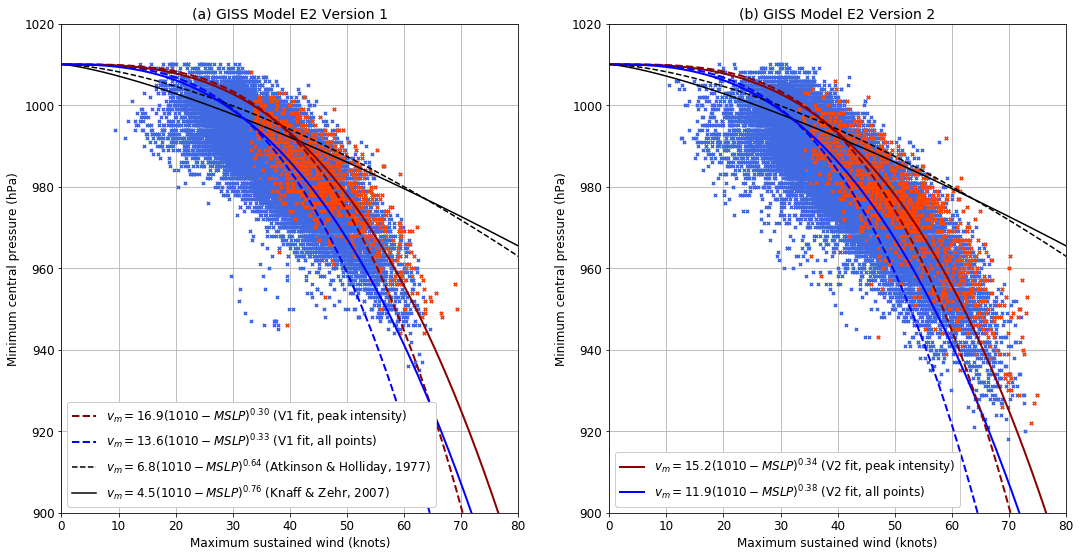

In [59]:
#Scatter Plots: v1 and v2 (subplots)
#Should redo the labels with string formatting for ending in 0.
#Also reproduce v1 on v2 as thin dashed lines and vice versa.

plt.figure(figsize=(18,9))

#v1
plt.subplot(1,2,1)
plt.scatter(wind_cutoff_v1, pressure_cutoff_v1*100, s=10, c='royalblue', marker='x') #All points
plt.scatter(ds_tracks_v1['max_wind_kts'], pres_max_wind_v1*100, s=10, c='orangered', marker='x') #At peak intensity (by wind)
plt.xlabel('Maximum sustained wind (knots)', fontsize=12)
plt.ylabel('Minimum central pressure (hPa)', fontsize=12)
plt.gca().tick_params(labelsize=12)
plt.title('(a) GISS Model E2 Version 1', fontsize=14)
plt.axis([0,80,900,1020])
plt.gca().set_axisbelow(True)
plt.grid()
#Plot the fitted relationship
y_fit = np.arange(1200)/10.+900
plt.plot(power_f_1010(y_fit, coeffs_v1_peak[0], coeffs_v1_peak[1]), y_fit, 'darkred', linewidth=2, linestyle='dashed')
plt.plot(power_f_1010(y_fit, coeffs_v1_all[0], coeffs_v1_all[1]), y_fit, 'blue', linewidth=2, linestyle='dashed')
#Plot the observed relationships
plt.plot(fit_obs_AH77(y_fit)*1.94384, y_fit, 'k', linestyle='dashed')
plt.plot(fit_obs_KZ07(y_fit)*1.94384, y_fit, 'k')
#v2 superimposed
plt.plot(power_f_1010(y_fit, coeffs_v2_peak[0], coeffs_v2_peak[1]), y_fit, 'darkred', linewidth=2)
plt.plot(power_f_1010(y_fit, coeffs_v2_all[0], coeffs_v2_all[1]), y_fit, 'blue', linewidth=2)
#Legend: show the equations and sources
plt.legend([r'$v_m='+'{:.1f}'.format(coeffs_v1_peak[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v1_peak[1])+'}$ (V1 fit, peak intensity)', 
            r'$v_m='+'{:.1f}'.format(coeffs_v1_all[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v1_all[1])+'}$ (V1 fit, all points)',
            r'$v_m=6.8(1010-MSLP)^{0.64}$ (Atkinson & Holliday, 1977)', 
            r'$v_m=4.5(1010-MSLP)^{0.76}$ (Knaff & Zehr, 2007)' ], 
          framealpha=1, fontsize=12)


plt.subplot(1,2,2)
plt.scatter(wind_cutoff_v2, pressure_cutoff_v2*100, s=10, c='royalblue', marker='x') #All points
plt.scatter(ds_tracks_v2['max_wind_kts'], pres_max_wind_v2*100, s=10, c='orangered', marker='x') #At peak intensity (by wind)
plt.xlabel('Maximum sustained wind (knots)', fontsize=12)
plt.ylabel('Minimum central pressure (hPa)', fontsize=12)
plt.gca().tick_params(labelsize=12)
plt.title('(b) GISS Model E2 Version 2', fontsize=14)
plt.axis([0,80,900,1020])
plt.gca().set_axisbelow(True)
plt.grid()
#Plot the fitted relationship
y_fit = np.arange(1200)/10.+900
plt.plot(power_f_1010(y_fit, coeffs_v2_peak[0], coeffs_v2_peak[1]), y_fit, 'darkred', linewidth=2)
plt.plot(power_f_1010(y_fit, coeffs_v2_all[0], coeffs_v2_all[1]), y_fit, 'blue', linewidth=2)
#Plot the observed relationships
plt.plot(fit_obs_AH77(y_fit)*1.94384, y_fit, 'k', linestyle='dashed')
plt.plot(fit_obs_KZ07(y_fit)*1.94384, y_fit, 'k')
#v1 superimposed, dashed
plt.plot(power_f_1010(y_fit, coeffs_v1_peak[0], coeffs_v1_peak[1]), y_fit, 'darkred', linewidth=2, linestyle='dashed')
plt.plot(power_f_1010(y_fit, coeffs_v1_all[0], coeffs_v1_all[1]), y_fit, 'blue', linewidth=2, linestyle='dashed')
plt.legend([r'$v_m='+'{:.1f}'.format(coeffs_v2_peak[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v2_peak[1])+'}$ (V2 fit, peak intensity)', 
            r'$v_m='+'{:.1f}'.format(coeffs_v2_all[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v2_all[1])+'}$ (V2 fit, all points)'],          
            framealpha=1, fontsize=12)

plt.savefig('plots/wind_pressure_relationship_power_fits.png')

In [ ]:
#Looks good, but peak intensity also biases the fit by not including the weakest storms in the relationship...
#But, it seems like there must have been a threshold of 1010 hPa and 34 knots in order for the storms to be counted, or it wouldn't look like this.

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


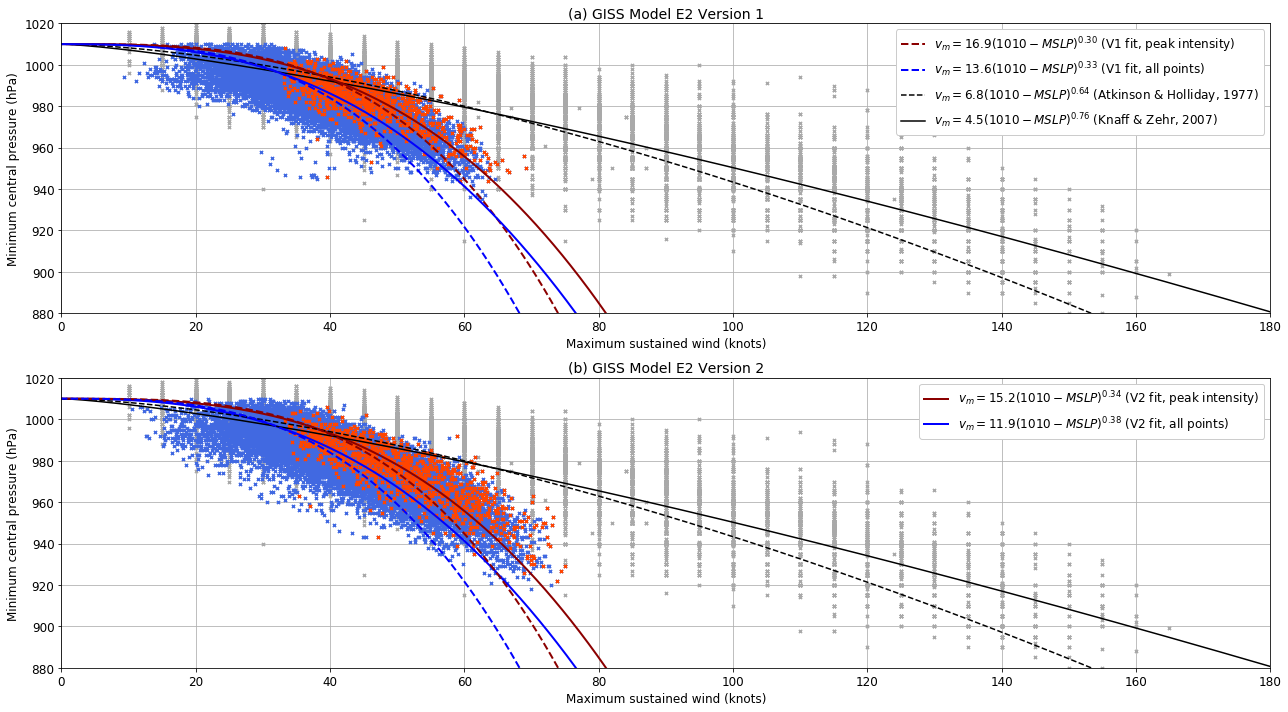

In [64]:
#Version with observations plotted; wider to show higher winds--top and bottom panels
plt.figure(figsize=(18,10))

#v1
plt.subplot(2,1,1)
plt.scatter(wind_flat_IB, pres_flat_IB, s=10,c='darkgrey', marker='x') #Observations (all points)
plt.scatter(wind_cutoff_v1, pressure_cutoff_v1*100, s=10, c='royalblue', marker='x') #All points
plt.scatter(ds_tracks_v1['max_wind_kts'], pres_max_wind_v1*100, s=10, c='orangered', marker='x') #At peak intensity (by wind)
plt.xlabel('Maximum sustained wind (knots)', fontsize=12)
plt.ylabel('Minimum central pressure (hPa)', fontsize=12)
plt.gca().tick_params(labelsize=12)
plt.title('(a) GISS Model E2 Version 1', fontsize=14)
plt.axis([0,180,880,1020])
plt.gca().set_axisbelow(True)
plt.grid()
#Plot the fitted relationship
y_fit = np.arange(1400)/10.+880
plt.plot(power_f_1010(y_fit, coeffs_v1_peak[0], coeffs_v1_peak[1]), y_fit, 'darkred', linewidth=2, linestyle='dashed')
plt.plot(power_f_1010(y_fit, coeffs_v1_all[0], coeffs_v1_all[1]), y_fit, 'blue', linewidth=2, linestyle='dashed')
#Plot the observed relationships
plt.plot(fit_obs_AH77(y_fit)*1.94384, y_fit, 'k', linestyle='dashed')
plt.plot(fit_obs_KZ07(y_fit)*1.94384, y_fit, 'k')
#v2 superimposed
plt.plot(power_f_1010(y_fit, coeffs_v2_peak[0], coeffs_v2_peak[1]), y_fit, 'darkred', linewidth=2)
plt.plot(power_f_1010(y_fit, coeffs_v2_all[0], coeffs_v2_all[1]), y_fit, 'blue', linewidth=2)
#Legend: show the equations and sources
plt.legend([r'$v_m='+'{:.1f}'.format(coeffs_v1_peak[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v1_peak[1])+'}$ (V1 fit, peak intensity)', 
            r'$v_m='+'{:.1f}'.format(coeffs_v1_all[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v1_all[1])+'}$ (V1 fit, all points)',
            r'$v_m=6.8(1010-MSLP)^{0.64}$ (Atkinson & Holliday, 1977)', 
            r'$v_m=4.5(1010-MSLP)^{0.76}$ (Knaff & Zehr, 2007)' ], 
          framealpha=1, fontsize=12)


plt.subplot(2,1,2)
plt.scatter(wind_flat_IB, pres_flat_IB, s=10,c='darkgrey', marker='x') #Observations (all points)
plt.scatter(wind_cutoff_v2, pressure_cutoff_v2*100, s=10, c='royalblue', marker='x') #All points
plt.scatter(ds_tracks_v2['max_wind_kts'], pres_max_wind_v2*100, s=10, c='orangered', marker='x') #At peak intensity (by wind)
plt.xlabel('Maximum sustained wind (knots)', fontsize=12)
plt.ylabel('Minimum central pressure (hPa)', fontsize=12)
plt.gca().tick_params(labelsize=12)
plt.title('(b) GISS Model E2 Version 2', fontsize=14)
plt.axis([0,180,880,1020])
plt.gca().set_axisbelow(True)
plt.grid()
#Plot the fitted relationship
y_fit = np.arange(1400)/10.+880
plt.plot(power_f_1010(y_fit, coeffs_v2_peak[0], coeffs_v2_peak[1]), y_fit, 'darkred', linewidth=2)
plt.plot(power_f_1010(y_fit, coeffs_v2_all[0], coeffs_v2_all[1]), y_fit, 'blue', linewidth=2)
#Plot the observed relationships
plt.plot(fit_obs_AH77(y_fit)*1.94384, y_fit, 'k', linestyle='dashed')
plt.plot(fit_obs_KZ07(y_fit)*1.94384, y_fit, 'k')
#v1 superimposed, dashed
plt.plot(power_f_1010(y_fit, coeffs_v1_peak[0], coeffs_v1_peak[1]), y_fit, 'darkred', linewidth=2, linestyle='dashed')
plt.plot(power_f_1010(y_fit, coeffs_v1_all[0], coeffs_v1_all[1]), y_fit, 'blue', linewidth=2, linestyle='dashed')
plt.legend([r'$v_m='+'{:.1f}'.format(coeffs_v2_peak[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v2_peak[1])+'}$ (V2 fit, peak intensity)', 
            r'$v_m='+'{:.1f}'.format(coeffs_v2_all[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v2_all[1])+'}$ (V2 fit, all points)'],          
            framealpha=1, fontsize=12)

plt.tight_layout()

plt.savefig('plots/wind_pressure_relationship_power_fits_wide_obs.png')

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: inv

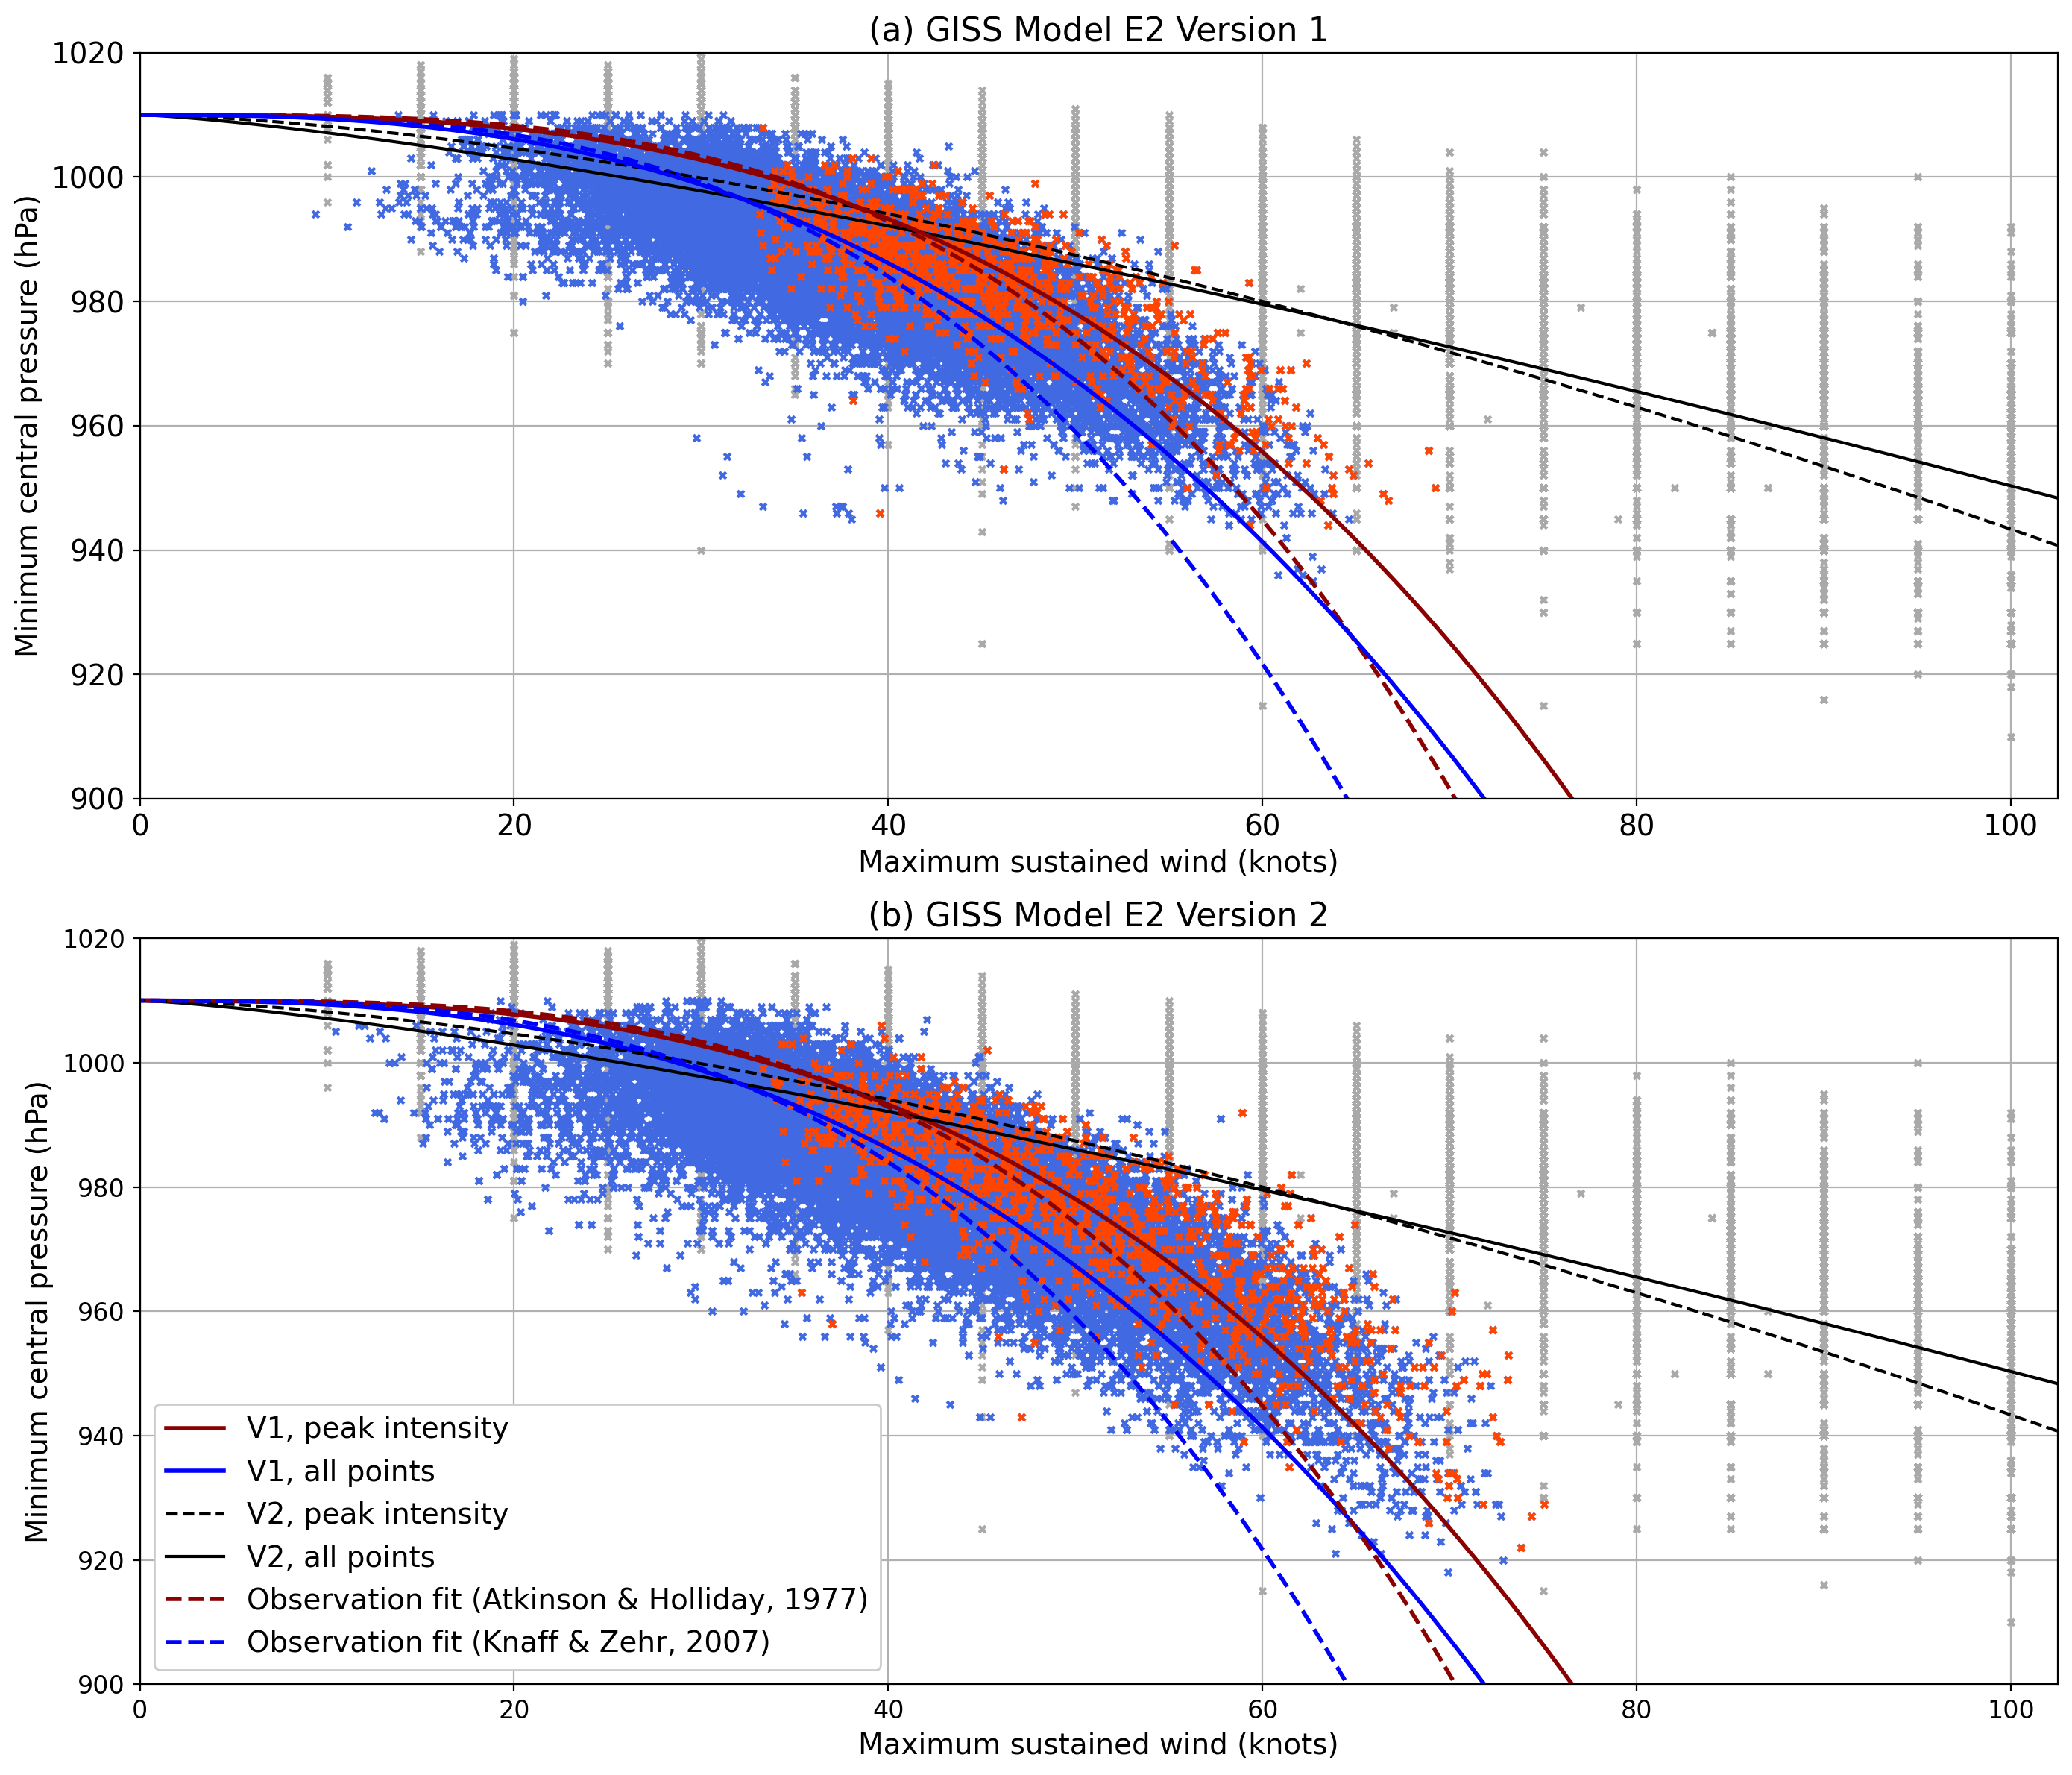

In [42]:
#Version like above but cut off at 100 knots; 
#more legible (i.e. equations out of legend, bigger text)

#Version with observations plotted; wider to show higher winds--top and bottom panels
plt.figure(figsize=(14,12), dpi=200)

#v1
plt.subplot(2,1,1)
plt.scatter(wind_flat_IB, pres_flat_IB, s=10,c='darkgrey', marker='x') #Observations (all points)
plt.scatter(wind_cutoff_v1, pressure_cutoff_v1*100, s=10, c='royalblue', marker='x') #All points
plt.scatter(ds_tracks_v1['max_wind_kts'], pres_max_wind_v1*100,
            s=10, c='orangered', marker='x') #At peak intensity (by wind)
plt.xlabel('Maximum sustained wind (knots)', fontsize=14)
plt.ylabel('Minimum central pressure (hPa)', fontsize=14)
plt.gca().tick_params(labelsize=14)
plt.title('(a) GISS Model E2 Version 1', fontsize=16)
plt.axis([0,102.5,900,1020])
plt.gca().set_axisbelow(True)
plt.grid()
#Plot the fitted relationship
y_fit = np.arange(1400)/10.+880
plt.plot(power_f_1010(y_fit, coeffs_v1_peak[0], coeffs_v1_peak[1]), y_fit, 
         'darkred', linewidth=2, linestyle='dashed')
plt.plot(power_f_1010(y_fit, coeffs_v1_all[0], coeffs_v1_all[1]), y_fit, 
         'blue', linewidth=2, linestyle='dashed')
#Plot the observed relationships
plt.plot(fit_obs_AH77(y_fit)*1.94384, y_fit, 'k', linestyle='dashed')
plt.plot(fit_obs_KZ07(y_fit)*1.94384, y_fit, 'k')
#v2 superimposed
plt.plot(power_f_1010(y_fit, coeffs_v2_peak[0], coeffs_v2_peak[1]), y_fit, 
         'darkred', linewidth=2)
plt.plot(power_f_1010(y_fit, coeffs_v2_all[0], coeffs_v2_all[1]), y_fit, 
         'blue', linewidth=2)


plt.subplot(2,1,2)
plt.scatter(wind_flat_IB, pres_flat_IB, s=10,c='darkgrey', marker='x') #Observations (all points)
plt.scatter(wind_cutoff_v2, pressure_cutoff_v2*100, s=10, c='royalblue', marker='x') #All points
plt.scatter(ds_tracks_v2['max_wind_kts'], pres_max_wind_v2*100, 
            s=10, c='orangered', marker='x') #At peak intensity (by wind)
plt.xlabel('Maximum sustained wind (knots)', fontsize=14)
plt.ylabel('Minimum central pressure (hPa)', fontsize=14)
plt.gca().tick_params(labelsize=12)
plt.title('(b) GISS Model E2 Version 2', fontsize=16)
plt.axis([0,102.5,900,1020])
plt.gca().set_axisbelow(True)
plt.grid()
#Plot the fitted relationship
y_fit = np.arange(1400)/10.+880
plt.plot(power_f_1010(y_fit, coeffs_v2_peak[0], coeffs_v2_peak[1]), y_fit, 
         'darkred', linewidth=2)
plt.plot(power_f_1010(y_fit, coeffs_v2_all[0], coeffs_v2_all[1]), y_fit, 
         'blue', linewidth=2)
#Plot the observed relationships
plt.plot(fit_obs_AH77(y_fit)*1.94384, y_fit, 'k', linestyle='dashed')
plt.plot(fit_obs_KZ07(y_fit)*1.94384, y_fit, 'k')
#v1 superimposed, dashed
plt.plot(power_f_1010(y_fit, coeffs_v1_peak[0], coeffs_v1_peak[1]), y_fit, 
         'darkred', linewidth=2, linestyle='dashed')
plt.plot(power_f_1010(y_fit, coeffs_v1_all[0], coeffs_v1_all[1]), y_fit, 
         'blue', linewidth=2, linestyle='dashed')
plt.legend([r'V1, peak intensity', 
            r'V1, all points',
            r'V2, peak intensity', 
            r'V2, all points',
            r'Observation fit (Atkinson & Holliday, 1977)', 
            r'Observation fit (Knaff & Zehr, 2007)'
           ],          
            framealpha=1, fontsize=14, loc='lower left')

plt.tight_layout()

plt.savefig('plots/wind_pressure_relationship_power_fits_obs_100kt.png')

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: inv

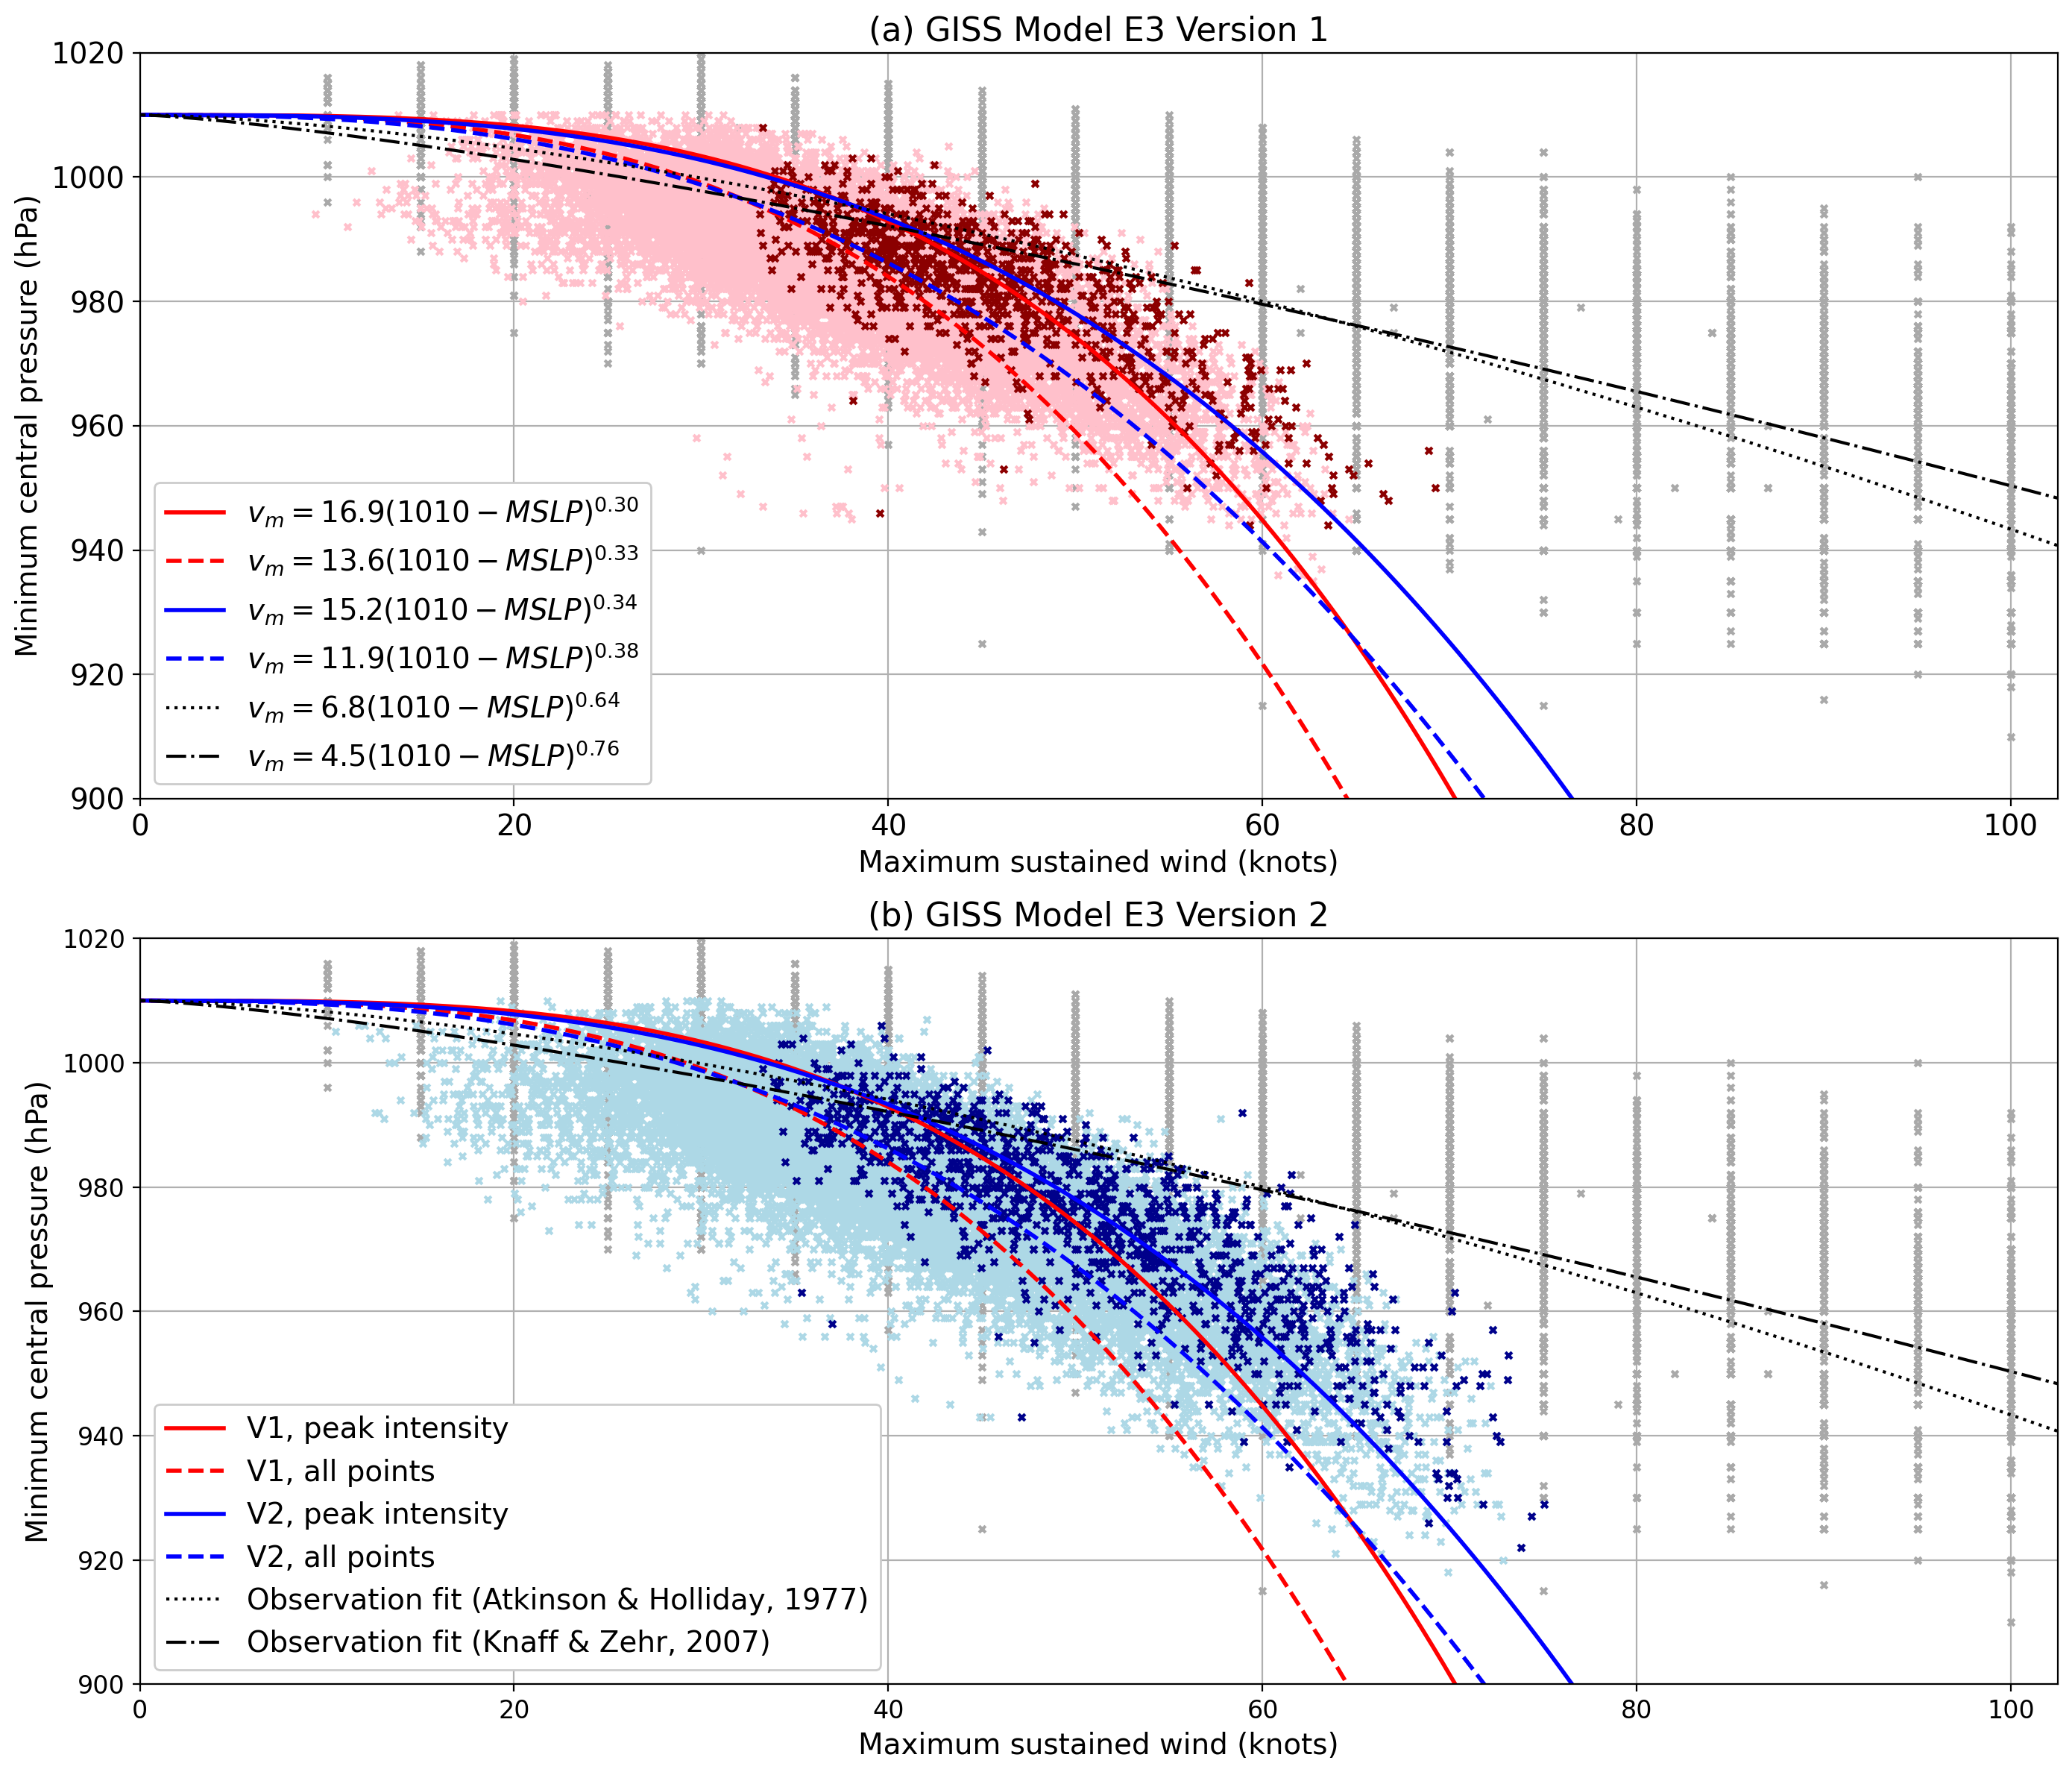

In [36]:
#Version with corrected title (E3), and colors consistent with rest of paper (red V1, blue V2, darker for peak)
#4-16-20: changing line styles for the obs.

plt.figure(figsize=(14,12), dpi=200)

#v1
plt.subplot(2,1,1)
plt.scatter(wind_flat_IB, pres_flat_IB, s=10,c='darkgrey', marker='x') #Observations (all points)
plt.scatter(wind_cutoff_v1, pressure_cutoff_v1*100, s=10, c='pink', marker='x') #All points
plt.scatter(ds_tracks_v1['max_wind_kts'], pres_max_wind_v1*100,
            s=10, c='darkred', marker='x') #At peak intensity (by wind)
plt.xlabel('Maximum sustained wind (knots)', fontsize=14)
plt.ylabel('Minimum central pressure (hPa)', fontsize=14)
plt.gca().tick_params(labelsize=14)
plt.title('(a) GISS Model E3 Version 1', fontsize=16)
plt.axis([0,102.5,900,1020])
plt.gca().set_axisbelow(True)
plt.grid()
#Plot the fitted relationship (V1)
y_fit = np.arange(1400)/10.+880
plt.plot(power_f_1010(y_fit, coeffs_v1_peak[0], coeffs_v1_peak[1]), y_fit, 
         color='red', linewidth=2, linestyle='solid')
plt.plot(power_f_1010(y_fit, coeffs_v1_all[0], coeffs_v1_all[1]), y_fit, 
         color='red', linewidth=2, linestyle='dashed')
#v2 superimposed
plt.plot(power_f_1010(y_fit, coeffs_v2_peak[0], coeffs_v2_peak[1]), y_fit, 
         'blue', linewidth=2, linestyle='solid')
plt.plot(power_f_1010(y_fit, coeffs_v2_all[0], coeffs_v2_all[1]), y_fit, 
         'blue', linewidth=2, linestyle='dashed')
#Plot the observed relationships
plt.plot(fit_obs_AH77(y_fit)*1.94384, y_fit, 'k', linestyle='dotted')
plt.plot(fit_obs_KZ07(y_fit)*1.94384, y_fit, 'k', linestyle='dashdot')

#Legesnd with fit equations
plt.legend([r'$v_m='+'{:.1f}'.format(coeffs_v1_peak[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v1_peak[1])+'}$', 
            r'$v_m='+'{:.1f}'.format(coeffs_v1_all[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v1_all[1])+'}$', 
            r'$v_m='+'{:.1f}'.format(coeffs_v2_peak[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v2_peak[1])+'}$', 
            r'$v_m='+'{:.1f}'.format(coeffs_v2_all[0])+'(1010-MSLP)^{'+'{:.2f}'.format(coeffs_v2_all[1])+'}$',          
            r'$v_m=6.8(1010-MSLP)^{0.64}$', 
            r'$v_m=4.5(1010-MSLP)^{0.76}$' ], 
          framealpha=1, fontsize=14, loc='lower left')


plt.subplot(2,1,2)
plt.scatter(wind_flat_IB, pres_flat_IB, s=10,c='darkgrey', marker='x') #Observations (all points)
plt.scatter(wind_cutoff_v2, pressure_cutoff_v2*100, s=10, c='lightblue', marker='x') #All points
plt.scatter(ds_tracks_v2['max_wind_kts'], pres_max_wind_v2*100, 
            s=10, c='darkblue', marker='x') #At peak intensity (by wind)
plt.xlabel('Maximum sustained wind (knots)', fontsize=14)
plt.ylabel('Minimum central pressure (hPa)', fontsize=14)
plt.gca().tick_params(labelsize=12)
plt.title('(b) GISS Model E3 Version 2', fontsize=16)
plt.axis([0,102.5,900,1020])
plt.gca().set_axisbelow(True)
plt.grid()
#Plot the fitted relationships (same as first panel)
y_fit = np.arange(1400)/10.+880
plt.plot(power_f_1010(y_fit, coeffs_v1_peak[0], coeffs_v1_peak[1]), y_fit, 
         color='red', linewidth=2, linestyle='solid')
plt.plot(power_f_1010(y_fit, coeffs_v1_all[0], coeffs_v1_all[1]), y_fit, 
         color='red', linewidth=2, linestyle='dashed')
#v2 superimposed
plt.plot(power_f_1010(y_fit, coeffs_v2_peak[0], coeffs_v2_peak[1]), y_fit, 
         'blue', linewidth=2, linestyle='solid')
plt.plot(power_f_1010(y_fit, coeffs_v2_all[0], coeffs_v2_all[1]), y_fit, 
         'blue', linewidth=2, linestyle='dashed')
#Plot the observed relationships
plt.plot(fit_obs_AH77(y_fit)*1.94384, y_fit, 'k', linestyle='dotted')
plt.plot(fit_obs_KZ07(y_fit)*1.94384, y_fit, 'k', linestyle='dashdot')

plt.legend([r'V1, peak intensity', 
            r'V1, all points',
            r'V2, peak intensity', 
            r'V2, all points',
            r'Observation fit (Atkinson & Holliday, 1977)', 
            r'Observation fit (Knaff & Zehr, 2007)'
            ],          
            framealpha=1, fontsize=14, loc='lower left')

plt.tight_layout()

#plt.savefig('plots/wind_pressure_relationship_redV1_blueV2.png')
#plt.savefig('plots/wind_pressure_relationship_redV1_blueV2_eqLegend.png')
plt.savefig('plots/wind_pressure_relationship_redV1_blueV2_dotdash.png')

In [28]:

#####   ACE   #####


In [29]:
#What to plot as far as ACE goes? 
#Like Camargo et al. 2016 Figure 4: just the mean per year--globally, in each hemisphere, and in each region.
#But maybe want error bars, and/or box & whisker plots?

In [30]:
#11-5-20: redoing this to account for the Southern Hemisphere seasons issue
#Wait a minute--if a SH storm passes to the next season, I really do need the sh_season as a function of time for 
#each data point (not just genesis) for the observations. 
#Actually can just calculate the season here--it's one line

In [31]:
#Can present it a lot of different ways. Make box & whiskers first. 
#Just need to actually calculate this, for once based on present region rather than origin region.

In [32]:
#calcACE function in TC_calculations.py takes in just an array of winds, and a minimum wind.
#So can do what I was originally going to do for lifetime: subset the winds based on each 
#Append to an array for each year, like the counts. Can then use the yearly data for error bars.
#How about the seasons? Can follow a similar approach.

In [33]:
#Calculate ACE in each region in each year, v1
#Just use logical_and for the year and the region, looping through the years and regions.
regions = ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
ACE_dict_v1 = {'G': np.zeros(21), 
                 'NH': np.zeros(21), 
                 'SH': np.zeros(21), 
                 'NI': np.zeros(21), 
                 'WP': np.zeros(21), 
                 'EP': np.zeros(21), 
                 'NA': np.zeros(21), 
                 'SI': np.zeros(21), 
                 'AUS': np.zeros(21), 
                 'SP': np.zeros(21), 
                 'SA': np.zeros(21)}

for i in np.arange(21):
    booleans_year = (ds_tracks_v1['year'] == i+1980).data #No "year" data where points are missing so this should work
    windpoints_year_G = ds_tracks_v1['wind_kts'].data[booleans_year==True]
    #print(len(windpoints_year_G))
    ACE_dict_v1['G'][i] = tcc.calcACE(windpoints_year_G, 0)
    for region in regions:
        booleans_year_region = np.logical_and(booleans_year, ds_tracks_v1['in_'+region])
        windpoints_year_region = ds_tracks_v1['wind_kts'].data[booleans_year_region==True]
        ACE_dict_v1[region][i] = tcc.calcACE(windpoints_year_region, 0)
        
#This works well, very fast; could do seasonal cycle similarly based on month variable.

#Create dict of DataArrays and merge
da_dict_v1 = dict()
for key in ACE_dict_v1.keys():
    da_dict_v1[key] = xr.DataArray(ACE_dict_v1[key], coords=[pd.Index(np.arange(21)+1980, name='year')], name='ACE_'+key)
ACE_v1 = xr.merge(da_dict_v1.values())

In [34]:
print(ds_tracks_v1['sh_season'].data)

[[1979.5 1979.5 1979.5 ...    nan    nan    nan]
 [1979.5 1979.5 1979.5 ...    nan    nan    nan]
 [1979.5 1979.5 1979.5 ...    nan    nan    nan]
 ...
 [2000.5 2000.5 2000.5 ...    nan    nan    nan]
 [2000.5 2000.5 2000.5 ...    nan    nan    nan]
 [2000.5 2000.5 2000.5 ...    nan    nan    nan]]


In [35]:
#Southern hemisphere revised with Jul-Jun seasons
ACE_dict_sh_v1 = { 
                 'SH': np.zeros(22), 
                 'SI': np.zeros(22), 
                 'AUS': np.zeros(22), 
                 'SP': np.zeros(22), 
                 'SA': np.zeros(22)}

#Count the storms in each region based on genesis location
for i in np.arange(22):
    booleans_season = (ds_tracks_v1['sh_season'] == i+1979.5).data #No "year" data where points are missing so this should work
    for region in ['SH', 'SI', 'AUS', 'SP', 'SA']:
        booleans_season_region = np.logical_and(booleans_season, ds_tracks_v1['in_'+region])
        windpoints_season_region = ds_tracks_v1['wind_kts'].data[booleans_season_region==True]
        ACE_dict_sh_v1[region][i] = tcc.calcACE(windpoints_season_region, 0)
    
#Create dict of DataArrays and merge
da_dict_sh_v1 = dict()
for key in ACE_dict_sh_v1.keys():
    da_dict_sh_v1[key] = xr.DataArray(ACE_dict_sh_v1[key], coords=[pd.Index(np.arange(22)+1979.5, name='season')], name='ACE_'+key)
ACE_sh_v1 = xr.merge(da_dict_sh_v1.values())

In [36]:
#print(ACE_dict_v1)
#print(ACE_v1)

In [37]:
#V2
regions = ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
ACE_dict_v2 = {'G': np.zeros(21), 
                 'NH': np.zeros(21), 
                 'SH': np.zeros(21), 
                 'NI': np.zeros(21), 
                 'WP': np.zeros(21), 
                 'EP': np.zeros(21), 
                 'NA': np.zeros(21), 
                 'SI': np.zeros(21), 
                 'AUS': np.zeros(21), 
                 'SP': np.zeros(21), 
                 'SA': np.zeros(21)}

for i in np.arange(21):
    booleans_year = (ds_tracks_v2['year'] == i+1980).data
    windpoints_year_G = ds_tracks_v2['wind_kts'].data[booleans_year==True]
    #print(len(windpoints_year_G))
    ACE_dict_v2['G'][i] = tcc.calcACE(windpoints_year_G, 0)
    for region in regions:
        booleans_year_region = np.logical_and(booleans_year, ds_tracks_v2['in_'+region])
        windpoints_year_region = ds_tracks_v2['wind_kts'].data[booleans_year_region==True]
        ACE_dict_v2[region][i] = tcc.calcACE(windpoints_year_region, 0)
        
#This works well, very fast; could do seasonal cycle similarly based on month variable.

#Create dict of DataArrays and merge
da_dict_v2 = dict()
for key in ACE_dict_v2.keys():
    da_dict_v2[key] = xr.DataArray(ACE_dict_v2[key], coords=[pd.Index(np.arange(21)+1980, name='year')], name='ACE_'+key)
ACE_v2 = xr.merge(da_dict_v2.values())

In [38]:
ACE_dict_sh_v2 = { 
                 'SH': np.zeros(22), 
                 'SI': np.zeros(22), 
                 'AUS': np.zeros(22), 
                 'SP': np.zeros(22), 
                 'SA': np.zeros(22)}

#Count the storms in each region based on genesis location
for i in np.arange(22):
    booleans_season = (ds_tracks_v2['sh_season'] == i+1979.5).data #No "year" data where points are missing so this should work
    for region in ['SH', 'SI', 'AUS', 'SP', 'SA']:
        booleans_season_region = np.logical_and(booleans_season, ds_tracks_v2['in_'+region])
        windpoints_season_region = ds_tracks_v2['wind_kts'].data[booleans_season_region==True]
        ACE_dict_sh_v2[region][i] = tcc.calcACE(windpoints_season_region, 0)
    
#Create dict of DataArrays and merge
da_dict_sh_v2 = dict()
for key in ACE_dict_sh_v2.keys():
    da_dict_sh_v2[key] = xr.DataArray(ACE_dict_sh_v2[key], coords=[pd.Index(np.arange(22)+1979.5, name='season')], name='ACE_'+key)
ACE_sh_v2 = xr.merge(da_dict_sh_v2.values())

In [39]:
#print(ACE_v2)

In [40]:
#ACE for observations: min threshold of 34 knots instead of 0
regions = ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
ACE_dict_IB = {'G': np.zeros(21), 
                 'NH': np.zeros(21), 
                 'SH': np.zeros(21), 
                 'NI': np.zeros(21), 
                 'WP': np.zeros(21), 
                 'EP': np.zeros(21), 
                 'NA': np.zeros(21), 
                 'SI': np.zeros(21), 
                 'AUS': np.zeros(21), 
                 'SP': np.zeros(21), 
                 'SA': np.zeros(21)}

for i in np.arange(21):
    booleans_year = np.logical_and((ds_tracks_IB['time.year'] == i+1980).data, 
                                   np.logical_not(np.isnan(ds_tracks_IB['usa_wind'].data))) #extra check that usa_wind exists
    windpoints_year_G = ds_tracks_IB['usa_wind'].data[booleans_year==True]
    #print(len(windpoints_year_G))
    ACE_dict_IB['G'][i] = tcc.calcACE(windpoints_year_G, 34)
    for region in regions:
        booleans_year_region = np.logical_and(booleans_year, ds_tracks_IB['in_'+region])
        windpoints_year_region = ds_tracks_IB['usa_wind'].data[booleans_year_region==True]
        ACE_dict_IB[region][i] = tcc.calcACE(windpoints_year_region, 34)
        
#Create dict of DataArrays and merge
da_dict_IB = dict()
for key in ACE_dict_IB.keys():
    da_dict_IB[key] = xr.DataArray(ACE_dict_IB[key], coords=[pd.Index(np.arange(21)+1980, name='year')], name='ACE_'+key)
ACE_IB = xr.merge(da_dict_IB.values())

In [41]:
#print(ACE_IB)
#For North Atlantic these look slightly higher than Wikipedia values, but very similar. Inclusion of post-ET storms probably the reason.

In [42]:
#print(ds_tracks_IB)
#ds_tracks_IB['time.year']

In [43]:
#Southern hemisphere version for observations: what is different this time?
ACE_dict_sh_IB = { 
                 'SH': np.zeros(22), 
                 'SI': np.zeros(22), 
                 'AUS': np.zeros(22), 
                 'SP': np.zeros(22), 
                 'SA': np.zeros(22)}

#Count the storms in each region based on genesis location
for i in np.arange(22):
    booleans_season = (ds_tracks_IB['time.year'] - 0.5 + np.floor(ds_tracks_IB['time.month']/6.5) == i+1979.5).data 
    for region in ['SH', 'SI', 'AUS', 'SP', 'SA']:
        booleans_season_region = np.logical_and(booleans_season, ds_tracks_IB['in_'+region])
        windpoints_season_region = ds_tracks_IB['usa_wind'].data[booleans_season_region==True]
        ACE_dict_sh_IB[region][i] = tcc.calcACE(windpoints_season_region, 34)
    
#Create dict of DataArrays and merge
da_dict_sh_IB = dict()
for key in ACE_dict_sh_IB.keys():
    da_dict_sh_IB[key] = xr.DataArray(ACE_dict_sh_IB[key], coords=[pd.Index(np.arange(22)+1979.5, name='season')], name='ACE_'+key)
ACE_sh_IB = xr.merge(da_dict_sh_IB.values())

In [44]:
#OK, got the ACE for each region and year. Now make the plots!
#Similar to the yearly TC count ones.

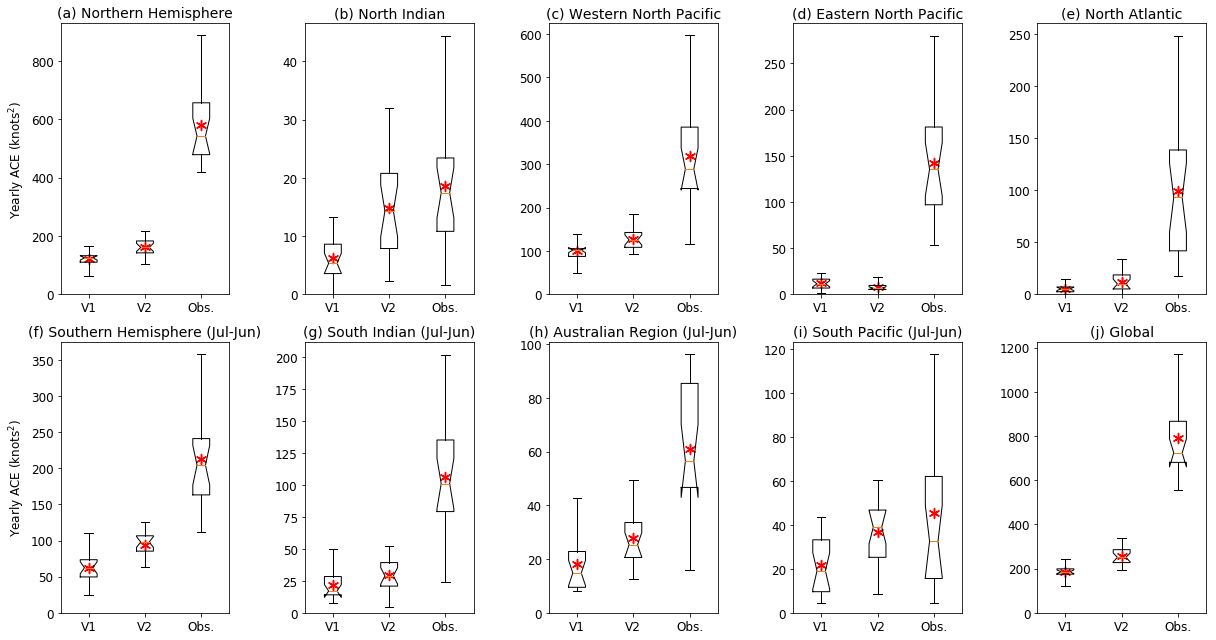

In [29]:
#New plot: 10 panels (5x2), excluding South Atlantic
plt.figure(figsize=(17,9))
regions_10 = ['NH', 'NI', 'WP', 'EP', 'NA', 'SH', 'SI', 'AUS', 'SP', 'G']
region_names = {'NH': 'Northern Hemisphere', 
                'SH': 'Southern Hemisphere', 
                'G': 'Global',
                'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters = {0: 'a', 
           1: 'b', 
           2: 'c', 
           3: 'd', 
           4: 'e', 
           5: 'f', 
           6: 'g', 
           7: 'h',
           8: 'i', 
           9: 'j'}
for i in np.arange(10):
    plt.subplot(2,5,i+1)
    region = regions_10[i]
    if region in ['SH', 'SI', 'AUS', 'SP']:
        plt.boxplot([ACE_sh_v1['ACE_'+region].isel(season=np.arange(20)+1), 
                     ACE_sh_v2['ACE_'+region].isel(season=np.arange(20)+1), 
                     ACE_sh_IB['ACE_'+region].isel(season=np.arange(20)+1)], 
                     notch=True, whis=(0,100))
        plt.scatter(np.array([1.,2.,3.]), 
                    np.array([ACE_sh_v1['ACE_'+region].isel(season=np.arange(20)+1).mean(dim='season').data, 
                              ACE_sh_v2['ACE_'+region].isel(season=np.arange(20)+1).mean(dim='season').data, 
                              ACE_sh_IB['ACE_'+region].isel(season=np.arange(20)+1).mean(dim='season').data]), 
                    marker=(6,2), c='red', s=100)
        plt.title('('+letters[i]+') ' +region_names[region]+' (Jul-Jun)', fontsize=14)    
    else:
        plt.boxplot([ACE_v1['ACE_'+region], 
                     ACE_v2['ACE_'+region], 
                     ACE_IB['ACE_'+region]], 
                    notch=True, whis=(0,100))
        plt.scatter(np.array([1.,2.,3.]), 
                    np.array([ACE_v1['ACE_'+region].mean(dim='year').data, 
                              ACE_v2['ACE_'+region].mean(dim='year').data, 
                              ACE_IB['ACE_'+region].mean(dim='year').data]), 
                    marker=(6,2), c='red', s=100)
        plt.title('('+letters[i]+') ' +region_names[region], fontsize=14)   
    if i in [0,5]:
        plt.ylabel('Yearly ACE (knots$^2$)', fontsize=12)
    plt.gca().set_ylim(bottom=0)
    plt.gca().tick_params(labelsize=12)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
        
plt.tight_layout()
plt.savefig('plots/ACE_boxplots_10panels.png')
plt.savefig('plots/ACE_boxplots_10panels.pdf')

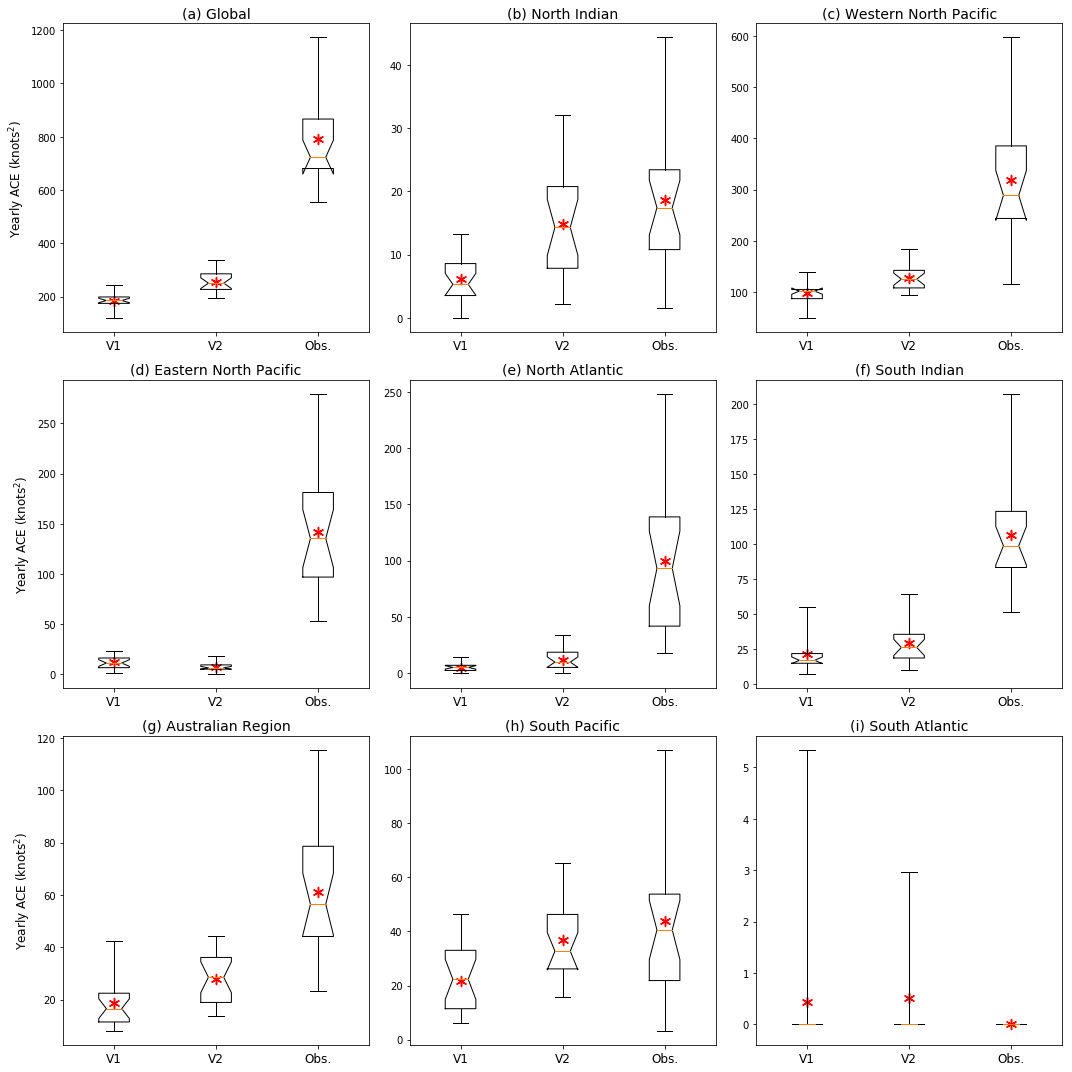

In [187]:
plt.figure(figsize=((15,15)))
plt.subplot(3,3,1)
plt.boxplot([ACE_v1['ACE_G'], ACE_v2['ACE_G'], ACE_IB['ACE_G']], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([ACE_v1['ACE_G'].mean(dim='year').data, ACE_v2['ACE_G'].mean(dim='year').data, ACE_IB['ACE_G'].mean(dim='year').data]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylabel('Yearly ACE (knots$^2$)', fontsize=12)
plt.title('(a) Global', fontsize=14)
regions = ['NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
region_names = {'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters = {0: 'b', 
           1: 'c', 
           2: 'd', 
           3: 'e', 
           4: 'f', 
           5: 'g', 
           6: 'h', 
           7: 'i'}
for i in np.arange(8):
    plt.subplot(3,3,i+2)
    region = regions[i]
    plt.boxplot([ACE_v1['ACE_'+region], ACE_v2['ACE_'+region], ACE_IB['ACE_'+region]], notch=True, whis=(0,100))
    plt.scatter(np.array([1.,2.,3.]), 
                np.array([ACE_v1['ACE_'+region].mean(dim='year').data, ACE_v2['ACE_'+region].mean(dim='year').data, ACE_IB['ACE_'+region].mean(dim='year').data]), 
                marker=(6,2), c='red', s=100)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
    if i in [2,5]:
        plt.ylabel('Yearly ACE (knots$^2$)', fontsize=12)
    plt.title('('+letters[i]+') ' +region_names[region], fontsize=14)
plt.tight_layout()

plt.savefig('plots/ACE_boxplots_global_regions.png')
plt.savefig('plots/ACE_boxplots_global_regions.pdf')

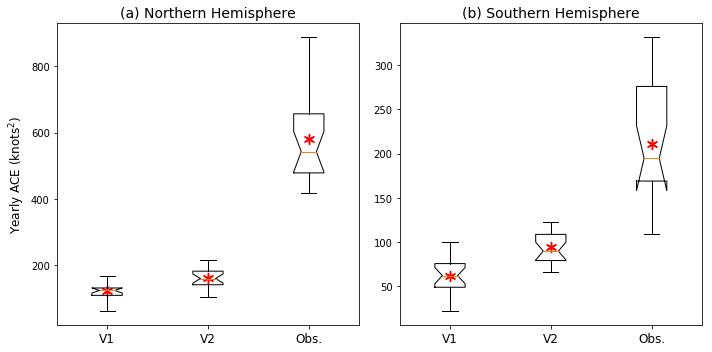

In [188]:
#2 hemispheres
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot([ACE_v1['ACE_NH'], ACE_v2['ACE_NH'], ACE_IB['ACE_NH']], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([ACE_v1['ACE_NH'].mean(dim='year').data, ACE_v2['ACE_NH'].mean(dim='year').data, ACE_IB['ACE_NH'].mean(dim='year').data]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.ylabel('Yearly ACE (knots$^2$)', fontsize=12)
plt.title('(a) Northern Hemisphere', fontsize=14)

plt.subplot(1,2,2)
plt.boxplot([ACE_v1['ACE_SH'], ACE_v2['ACE_SH'], ACE_IB['ACE_SH']], notch=True, whis=(0,100))
plt.scatter(np.array([1.,2.,3.]), 
            np.array([ACE_v1['ACE_SH'].mean(dim='year').data, ACE_v2['ACE_SH'].mean(dim='year').data, ACE_IB['ACE_SH'].mean(dim='year').data]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
plt.title('(b) Southern Hemisphere', fontsize=14)

plt.tight_layout()

plt.savefig('plots/ACE_boxplots_hemispheres.png')
plt.savefig('plots/ACE_boxplots_hemispheres.pdf')

In [ ]:

#####   Combined Counts and ACE plot   #####


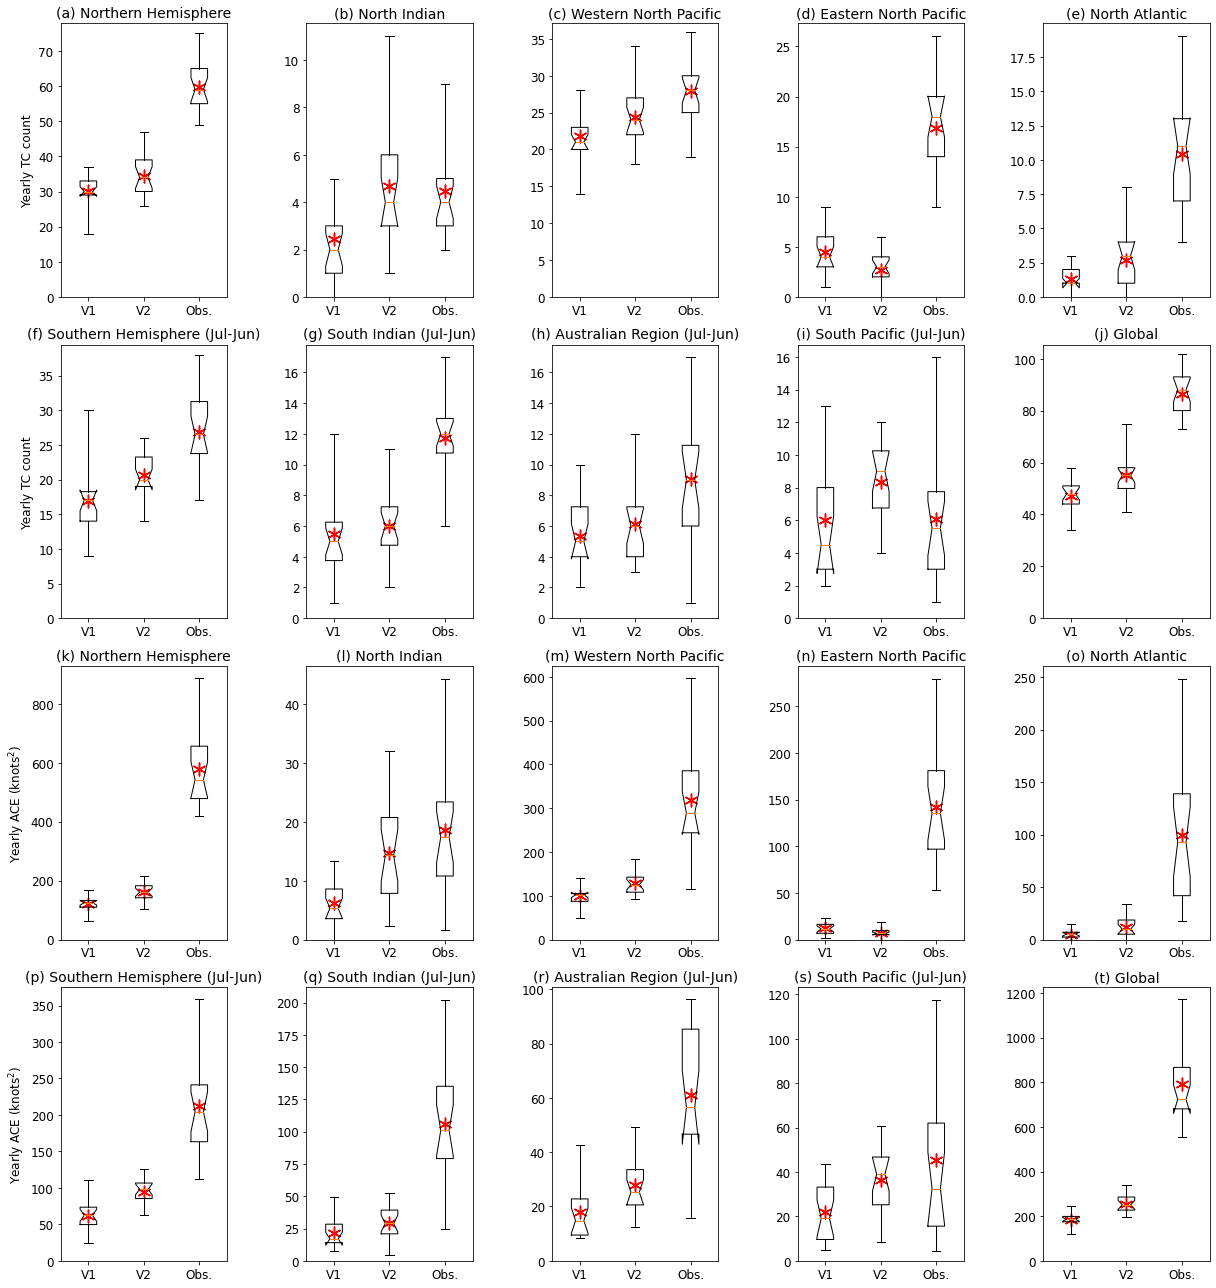

In [49]:
#10-panels on top for counts, 10 on bottom for ACE, MACE

plt.figure(figsize=(17,18))
regions_10 = ['NH', 'NI', 'WP', 'EP', 'NA', 'SH', 'SI', 'AUS', 'SP', 'G']
region_names = {'NH': 'Northern Hemisphere', 
                'SH': 'Southern Hemisphere', 
                'G': 'Global',
                'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters = {0: 'a', 
           1: 'b', 
           2: 'c', 
           3: 'd', 
           4: 'e', 
           5: 'f', 
           6: 'g', 
           7: 'h',
           8: 'i', 
           9: 'j', 
           10: 'k', 
           11: 'l', 
           12: 'm', 
           13: 'n', 
           14: 'o', 
           15: 'p', 
           16: 'q', 
           17: 'r', 
           18: 's', 
           19: 't'}

#Top 10 panels: counts
for i in np.arange(10):
    plt.subplot(4,5,i+1)
    region = regions_10[i]
    if region in ['SH', 'SI', 'AUS', 'SP']:
        plt.boxplot([Counts_sh_v1['count_'+region].isel(season=np.arange(20)+1), 
                     Counts_sh_v2['count_'+region].isel(season=np.arange(20)+1), 
                     Counts_sh_IB['count_'+region].isel(season=np.arange(20)+1)], 
                     notch=True, whis=(0,100))
        plt.scatter(np.array([1.,2.,3.]), 
                    np.array([Counts_sh_v1['count_'+region].isel(season=np.arange(20)+1).mean(dim='season').data, 
                              Counts_sh_v2['count_'+region].isel(season=np.arange(20)+1).mean(dim='season').data, 
                              Counts_sh_IB['count_'+region].isel(season=np.arange(20)+1).mean(dim='season').data]), 
                    marker=(6,2), c='red', s=40)
        plt.title('('+letters[i]+') ' +region_names[region]+' (Jul-Jun)', fontsize=14)    
    else:
        plt.boxplot([Counts_v1['count_'+region], 
                     Counts_v2['count_'+region], 
                     Counts_IB['count_'+region]], 
                    notch=True, whis=(0,100))
        plt.scatter(np.array([1.,2.,3.]), 
                    np.array([Counts_v1['count_'+region].mean(dim='year').data, 
                              Counts_v2['count_'+region].mean(dim='year').data, 
                              Counts_IB['count_'+region].mean(dim='year').data]), 
                    marker=(6,2), c='red', s=40)
        plt.title('('+letters[i]+') ' +region_names[region], fontsize=14)   
    if i in [0,5]:
        plt.ylabel('Yearly TC count', fontsize=12)
    plt.gca().set_ylim(bottom=0)
    plt.gca().tick_params(labelsize=12)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
    
#Bottom 10 panels: ACE
    
for i in np.arange(10):
    plt.subplot(4,5,i+11)
    region = regions_10[i-10]
    if region in ['SH', 'SI', 'AUS', 'SP']:
        plt.boxplot([ACE_sh_v1['ACE_'+region].isel(season=np.arange(20)+1), 
                     ACE_sh_v2['ACE_'+region].isel(season=np.arange(20)+1), 
                     ACE_sh_IB['ACE_'+region].isel(season=np.arange(20)+1)], 
                     notch=True, whis=(0,100))
        plt.scatter(np.array([1.,2.,3.]), 
                    np.array([ACE_sh_v1['ACE_'+region].isel(season=np.arange(20)+1).mean(dim='season').data, 
                              ACE_sh_v2['ACE_'+region].isel(season=np.arange(20)+1).mean(dim='season').data, 
                              ACE_sh_IB['ACE_'+region].isel(season=np.arange(20)+1).mean(dim='season').data]), 
                    marker=(6,2), c='red', s=40)
        plt.title('('+letters[i+10]+') ' +region_names[region]+' (Jul-Jun)', fontsize=14)    
    else:
        plt.boxplot([ACE_v1['ACE_'+region], 
                     ACE_v2['ACE_'+region], 
                     ACE_IB['ACE_'+region]], 
                    notch=True, whis=(0,100))
        plt.scatter(np.array([1.,2.,3.]), 
                    np.array([ACE_v1['ACE_'+region].mean(dim='year').data, 
                              ACE_v2['ACE_'+region].mean(dim='year').data, 
                              ACE_IB['ACE_'+region].mean(dim='year').data]), 
                    marker=(6,2), c='red', s=40)
        plt.title('('+letters[i+10]+') ' +region_names[region], fontsize=14)   
    if i in [0,5]:
        plt.ylabel('Yearly ACE (knots$^2$)', fontsize=12)
    plt.gca().set_ylim(bottom=0)
    plt.gca().tick_params(labelsize=12)
    plt.gca().set_xticklabels(['V1', 'V2', 'Obs.'], fontsize=12)
        
plt.tight_layout()
plt.savefig('plots/Counts_ACE_boxplots_20panels.png')
plt.savefig('plots/Counts_ACE_boxplots_20panels.pdf')


In [13]:

#####   Seasonal Cycle of Counts and ACE in Each Region   #####


In [15]:
#Calculate ACE and storm counts in each region in each month and region, v1
#Similar syntax to the ACE and counts in each year

regions = ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
ACE_dict_v1 = {'G': np.zeros(12), 
                 'NH': np.zeros(12), 
                 'SH': np.zeros(12), 
                 'NI': np.zeros(12), 
                 'WP': np.zeros(12), 
                 'EP': np.zeros(12), 
                 'NA': np.zeros(12), 
                 'SI': np.zeros(12), 
                 'AUS': np.zeros(12), 
                 'SP': np.zeros(12), 
                 'SA': np.zeros(12)}
count_dict_v1 = {'G': np.zeros(12), 
                 'NH': np.zeros(12), 
                 'SH': np.zeros(12), 
                 'NI': np.zeros(12), 
                 'WP': np.zeros(12), 
                 'EP': np.zeros(12), 
                 'NA': np.zeros(12), 
                 'SI': np.zeros(12), 
                 'AUS': np.zeros(12), 
                 'SP': np.zeros(12), 
                 'SA': np.zeros(12)}

#ACE
for i in np.arange(12):
    booleans_month = (ds_tracks_v1['month'] == i+1).data #No "month" data where points are missing so this should work
    windpoints_month_G = ds_tracks_v1['wind_kts'].data[booleans_month==True]
    ACE_dict_v1['G'][i] = tcc.calcACE(windpoints_month_G, 0)
    for region in regions:
        booleans_month_region = np.logical_and(booleans_month, ds_tracks_v1['in_'+region])
        windpoints_month_region = ds_tracks_v1['wind_kts'].data[booleans_month_region==True]
        ACE_dict_v1[region][i] = tcc.calcACE(windpoints_month_region, 0)
        
#Create dict of DataArrays and merge
da_dict_v1 = dict()
for key in ACE_dict_v1.keys():
    da_dict_v1[key] = xr.DataArray(ACE_dict_v1[key], coords=[pd.Index(np.arange(12)+1, name='month')], name='ACE_'+key)
ACE_monthly_v1 = xr.merge(da_dict_v1.values())

#Counts (based on genesis location and month)
for i in np.arange(len(ds_tracks_v1['storm'])):
    month = int(ds_tracks_v1['month'].isel(storm=i,date_time=0))-1
    count_dict_v1['G'][month] += 1
    for region in regions:
        if ds_tracks_v1['gen_'+region].isel(storm=i):
            count_dict_v1[region][month] += 1

#Create dict of DataArrays and merge
da_dict_v1 = dict()
for key in count_dict_v1.keys():
    da_dict_v1[key] = xr.DataArray(count_dict_v1[key], coords=[pd.Index(np.arange(12)+1, name='month')], name='count_'+key)
Counts_monthly_v1 = xr.merge(da_dict_v1.values())            

In [16]:
print(ACE_monthly_v1)
print(Counts_monthly_v1)

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ACE_G    (month) float64 334.7 302.5 344.2 203.0 ... 302.8 488.8 450.5 346.2
    ACE_NH   (month) float64 35.97 11.66 33.61 54.73 ... 302.8 484.8 406.5 173.2
    ACE_SH   (month) float64 298.7 290.9 310.5 148.3 ... 0.0 3.978 43.99 173.0
    ACE_NI   (month) float64 0.0 0.0 0.0 8.621 26.31 ... 8.263 39.0 16.73 8.893
    ACE_WP   (month) float64 35.97 11.66 33.61 46.11 ... 184.9 411.3 379.4 160.3
    ACE_EP   (month) float64 0.0 0.0 0.0 0.0 6.694 ... 60.32 8.049 0.0 1.664
    ACE_NA   (month) float64 0.0 0.0 0.0 0.0 0.0 ... 7.515 49.3 26.44 10.45 2.34
    ACE_SI   (month) float64 148.9 80.98 105.0 46.76 ... 0.0 0.0 3.833 48.49
    ACE_AUS  (month) float64 88.0 109.7 96.82 28.37 ... 0.0 1.766 19.75 49.64
    ACE_SP   (month) float64 61.88 100.2 107.8 68.78 ... 0.0 2.212 20.41 74.91
    ACE_SA   (month) float64 0.0 0.0 0.959 4.376 3.798 ... 0.0 0.0 0.0 0.0 0.0
<x

In [17]:
regions = ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
ACE_dict_v2 = {'G': np.zeros(12), 
                 'NH': np.zeros(12), 
                 'SH': np.zeros(12), 
                 'NI': np.zeros(12), 
                 'WP': np.zeros(12), 
                 'EP': np.zeros(12), 
                 'NA': np.zeros(12), 
                 'SI': np.zeros(12), 
                 'AUS': np.zeros(12), 
                 'SP': np.zeros(12), 
                 'SA': np.zeros(12)}
count_dict_v2 = {'G': np.zeros(12), 
                 'NH': np.zeros(12), 
                 'SH': np.zeros(12), 
                 'NI': np.zeros(12), 
                 'WP': np.zeros(12), 
                 'EP': np.zeros(12), 
                 'NA': np.zeros(12), 
                 'SI': np.zeros(12), 
                 'AUS': np.zeros(12), 
                 'SP': np.zeros(12), 
                 'SA': np.zeros(12)}

#ACE
for i in np.arange(12):
    booleans_month = (ds_tracks_v2['month'] == i+1).data #No "month" data where points are missing so this should work
    windpoints_month_G = ds_tracks_v2['wind_kts'].data[booleans_month==True]
    ACE_dict_v2['G'][i] = tcc.calcACE(windpoints_month_G, 0)
    for region in regions:
        booleans_month_region = np.logical_and(booleans_month, ds_tracks_v2['in_'+region])
        windpoints_month_region = ds_tracks_v2['wind_kts'].data[booleans_month_region==True]
        ACE_dict_v2[region][i] = tcc.calcACE(windpoints_month_region, 0)
        
#Create dict of DataArrays and merge
da_dict_v2 = dict()
for key in ACE_dict_v2.keys():
    da_dict_v2[key] = xr.DataArray(ACE_dict_v2[key], coords=[pd.Index(np.arange(12)+1, name='month')], name='ACE_'+key)
ACE_monthly_v2 = xr.merge(da_dict_v2.values())

#Counts (based on genesis location and month)
for i in np.arange(len(ds_tracks_v2['storm'])):
    month = int(ds_tracks_v2['month'].isel(storm=i,date_time=0))-1
    count_dict_v2['G'][month] += 1
    for region in regions:
        if ds_tracks_v2['gen_'+region].isel(storm=i):
            count_dict_v2[region][month] += 1

#Create dict of DataArrays and merge
da_dict_v2 = dict()
for key in count_dict_v2.keys():
    da_dict_v2[key] = xr.DataArray(count_dict_v2[key], coords=[pd.Index(np.arange(12)+1, name='month')], name='count_'+key)
Counts_monthly_v2 = xr.merge(da_dict_v2.values())            

In [18]:
#Observations--same caveats as above: replace month with time.month, wind_kts with usa_wind. 
#ACE is easier in this regard. 
#Also need genesis month based on month where first non-zero 
#(Could this be a separate variable calculated during pre-processing, along with the genesis region flags?)

#Now have the genesis month variable, this will make things easier for counts. 

In [19]:
regions = ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP', 'SA']
ACE_dict_IB = {'G': np.zeros(12), 
                 'NH': np.zeros(12), 
                 'SH': np.zeros(12), 
                 'NI': np.zeros(12), 
                 'WP': np.zeros(12), 
                 'EP': np.zeros(12), 
                 'NA': np.zeros(12), 
                 'SI': np.zeros(12), 
                 'AUS': np.zeros(12), 
                 'SP': np.zeros(12), 
                 'SA': np.zeros(12)}
count_dict_IB = {'G': np.zeros(12), 
                 'NH': np.zeros(12), 
                 'SH': np.zeros(12), 
                 'NI': np.zeros(12), 
                 'WP': np.zeros(12), 
                 'EP': np.zeros(12), 
                 'NA': np.zeros(12), 
                 'SI': np.zeros(12), 
                 'AUS': np.zeros(12), 
                 'SP': np.zeros(12), 
                 'SA': np.zeros(12)}

#ACE
for i in np.arange(12):
    booleans_month = np.logical_and((ds_tracks_IB['time.month'] == i+1).data, 
                                   np.logical_not(np.isnan(ds_tracks_IB['usa_wind'].data))) #extra check that usa_wind exists at each point
    windpoints_month_G = ds_tracks_IB['usa_wind'].data[booleans_month==True]
    ACE_dict_IB['G'][i] = tcc.calcACE(windpoints_month_G, 35)
    for region in regions:
        booleans_month_region = np.logical_and(booleans_month, ds_tracks_IB['in_'+region])
        windpoints_month_region = ds_tracks_IB['usa_wind'].data[booleans_month_region==True]
        ACE_dict_IB[region][i] = tcc.calcACE(windpoints_month_region, 35)
        
#Create dict of DataArrays and merge
da_dict_IB = dict()
for key in ACE_dict_IB.keys():
    da_dict_IB[key] = xr.DataArray(ACE_dict_IB[key], coords=[pd.Index(np.arange(12)+1, name='month')], name='ACE_'+key)
ACE_monthly_IB = xr.merge(da_dict_IB.values())

#Counts (based on genesis location and month)
for i in np.arange(len(ds_tracks_IB['storm'])):
    month = int(ds_tracks_IB['gen_month'].isel(storm=i))-1
    count_dict_IB['G'][month] += 1
    for region in regions:
        if ds_tracks_IB['gen_'+region].isel(storm=i):
            count_dict_IB[region][month] += 1

#Create dict of DataArrays and merge
da_dict_IB = dict()
for key in count_dict_IB.keys():
    da_dict_IB[key] = xr.DataArray(count_dict_IB[key], coords=[pd.Index(np.arange(12)+1, name='month')], name='count_'+key)
Counts_monthly_IB = xr.merge(da_dict_IB.values())     

In [20]:
print(Counts_monthly_IB)

<xarray.Dataset>
Dimensions:    (month: 12)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    count_G    (month) float64 140.0 137.0 109.0 76.0 ... 198.0 129.0 113.0
    count_NH   (month) float64 14.0 2.0 11.0 20.0 54.0 ... 267.0 184.0 98.0 39.0
    count_SH   (month) float64 126.0 135.0 98.0 56.0 14.0 ... 5.0 14.0 31.0 74.0
    count_NI   (month) float64 4.0 0.0 1.0 3.0 14.0 ... 1.0 3.0 21.0 25.0 10.0
    count_WP   (month) float64 8.0 2.0 10.0 16.0 26.0 ... 114.0 89.0 55.0 27.0
    count_EP   (month) float64 2.0 0.0 0.0 0.0 11.0 ... 84.0 78.0 40.0 4.0 1.0
    count_NA   (month) float64 0.0 0.0 0.0 1.0 3.0 ... 62.0 72.0 34.0 14.0 1.0
    count_SI   (month) float64 54.0 52.0 35.0 27.0 6.0 ... 5.0 10.0 22.0 24.0
    count_AUS  (month) float64 46.0 57.0 35.0 17.0 5.0 ... 0.0 0.0 0.0 3.0 30.0
    count_SP   (month) float64 26.0 26.0 28.0 12.0 3.0 ... 0.0 0.0 4.0 6.0 20.0
    count_SA   (month) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


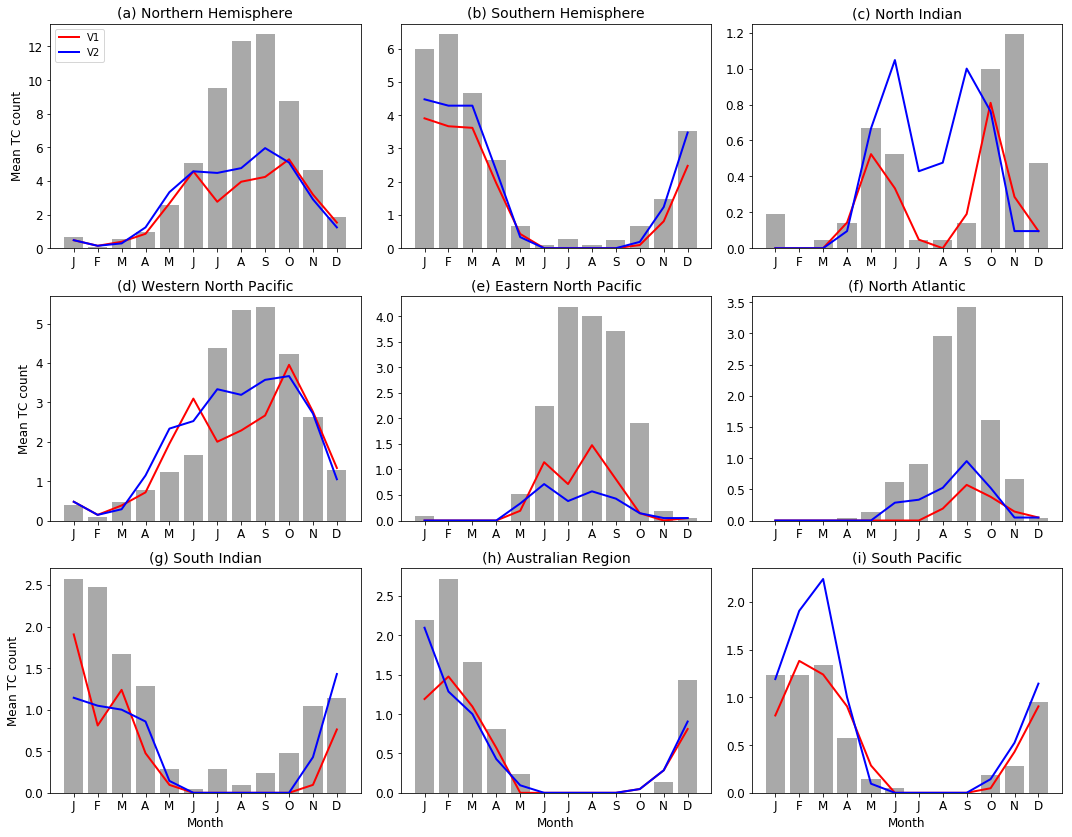

In [55]:
#Bar graph for the observations, line for each model: globally, 7 regions (excluding SA), and each hemisphere--2x5
#Actually, Suzana says global is irrelevant for this so do a 3x3 grid.
#Also forgot to divide by number of years!

#Counts 

plt.figure(figsize=(15,15))

# plt.subplot(4,3,1) #Global
# plt.bar(np.arange(12), Counts_monthly_IB['count_G'])
# plt.plot(np.arange(12), Counts_monthly_v1['count_G'], 'r', linewidth=2)
# plt.plot(np.arange(12), Counts_monthly_v2['count_G'], 'k', linewidth=2)
# plt.gca().set_xticks(np.arange(12))
# plt.gca().set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
# plt.ylabel('Tropical cyclone counts')
# plt.title('Global')
# plt.legend(['V1', 'V2'], loc='upper left')

regions = ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP']
region_names = {'NH': 'Northern Hemisphere', 
                'SH': 'Southern Hemisphere', 
                'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters_dict = {0: '(a)', 
                1: '(b)',
                2: '(c)', 
                3: '(d)',
                4: '(e)',
                5: '(f)',
                6: '(g)',
                7: '(h)',
                8: '(i)'}
for i in np.arange(len(regions)):
    plt.subplot(4,3,i+1) #Global
    plt.bar(np.arange(12), Counts_monthly_IB['count_'+regions[i]]/21., color='darkgrey')
    plt.plot(np.arange(12), Counts_monthly_v1['count_'+regions[i]]/21., 'r', linewidth=2)
    plt.plot(np.arange(12), Counts_monthly_v2['count_'+regions[i]]/21., 'b', linewidth=2)
    plt.gca().set_xticks(np.arange(12))
    plt.gca().set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    plt.gca().tick_params(labelsize=12)
    if i in ([0, 3, 6]): 
        plt.ylabel('Mean TC count', fontsize=12)
    if i >= 6:
        plt.xlabel('Month', fontsize=12)
    if i == 0:
        plt.legend(['V1', 'V2'], loc='upper left')
    plt.title(letters_dict[i]+' ' + region_names[regions[i]], fontsize=14)
    
plt.tight_layout()

plt.savefig('plots/seasonal_cycle_counts.pdf')
plt.savefig('plots/seasonal_cycle_counts.png')

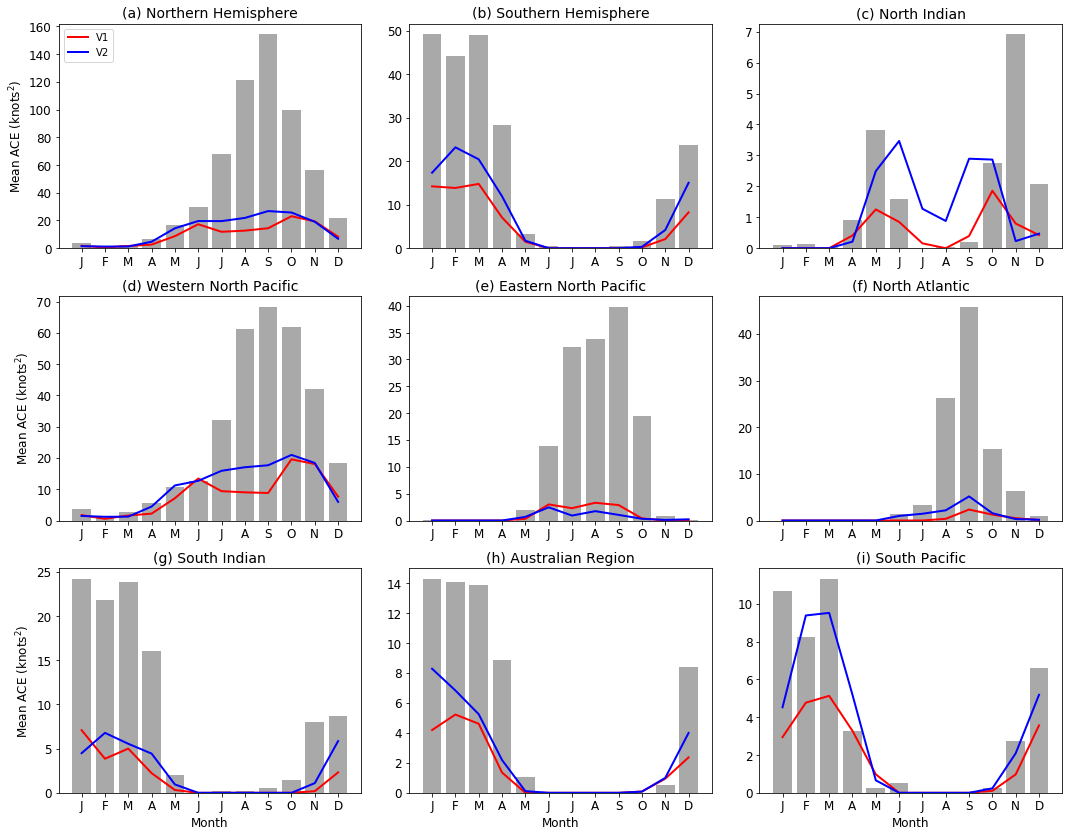

In [56]:
#Same for ACE
plt.figure(figsize=(15,15))


regions = ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP']
region_names = {'NH': 'Northern Hemisphere', 
                'SH': 'Southern Hemisphere', 
                'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters_dict = {0: '(a)', 
                1: '(b)',
                2: '(c)', 
                3: '(d)',
                4: '(e)',
                5: '(f)',
                6: '(g)',
                7: '(h)',
                8: '(i)'}

for i in np.arange(len(regions)):
    plt.subplot(4,3,i+1) #Global
    plt.bar(np.arange(12), ACE_monthly_IB['ACE_'+regions[i]]/21., color='darkgrey')
    plt.plot(np.arange(12), ACE_monthly_v1['ACE_'+regions[i]]/21., 'r', linewidth=2)
    plt.plot(np.arange(12), ACE_monthly_v2['ACE_'+regions[i]]/21., 'b', linewidth=2)
    plt.gca().set_xticks(np.arange(12))
    plt.gca().set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    plt.gca().tick_params(labelsize=12)
    if i in ([0, 3, 6]): 
        plt.ylabel('Mean ACE (knots$^2$)', fontsize=12)
    if i >= 6:
        plt.xlabel('Month', fontsize=12)
    if i == 0:
        plt.legend(['V1', 'V2'], loc='upper left')
    plt.title(letters_dict[i]+' ' + region_names[regions[i]], fontsize=14)
    
plt.tight_layout()

plt.savefig('plots/seasonal_cycle_ACE.pdf')
plt.savefig('plots/seasonal_cycle_ACE.png')

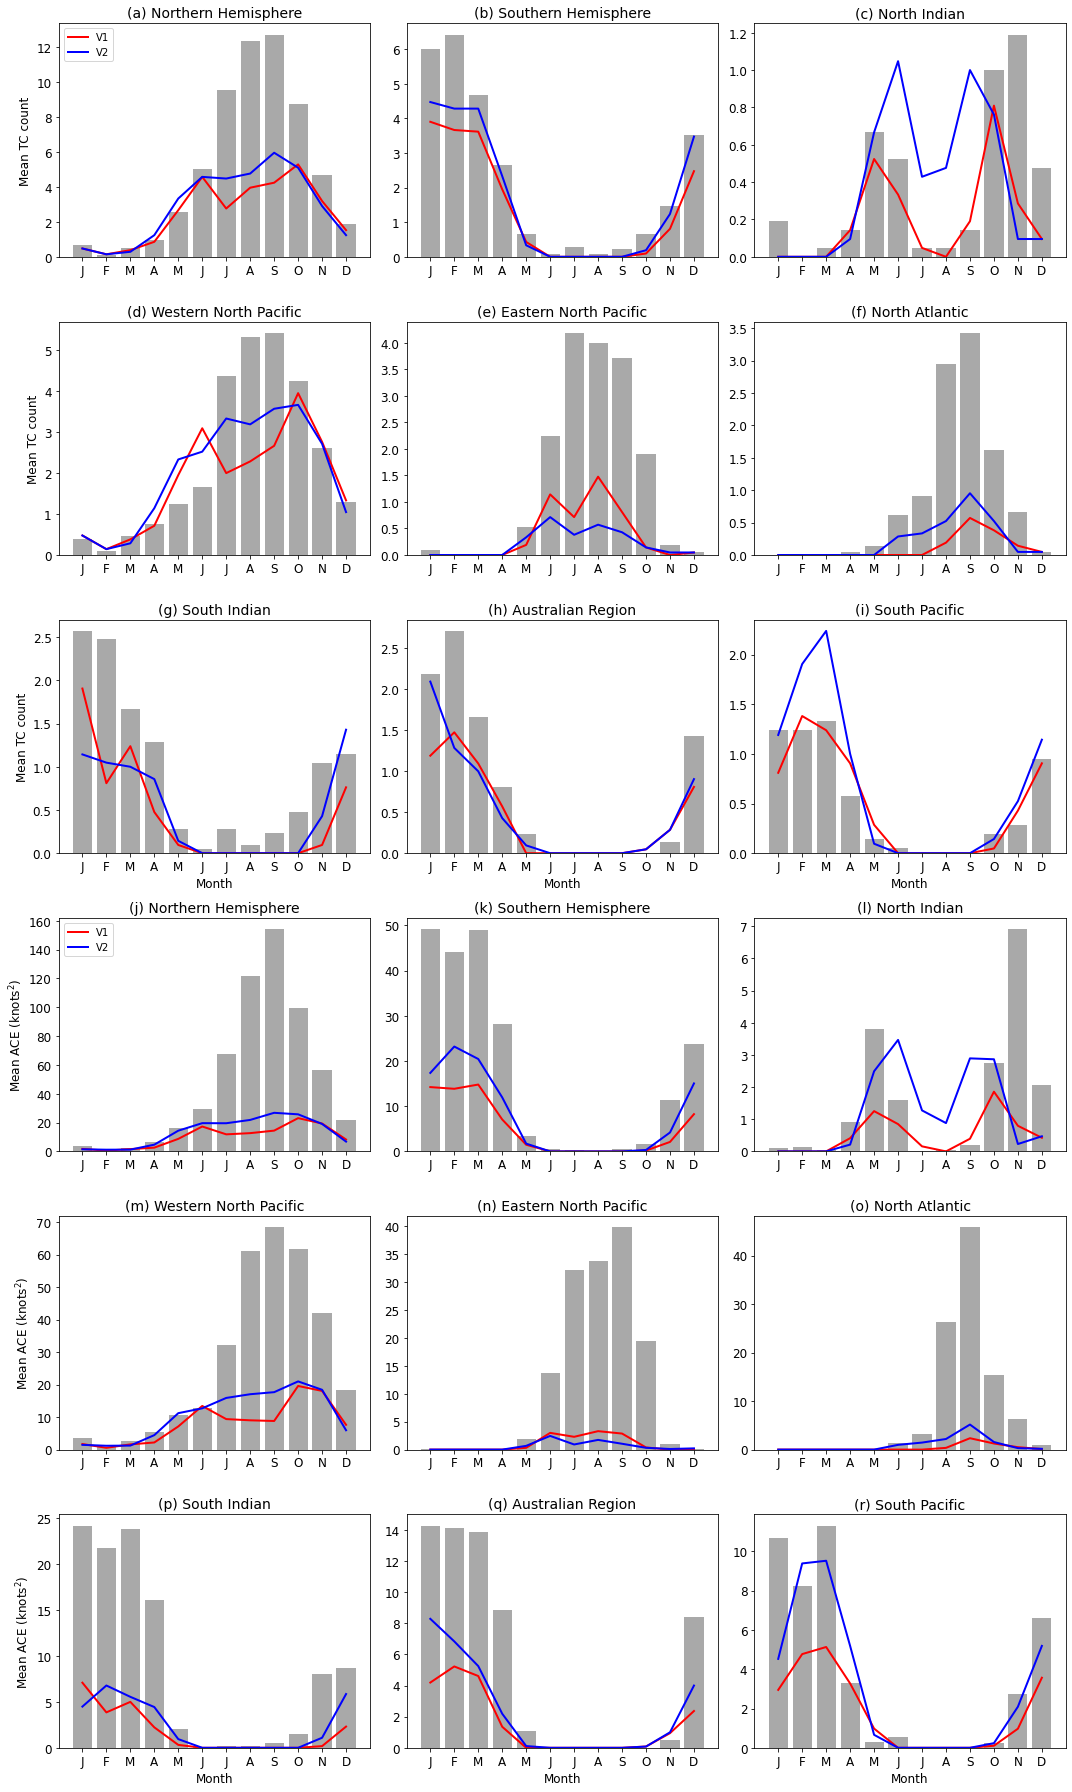

In [24]:
#Combined 18-panel plot

#Counts 

plt.figure(figsize=(15,25))


regions = ['NH', 'SH', 'NI', 'WP', 'EP', 'NA', 'SI', 'AUS', 'SP']
region_names = {'NH': 'Northern Hemisphere', 
                'SH': 'Southern Hemisphere', 
                'NI': 'North Indian', 
                'WP': 'Western North Pacific', 
                'EP': 'Eastern North Pacific', 
                'NA': 'North Atlantic', 
                'SI': 'South Indian', 
                'AUS': 'Australian Region', 
                'SP': 'South Pacific', 
                'SA': 'South Atlantic'}
letters_dict = {0: '(a)', 
                1: '(b)',
                2: '(c)', 
                3: '(d)',
                4: '(e)',
                5: '(f)',
                6: '(g)',
                7: '(h)',
                8: '(i)', 
                9: '(j)', 
                10: '(k)', 
                11: '(l)', 
                12: '(m)', 
                13: '(n)', 
                14: '(o)', 
                15: '(p)', 
                16: '(q)', 
                17: '(r)'}

#Counts
for i in np.arange(len(regions)):
    plt.subplot(6,3,i+1) #Global
    plt.bar(np.arange(12), Counts_monthly_IB['count_'+regions[i]]/21., color='darkgrey')
    plt.plot(np.arange(12), Counts_monthly_v1['count_'+regions[i]]/21., 'r', linewidth=2)
    plt.plot(np.arange(12), Counts_monthly_v2['count_'+regions[i]]/21., 'b', linewidth=2)
    plt.gca().set_xticks(np.arange(12))
    plt.gca().set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    plt.gca().tick_params(labelsize=12)
    if i in ([0, 3, 6]): 
        plt.ylabel('Mean TC count', fontsize=12)
    if i >= 6:
        plt.xlabel('Month', fontsize=12)
    if i == 0:
        plt.legend(['V1', 'V2'], loc='upper left')
    plt.title(letters_dict[i]+' ' + region_names[regions[i]], fontsize=14)
    
#Same for ACE

for i in np.arange(len(regions)):
    plt.subplot(6,3,i+10) #Global
    plt.bar(np.arange(12), ACE_monthly_IB['ACE_'+regions[i]]/21., color='darkgrey')
    plt.plot(np.arange(12), ACE_monthly_v1['ACE_'+regions[i]]/21., 'r', linewidth=2)
    plt.plot(np.arange(12), ACE_monthly_v2['ACE_'+regions[i]]/21., 'b', linewidth=2)
    plt.gca().set_xticks(np.arange(12))
    plt.gca().set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    plt.gca().tick_params(labelsize=12)
    if i in ([0, 3, 6]): 
        plt.ylabel('Mean ACE (knots$^2$)', fontsize=12)
    if i >= 6:
        plt.xlabel('Month', fontsize=12)
    if i == 0:
        plt.legend(['V1', 'V2'], loc='upper left')
    plt.title(letters_dict[i+9]+' ' + region_names[regions[i]], fontsize=14)
    
plt.tight_layout()

plt.savefig('plots/seasonal_cycle_combined_counts_ACE.pdf')
plt.savefig('plots/seasonal_cycle_combined_counts_ACE.png')


In [47]:

#####   Histograms/PDFs of wind & pressure across storm lifetimes   #####


In [48]:
#(This one is easy, don't need to subset by year or basin)

In [49]:
#Strategy: flatten the wind or pressure obs; throw out the nans; and make the plot.

In [50]:
#Wait--in previous published papers, these have all been for lifetime maximum intensity, 
#not for all of the intensities at any point during the storm's lifetime. Should do that instead.

In [51]:
#print(ds_tracks_v1['wind_kts'])

In [52]:
#wind_flat_v1 = ds_tracks_v1['wind_kts'].data.flatten()
#wind_nonan_v1 = wind_flat_v1[np.logical_not(np.isnan(wind_flat_v1))]

In [53]:
#print(len(wind_nonan_v1))

In [54]:
print(ds_tracks_v1)
#Already have max_wind_kts, min_pressure
#  or         max_usa_wind, min_wmo_pres 
# to use for this.

<xarray.Dataset>
Dimensions:          (date_time: 360, storm: 987)
Coordinates:
  * date_time        (date_time) int64 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * storm            (storm) int64 0 1 2 3 4 5 6 7 8 ... 35 36 37 38 39 40 41 42
    sh_season        (storm, date_time) float64 ...
Data variables:
    lon              (storm, date_time) float64 ...
    lat              (storm, date_time) float64 ...
    wind             (storm, date_time) float64 ...
    pressure         (storm, date_time) float64 9.85 9.84 9.82 ... nan nan nan
    year             (storm, date_time) float64 ...
    month            (storm, date_time) float64 ...
    day              (storm, date_time) float64 ...
    hour             (storm, date_time) float64 ...
    wind_kts         (storm, date_time) float64 30.71 33.57 32.5 ... nan nan nan
    lon360           (storm, date_time) float64 ...
    in_NH            (storm, date_time) bool ...
    in_SH            (storm, date_time) bool ...
    in_NI       

In [55]:
#Bins for the histograms
bins_wind = np.arange(40)*5+2.5 #Up to 200 knots, surrounding the increments of 5 used in obs.
bins_pres = np.arange(16)*10+870 #870 to 1020 hPa in units of 10

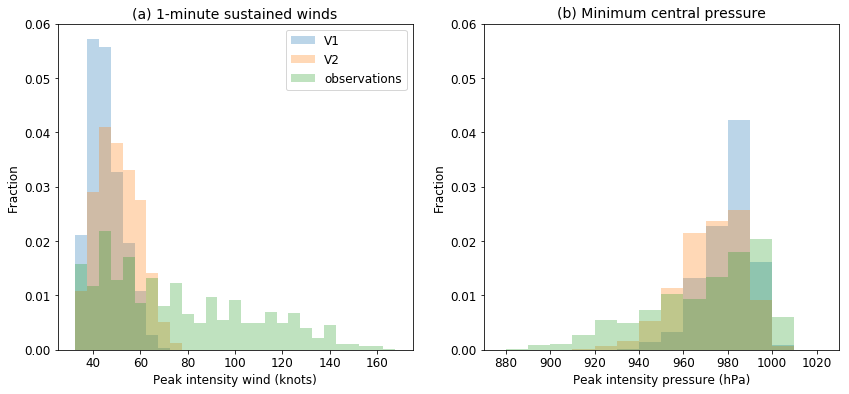

In [56]:
#Plot, 2 panels--winds (a), pressure (b)
plt.figure(figsize=(14,6))

#winds
#Bin by 5-knot increments, like the observations
#Also need to normalize by the number of storms: use "density=True"
plt.subplot(1,2,1)
plt.hist(ds_tracks_v1['max_wind_kts'], bins=bins_wind, density=True, histtype='stepfilled', alpha=0.3)
plt.hist(ds_tracks_v2['max_wind_kts'], bins=bins_wind, density=True, histtype='stepfilled', alpha=0.3)
plt.hist(ds_tracks_IB['max_usa_wind'], bins=bins_wind, density=True, histtype='stepfilled', alpha=0.3)
plt.axis([25, 175, 0, 0.06])
plt.legend(['V1', 'V2', 'observations'], fontsize=12)
plt.title('(a) 1-minute sustained winds', fontsize=14)
plt.xlabel('Peak intensity wind (knots)', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.gca().tick_params(labelsize=12)

#Pressure: bin by increments of 10 hPa
plt.subplot(1,2,2)
plt.hist(ds_tracks_v1['min_pressure']*100, bins=bins_pres, density=True, histtype='stepfilled', alpha=0.3)
plt.hist(ds_tracks_v2['min_pressure']*100, bins=bins_pres, density=True, histtype='stepfilled', alpha=0.3)
plt.hist(ds_tracks_IB['min_wmo_pres'], bins=bins_pres, density=True, histtype='stepfilled', alpha=0.3)
plt.axis([870, 1030, 0, 0.06])
#plt.legend(['V1', 'V2', 'observations'], fontsize=12)
plt.title('(b) Minimum central pressure', fontsize=14)
plt.xlabel('Peak intensity pressure (hPa)', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.gca().tick_params(labelsize=12)

plt.savefig('plots/histograms_wind_pressure_transparent.png')
plt.savefig('plots/histograms_wind_pressure_transparent.pdf')


In [57]:
#Version with steps instead, or line plots instead of histograms? 
#And maybe double up the wind bins?
#Just ask Adam & Suzana about presentation 

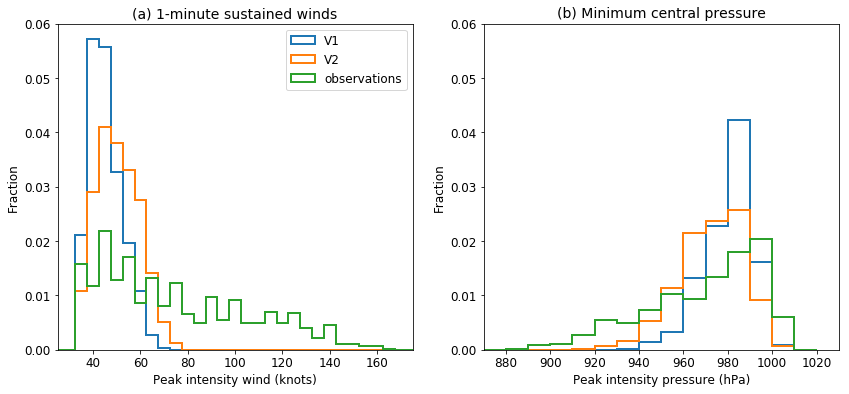

In [40]:
#Plot, 2 panels--winds (a), pressure (b)
plt.figure(figsize=(14,6))

#winds
#Bin by 5-knot increments, like the observations
#Also need to normalize by the number of storms: use "density=True"
plt.subplot(1,2,1)
plt.hist(ds_tracks_v1['max_wind_kts'], bins=bins_wind, density=True, histtype='step', linewidth=2)
plt.hist(ds_tracks_v2['max_wind_kts'], bins=bins_wind, density=True, histtype='step', linewidth=2)
plt.hist(ds_tracks_IB['max_usa_wind'], bins=bins_wind, density=True, histtype='step', linewidth=2)
plt.axis([25, 175, 0, 0.06])
plt.legend(['V1', 'V2', 'observations'], fontsize=12)
plt.title('(a) 1-minute sustained winds', fontsize=14)
plt.xlabel('Peak intensity wind (knots)', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.gca().tick_params(labelsize=12)

#Pressure: bin by increments of 10 hPa
plt.subplot(1,2,2)
plt.hist(ds_tracks_v1['min_pressure']*100, bins=bins_pres, density=True, histtype='step', linewidth=2)
plt.hist(ds_tracks_v2['min_pressure']*100, bins=bins_pres, density=True, histtype='step', linewidth=2)
plt.hist(ds_tracks_IB['min_wmo_pres'], bins=bins_pres, density=True, histtype='step', linewidth=2)
plt.axis([870, 1030, 0, 0.06])
#plt.legend(['V1', 'V2', 'observations'], fontsize=12)
plt.title('(b) Minimum central pressure', fontsize=14)
plt.xlabel('Peak intensity pressure (hPa)', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.gca().tick_params(labelsize=12)

plt.savefig('plots/histograms_wind_pressure_line.png')
plt.savefig('plots/histograms_wind_pressure_line.pdf')


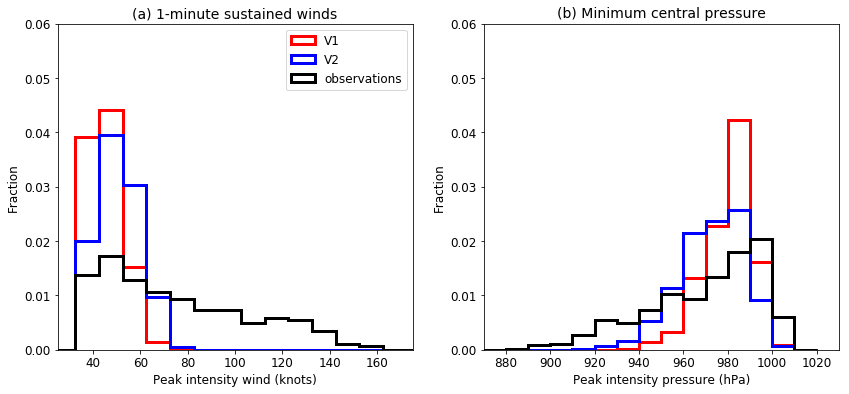

In [63]:
#Step version with winds binned by 10 knots instead of 5 (Adam & Suzana say that's easier to read) and thicker lines
plt.figure(figsize=(14,6))


bins_wind_10 = np.linspace(5, 205, 21)-2.5 #Increments of 10--2.5, 12.5, 22.5, etc. surrounding 2 5-knot obs. possibilities each
bins_pres = np.arange(16)*10+870 #870 to 1020 hPa in units of 10

#winds
#Bin by 5-knot increments, like the observations
#Also need to normalize by the number of storms: use "density=True"
plt.subplot(1,2,1)
plt.hist(ds_tracks_v1['max_wind_kts'], bins=bins_wind_10, density=True, histtype='step', linewidth=3, color='r')
plt.hist(ds_tracks_v2['max_wind_kts'], bins=bins_wind_10, density=True, histtype='step', linewidth=3, color='b')
plt.hist(ds_tracks_IB['max_usa_wind'], bins=bins_wind_10, density=True, histtype='step', linewidth=3, color='k')
plt.axis([25, 175, 0, 0.06])
plt.legend(['V1', 'V2', 'observations'], fontsize=12)
plt.title('(a) 1-minute sustained winds', fontsize=14)
plt.xlabel('Peak intensity wind (knots)', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.gca().tick_params(labelsize=12)

#Pressure: bin by increments of 10 hPa
plt.subplot(1,2,2)
plt.hist(ds_tracks_v1['min_pressure']*100, bins=bins_pres, density=True, histtype='step', linewidth=3, color='r')
plt.hist(ds_tracks_v2['min_pressure']*100, bins=bins_pres, density=True, histtype='step', linewidth=3, color='b')
plt.hist(ds_tracks_IB['min_wmo_pres'], bins=bins_pres, density=True, histtype='step', linewidth=3, color='k') 
plt.axis([870, 1030, 0, 0.06])
#plt.legend(['V1', 'V2', 'observations'], fontsize=12)
plt.title('(b) Minimum central pressure', fontsize=14)
plt.xlabel('Peak intensity pressure (hPa)', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.gca().tick_params(labelsize=12)

plt.savefig('plots/histograms_wind_pressure_line_10kts.png')
plt.savefig('plots/histograms_wind_pressure_line_10kts.pdf')

In [64]:
print(np.linspace(5,205,21)-2.5)

[  2.5  12.5  22.5  32.5  42.5  52.5  62.5  72.5  82.5  92.5 102.5 112.5
 122.5 132.5 142.5 152.5 162.5 172.5 182.5 192.5 202.5]


In [65]:
#Obs. should def. be black. Should that be the case for the seasonal graphs as well? Did this (grey actually)

In [66]:
#Maybe these would look better in front of a solid grey background for the obs?

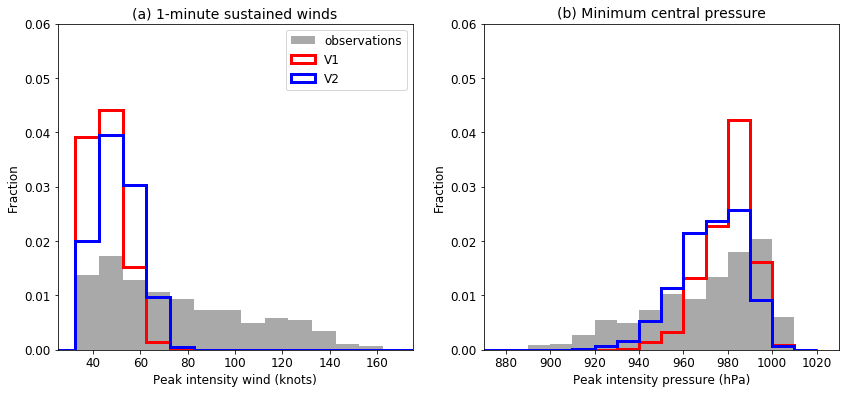

In [67]:
#Step version with winds binned by 10 knots instead of 5 (Adam & Suzana say that's easier to read) and thicker lines
plt.figure(figsize=(14,6))


bins_wind_10 = np.linspace(5, 205, 21)-2.5 #Increments of 10--2.5, 12.5, 22.5, etc. surrounding 2 5-knot obs. possibilities each
bins_pres = np.arange(16)*10+870 #870 to 1020 hPa in units of 10

#winds
#Bin by 5-knot increments, like the observations
#Also need to normalize by the number of storms: use "density=True"
plt.subplot(1,2,1)
plt.hist(ds_tracks_IB['max_usa_wind'], bins=bins_wind_10, density=True, histtype='stepfilled', linewidth=3, color='darkgrey')
plt.hist(ds_tracks_v1['max_wind_kts'], bins=bins_wind_10, density=True, histtype='step', linewidth=3, color='r')
plt.hist(ds_tracks_v2['max_wind_kts'], bins=bins_wind_10, density=True, histtype='step', linewidth=3, color='b')
plt.axis([25, 175, 0, 0.06])
plt.legend(['observations', 'V1', 'V2'], fontsize=12)
plt.title('(a) 1-minute sustained winds', fontsize=14)
plt.xlabel('Peak intensity wind (knots)', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.gca().tick_params(labelsize=12)

#Pressure: bin by increments of 10 hPa
plt.subplot(1,2,2)
plt.hist(ds_tracks_IB['min_wmo_pres'], bins=bins_pres, density=True, histtype='stepfilled', linewidth=3, color='darkgrey') 
plt.hist(ds_tracks_v1['min_pressure']*100, bins=bins_pres, density=True, histtype='step', linewidth=3, color='r')
plt.hist(ds_tracks_v2['min_pressure']*100, bins=bins_pres, density=True, histtype='step', linewidth=3, color='b')
plt.axis([870, 1030, 0, 0.06])
#plt.legend(['V1', 'V2', 'observations'], fontsize=12)
plt.title('(b) Minimum central pressure', fontsize=14)
plt.xlabel('Peak intensity pressure (hPa)', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.gca().tick_params(labelsize=12)

plt.savefig('plots/histograms_wind_pressure_line_10kts_greyobs.png')
plt.savefig('plots/histograms_wind_pressure_line_10kts_greyobs.pdf')

In [30]:

#####   COMPARISON TO E2   #####


In [14]:
#(Could combine with the histogram plots above but easier to keep as separate figure)

In [13]:
#Load the mat file in E2_data--sent by Suzana: peak intensity winds for E2, shown in Shaevitz et al. 2014 Figure 8
mat = scipy.io.loadmat('E2_data/TCmaxwind.mat')

In [14]:
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Aug 29 15:00:29 2014', '__version__': '1.0', '__globals__': [], 'maxwind_obs': array([[22.63536, 26.75088, 26.75088, ...,      nan,      nan,      nan]]), 'maxwind_control': array([[11.44231892, 10.5408392 , 11.24493504, ...,         nan,
                nan,         nan]]), 'maxwind_p2k': array([[13.4223423 , 12.00976086, 14.00415897, ..., 20.43565178,
        14.39830208, 12.09876442]]), 'maxwind_2co2': array([[ 9.95895576, 12.71750641, 15.07160759, ...,         nan,
                nan,         nan]]), 'maxwind_p2k2co2': array([[15.21892548, 10.85134506, 14.05246353, ...,         nan,
                nan,         nan]]), 't8gl': array([[(array([[1]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8))]],
      dtype=[('h_23', 'O'), ('h_24', 'O'), ('h_25', 'O')])}


In [15]:
#This actually worked! Output as a dict of NumPY arrays

In [16]:
print(mat['maxwind_control'])

[[11.44231892 10.5408392  11.24493504 ...         nan         nan
          nan]]


In [17]:
print(np.shape(mat['maxwind_control']))

(1, 1749)


In [18]:
print(mat['__header__'])

b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Aug 29 15:00:29 2014'


In [19]:
#Don't know what the units are. But seems like the peak intensity winds of 1749 storms 
#Bunchh of nans at the end though 

In [20]:
#plt.boxplot(mat['maxwind_control'])

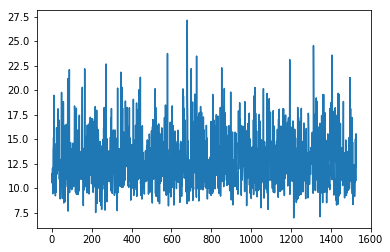

In [21]:
plt.plot(mat['maxwind_control'][0,:])

In [ ]:
#According to Suzana, yes, this is the maximum intensity reached by each TC. 

In [28]:
print(np.sum(np.isnan(winds_peak_E2)))

222


In [22]:
winds_peak_E2 = mat['maxwind_control'][0,:]

In [30]:
winds_peak_E2 = winds_peak_E2[np.logical_not(np.isnan(winds_peak_E2))]

In [31]:
winds_peak_E2_kts = winds_peak_E2 * 1.94384

{'whiskers': [<matplotlib.lines.Line2D at 0x7f77531ed240>,
 'caps': [<matplotlib.lines.Line2D at 0x7f77531ed908>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f77531ed0f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f77531edf98>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f77531f7320>],
 'means': []}

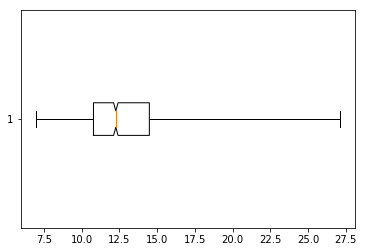

In [34]:
#m/s version to compare to Shaevitz et al. 
plt.figure()
plt.boxplot([winds_peak_E2], notch=True, whis=[0,100], vert=False)

#Yes, looks right. But why is notch offset a bit from the median? Just resolution issue?

{'whiskers': [<matplotlib.lines.Line2D at 0x7f77536c2048>,
 'caps': [<matplotlib.lines.Line2D at 0x7f77536c2710>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f775329eeb8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f77536c2da0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f77536b9128>],
 'means': []}

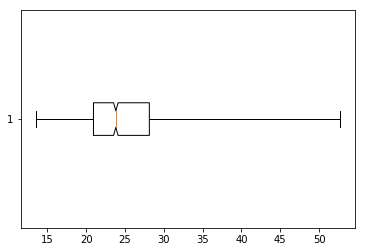

In [33]:
plt.figure()
plt.boxplot([winds_peak_E2_kts], notch=True, whis=[0,100], vert=False)

In [76]:
print(np.mean(winds_peak_E2_kts))

24.928595544106233


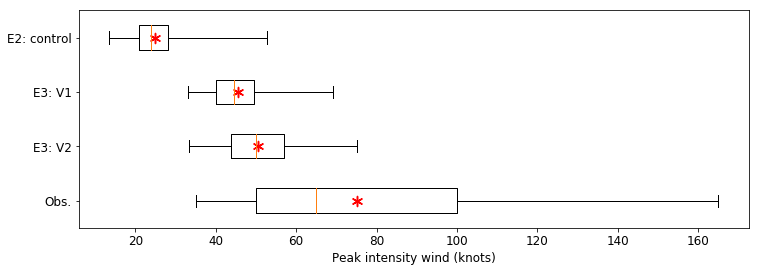

In [77]:
#OK, now show along with E3 and obs. (global)
plt.figure(figsize=(12,4))
plt.boxplot([ds_tracks_IB['max_usa_wind'].data, 
             ds_tracks_v2['max_wind_kts'].data,
             ds_tracks_v1['max_wind_kts'].data,
             winds_peak_E2_kts],  
            notch=False, whis=[0,100], vert=False)
plt.scatter(np.array([ds_tracks_IB['max_usa_wind'].mean(dim='storm').data, 
                      ds_tracks_v2['max_wind_kts'].mean(dim='storm').data, 
                      ds_tracks_v1['max_wind_kts'].mean(dim='storm').data,
                      np.mean(winds_peak_E2_kts)]), 
            np.array([1.,2.,3., 4.]), 
            marker=(6,2), c='red', s=100)
plt.gca().set_yticklabels(['Obs.', 'E3: V2', 'E3: V1', 'E2: control'], fontsize=12)
plt.gca().tick_params(labelsize=12)
plt.xlabel('Peak intensity wind (knots)', fontsize=12)

plt.savefig('plots/E2_E3_Obs_Peakwinds.png')
plt.savefig('plots/E2_E3_Obs_Peakwinds.pdf')
#(Save standalone figure; add to histograms below)

#Not sure if want to include theme

In [43]:

#####   COMBINE E2/E3 BOXPLOT AND WIND/PRESSURE HISTOGRAMS INTO ONE FIGURE   #####


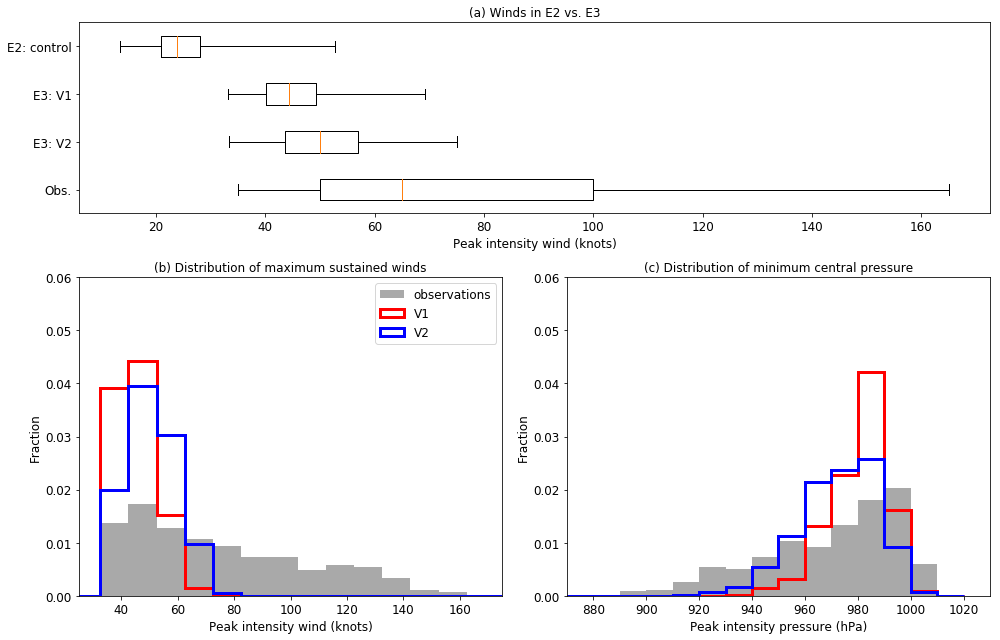

In [70]:
fig = plt.figure(figsize=(14,9))
#gs = #Gridspec not necessary actually? Just (2,1) on top row, (2,2) on bottom row!
#But: would be nice to make the box plots narrower
gs = GridSpec(5, 2, figure=fig)

#Top row: wind boxplots
#plt.subplot(2,1,1)
ax1 = fig.add_subplot(gs[0:2,:])
plt.boxplot([ds_tracks_IB['max_usa_wind'].data, 
             ds_tracks_v2['max_wind_kts'].data,
             ds_tracks_v1['max_wind_kts'].data,
             winds_peak_E2_kts],  
            notch=False, whis=[0,100], vert=False)

plt.gca().set_yticklabels(['Obs.', 'E3: V2', 'E3: V1', 'E2: control'], fontsize=12)
plt.gca().tick_params(labelsize=12)
plt.xlabel('Peak intensity wind (knots)', fontsize=12)
plt.title('(a) Winds in E2 vs. E3', fontsize=12)

#Bottom row: wind and pressure histograms
bins_wind_10 = np.linspace(5, 205, 21)-2.5 #Increments of 10--2.5, 12.5, 22.5, etc. surrounding 2 5-knot obs. possibilities each
bins_pres = np.arange(16)*10+870 #870 to 1020 hPa in units of 10

#plt.subplot(2,2,3)
ax2 = fig.add_subplot(gs[2:5,0])
plt.hist(ds_tracks_IB['max_usa_wind'], bins=bins_wind_10, density=True, histtype='stepfilled', linewidth=3, color='darkgrey')
plt.hist(ds_tracks_v1['max_wind_kts'], bins=bins_wind_10, density=True, histtype='step', linewidth=3, color='r')
plt.hist(ds_tracks_v2['max_wind_kts'], bins=bins_wind_10, density=True, histtype='step', linewidth=3, color='b')
plt.axis([25, 175, 0, 0.06])
plt.legend(['observations', 'V1', 'V2'], fontsize=12)
plt.title('(b) Distribution of maximum sustained winds', fontsize=12)
plt.xlabel('Peak intensity wind (knots)', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.gca().tick_params(labelsize=12)

#plt.subplot(2,2,4)
ax3 = fig.add_subplot(gs[2:5,1])
plt.hist(ds_tracks_IB['min_wmo_pres'], bins=bins_pres, density=True, histtype='stepfilled', linewidth=3, color='darkgrey') 
plt.hist(ds_tracks_v1['min_pressure']*100, bins=bins_pres, density=True, histtype='step', linewidth=3, color='r')
plt.hist(ds_tracks_v2['min_pressure']*100, bins=bins_pres, density=True, histtype='step', linewidth=3, color='b')
plt.axis([870, 1030, 0, 0.06])
#plt.legend(['V1', 'V2', 'observations'], fontsize=12)
plt.title('(c) Distribution of minimum central pressure', fontsize=12)
plt.xlabel('Peak intensity pressure (hPa)', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.gca().tick_params(labelsize=12)

plt.tight_layout()

plt.savefig('plots/combined_E2_E3_boxplots_histograms.png')
plt.savefig('plots/combined_E2_E3_boxplots_histograms.pdf')